In [1]:
import os
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from torch.utils.data import DataLoader
from torch.nn import DataParallel
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler
from torchvision.transforms import autoaugment, InterpolationMode
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold, train_test_split
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from torch.nn.parallel import DataParallel
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score, average_precision_score,precision_score,f1_score,recall_score

In [2]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class RetainRandomStateSettings:
    def __init__(self, tolerance: float = 1e-2):
        self.retention = tolerance
        self.__last_loss = float('inf')
        self.__initial_epoch_rng_state = torch.get_rng_state()

    def step(self):
        pass

class TolerateLossEpochsPeriod(RetainRandomStateSettings):
    def __init__(self, tolerance: float = 1e-2):
        super().__init__(tolerance)
        self.step = self.__update_epoch_at_first

    def __update_epoch_normally(self, loss):
        super().step()
        if abs(self.__last_loss - loss) < self.retention:
            print(f'|{self.__last_loss} - {loss}| < {self.retention}')
            print('new rng')
            self.__initial_epoch_rng_state = torch.get_rng_state()
        self.__last_loss = loss
        torch.set_rng_state(self.__initial_epoch_rng_state)

    def __update_epoch_at_first(self, loss):
        self.__initial_epoch_rng_state = torch.get_rng_state()
        self.step = self.__update_epoch_next
        
    def __update_epoch_next(self, loss):
        super().step()
        self.__last_loss = loss
        torch.set_rng_state(self.__initial_epoch_rng_state)
        self.step = self.__update_epoch_normally

class MyDataset(Dataset):
    def __init__(self, imgs, labels, transform=None, target_transform=None, augment_times=1, tolerance: float = 1e-2):
        self.imgs = imgs
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform
        self.augment_times = augment_times
        self.loss_tolerance = TolerateLossEpochsPeriod(tolerance)

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        path = self.imgs[idx]
        target = self.labels[idx]
        try:
            img = Image.open(path).convert('RGB')
            if not isinstance(img, Image.Image):
                raise TypeError(f"Image at index {idx} is of type {type(img)}, expected PIL Image.")
        except Exception as e:
            print(f"Error loading image at index {idx}: {e}")
            return None, None
        
        if self.transform:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

    def update_loss(self, loss):
        self.loss_tolerance.step(loss)


In [3]:
class ExceptableTrivialAugmentWide(autoaugment.TrivialAugmentWide):
    def __init__(
        self,
        num_magnitude_bins: int = 31,
        interpolation: InterpolationMode = InterpolationMode.NEAREST,
        fill = None,
        excepting = {}
    ) -> None:
        super().__init__(num_magnitude_bins,interpolation,fill)
        self.excepting = excepting

    def _augmentation_space(self, num_bins: int):
        result = super()._augmentation_space(num_bins)
        return {key: value for key, value in result.items() if key not in self.excepting}

In [4]:
num_classes = 5       # 输出的类别总数
patch_size = 16       # 对输入的图像进行切分的大小，表示切分后每个小块的大小
hidden_size = 512     # 隐藏层的维度大小
num_layers = 10       # 编码器中的层数
dropout_prob = 0.25    # Dropout操作的概率，用于防止过拟合
batch_size =128     # 批次大小
num_epochs = 75    # 训练轮数
learning_rate = 1e-4  # 学习率
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
import torch
import torch.nn.functional as F
import numpy as np
from torch import nn
import warnings


_BATCH_NORM_PARAMS = {
    'eps': 0.001,
    'momentum': 0.9997,
    'affine': True,
}


def autopad(k, p=None, d=1):  # kernel, padding, dilation
    # Pad to 'same' shape outputs
    if d > 1:
        k = d * (k - 1) + 1 if isinstance(k,
                                          int) else [d * (x - 1) + 1 for x in k]  # actual kernel-size
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p

def fixed_padding(inputs, kernel_size, rate=1):
    """Pads the input along the spatial dimensions independently of input size.
    
    Args:
        inputs: A tensor of size [batch, height_in, width_in, channels].
        kernel_size: The kernel to be used in the conv2d or max_pool2d 
            operation. Should be a positive integer.
        rate: An integer, rate for atrous convolution.
        
    Returns:
        padded_inputs: A tensor of size [batch, height_out, width_out, 
            channels] with the input, either intact (if kernel_size == 1) or 
            padded (if kernel_size > 1).
    """
    kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
    pad_total = kernel_size_effective - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg
    padded_inputs = torch.nn.functional.pad(
        inputs, pad=(pad_beg, pad_end, pad_beg, pad_end))
    return padded_inputs


class SeparableConv2d(torch.nn.Module):
    """Strided 2-D separable convolution with 'SAME' padding."""
    
    def __init__(self, in_channels, out_channels, kernel_size=1, 
                 stride=1, groups=1, depth_multiplier=1, rate=1, use_explicit_padding=True, 
                 activation_func=None, **kwargs):
        """Constructor.
        
        If stride > 1 and use_explicit_padding is True, then we do explicit
        zero-padding, followed by conv2d with 'VALID' padding.
        
        Args:
            in_channels: An integer, the number of input filters.
            out_channels: An integer, the number of output filters.
            kernel_size: An integer with the kernel_size of the filters.
            depth_multiplier: The number of depthwise convolution output
                channels for each input channel. The total number of depthwise
                convolution output channels will be equal to `num_filters_in *
                depth_multiplier`.
            stride: An integer, the output stride.
            rate: An integer, rate for atrous convolution.
            use_explicit_padding: If True, use explicit padding to make the
                model fully compatible with the open source version, otherwise
                use the nattive Pytorch 'SAME' padding.
            activation_func: Activation function.
            **kwargs: Additional keyword arguments to pass to torch.nn.Conv2d.
        """
        super(SeparableConv2d, self).__init__()
        self.__kernel_size = kernel_size
        self.__rate = rate
        self.__without_padding = stride == 1 or not use_explicit_padding
        
        out_channels_depthwise = in_channels * depth_multiplier
        if self.__without_padding:
            # Separable convolution for padding 'SAME'
            # Here, we assume that floor(padding) = padding
            padding = (kernel_size - 1) * rate // 2
            self.conv_depthwise = torch.nn.Conv2d(in_channels, 
                                                   out_channels_depthwise,
                                                   kernel_size=kernel_size, 
                                                   stride=stride, 
                                                   dilation=rate,
                                                   groups=in_channels,
                                                   padding=padding,
                                                   bias=False,
                                                   **kwargs)
        else:
            # Separable convolution for padding 'VALID'
            self.conv_depthwise = torch.nn.Conv2d(in_channels,
                                                   out_channels_depthwise,
                                                   kernel_size=kernel_size, 
                                                   stride=stride,
                                                   dilation=rate,
                                                   groups=in_channels,
                                                   bias=False,
                                                   **kwargs)
        self.batch_norm_depthwise = torch.nn.BatchNorm2d(
            out_channels_depthwise, **_BATCH_NORM_PARAMS)
        self.conv_pointwise = torch.nn.Conv2d(out_channels_depthwise,
                                               out_channels,
                                               kernel_size=1, 
                                               stride=1,
                                               groups=groups,
                                               bias=False,
                                               **kwargs)
        self.batch_norm_pointwise = torch.nn.BatchNorm2d(
            out_channels, **_BATCH_NORM_PARAMS)
        self.activation_func = activation_func
    
    def forward(self, x):
        """
        Input: [batch, height_in, width_in, channels]
        Output: [batch, height_out, width_out, channels]
        """
        if not self.__without_padding:
            x = fixed_padding(x, self.__kernel_size, self.__rate)
        x = self.conv_depthwise(x)
        x = self.batch_norm_depthwise(x)
        if self.activation_func is not None:
            x = self.activation_func(x)
        x = self.conv_pointwise(x)
        x = self.batch_norm_pointwise(x)
        if self.activation_func is not None:
            x = self.activation_func(x)
        return x


class Focus(nn.Module):
    # Focus wh information into c-space
    # ch_in, ch_out, kernel, stride, padding, groups
    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, n=1, act=True):
        super().__init__()
        self.n = n
        self.conv = None
        expected_in_channels = c1 * (4**n)
        if expected_in_channels != c2:
            self.conv = Conv(expected_in_channels, c2, k, s, p, g, act=act)

    def forward(self, x):  # x(b,c,w,h) -> y(b,c*4^n,w/2^n,h/2^n)
        for _ in range(self.n):
            x = torch.cat((x[..., ::2, ::2], x[..., 1::2, ::2],
                          x[..., ::2, 1::2], x[..., 1::2, 1::2]), 1)
        if self.conv is not None:
            x = self.conv(x)
        return x


class Conv(nn.Module):
    # Standard convolution with args(ch_in, ch_out, kernel, stride, padding, groups, dilation, activation)
    default_act = nn.SiLU()  # default activation

    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, d=1, act=True):
        super().__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, autopad(
            k, p, d), groups=g, dilation=d, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = self.default_act if act is True else act if isinstance(
            act, nn.Module) else nn.Identity()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

    def forward_fuse(self, x):
        return self.act(self.conv(x))


class SeparableBottleneck(nn.Module):
    # Standard bottleneck
    # ch_in, ch_out, shortcut, groups, expansion
    def __init__(self, c1, c2, shortcut=True, g=1, e=0.5):
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = SeparableConv2d(c1, c_, 1, 1)
        self.cv2 = SeparableConv2d(c_, c2, 3, 1, groups=g)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        return x + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))


class SeparableC3(nn.Module):
    # CSP Bottleneck with 3 convolutions
    # ch_in, ch_out, number, shortcut, groups, expansion
    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5):
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = SeparableConv2d(c1, c_, 1, 1)
        self.cv2 = Conv(c1, c_, 1, 1)
        self.cv3 = SeparableConv2d(2 * c_, c2, 1)  # optional act=FReLU(c2)
        self.m = nn.Sequential(
            *(SeparableBottleneck(c_, c_, shortcut, g, e=1.0) for _ in range(n)))

    def forward(self, x):
        return self.cv3(torch.cat((self.m(self.cv1(x)), self.cv2(x)), 1))


class SPPF(nn.Module):
    # Spatial Pyramid Pooling - Fast (SPPF) layer for YOLOv5 by Glenn Jocher
    def __init__(self, c1, c2, k=5):  # equivalent to SPP(k=(5, 9, 13))
        super().__init__()
        c_ = c1 // 2  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_ * 4, c2, 1, 1)
        self.m = nn.MaxPool2d(kernel_size=k, stride=1, padding=k // 2)

    def forward(self, x):
        x = self.cv1(x)
        with warnings.catch_warnings():
            # suppress torch 1.9.0 max_pool2d() warning
            warnings.simplefilter('ignore')
            y1 = self.m(x)
            y2 = self.m(y1)
            return self.cv2(torch.cat((x, y1, y2, self.m(y2)), 1))


class SingleEncoderModule(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, n: int = 1, has_leading_max_pool: bool = True):
        super(SingleEncoderModule, self).__init__()
        layers: list[nn.Module] = []
        if has_leading_max_pool:
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        layers += [
            Conv(in_channels, out_channels, 3, 1),
            SeparableC3(out_channels, out_channels, n)
        ]
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)
        return x
    
class SPPSingleEncoderModule(SingleEncoderModule):
    def __init__(self, in_channels: int, out_channels: int, n: int = 1, has_leading_max_pool: bool = True):
        super().__init__(in_channels, out_channels, n, has_leading_max_pool)
        layers = list(self.layers.children())
        layers.insert(len(layers)-1,SPPF(out_channels, out_channels))
        self.layers = nn.Sequential(*layers)

class ViTModule(nn.Module):
    def __init__(self, channels_in, channels_out, patch_size, num_layers, num_heads,fropout=dropout_prob):
        super(ViTModule, self).__init__()
        self.channels_out = channels_out
        self.patch_embedding = None
        if channels_in != channels_out:
            self.patch_embedding = nn.Sequential(
                nn.Conv2d(channels_in, channels_out,
                          kernel_size=patch_size, stride=patch_size),
                nn.BatchNorm2d(channels_out),
                nn.GELU(),
                nn.Conv2d(channels_out, channels_out,
                          kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(channels_out),
                nn.GELU()
            )

        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=channels_out, nhead=num_heads,dropout=dropout_prob),
            num_layers=num_layers
        )

    def forward(self, x: torch.Tensor):
        if self.patch_embedding is not None:
            x = self.patch_embedding(x)
        b, _, w, h = x.shape
        x = x.flatten(2).permute(2, 0, 1)
        x = self.transformer_encoder(x)

        x = x.permute(1, 2, 0).reshape(b, self.channels_out, w, h)
        return x


class VTCNet(nn.Module):
    def __init__(self, num_classes: int = 1):
        super(VTCNet, self).__init__()
        # self.batch_norm = nn.BatchNorm2d(3)

        self.focus = Focus(3, 12)
        self.vit = ViTModule(12, 1024, patch_size=16, num_layers=3, num_heads=8)

        self.encoders = nn.Sequential(
            SingleEncoderModule(12, 64, has_leading_max_pool=False),
            SingleEncoderModule(64, 128, 2),
            SingleEncoderModule(128, 256, 3),
            SingleEncoderModule(256, 512),
            SingleEncoderModule(512, 512)
        )

        self.classifier = nn.Sequential(
            nn.Conv2d(512+1024, num_classes, 1 , 1),
            nn.BatchNorm2d(num_classes),
            nn.GELU()
        )
        
        self.avg_pool = nn.AdaptiveMaxPool2d(1)

    def forward(self, x: torch.Tensor):
        x = x.view(-1, *(x.shape[-3:]))
        # x = self.batch_norm(x)
        x = self.focus(x)
        encoded = self.encoders(x)
        x = self.vit(x)
        # x=encoded
        x = torch.concat([x, encoded], dim=1)
        del encoded
        x = self.classifier(x)
        x = self.avg_pool(x).flatten(2)
        x = x.squeeze(dim=2)
        return x

    def save_weights(self, path: str):
        torch.save(self.state_dict(), path)

    def load_weights(self, path: str):
        self.load_state_dict(torch.load(path))


In [6]:
def initialize_weights(model):
    for m in model.modules():
        t = type(m)
        if t is nn.Conv2d:
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        elif t is nn.BatchNorm2d:
            m.eps = 1e-3
            m.momentum = 0.03
        elif t in [nn.Hardswish, nn.LeakyReLU, nn.ReLU, nn.ReLU6, nn.SiLU]:
            m.inplace = True

In [7]:
import numpy as np
from collections.abc import Iterable
from numpy._typing import DTypeLike

def apply_from_axis(func, arr: np.ndarray, axis = 0, otypes: Iterable[DTypeLike] = ...):
    slices = (slice(None,None,None),)*(axis)
    if len(otypes) > 1:
        return tuple(np.array(item,dtype=otypes[i]) for i,item in enumerate(zip(*[func(arr[slices+(i,)]) for i in range(arr.shape[axis])])))
    else:
        return np.array([func(arr[slices+(i,)]) for i in range(arr.shape[axis])],otypes[0],copy=False)

np.apply_from_axis = apply_from_axis

Fold 1


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/75


100%|██████████| 25/25 [00:30<00:00,  1.21s/it]


Train Loss: 0.9323320269584656
Train Acc (3077): 65.09587260318492%
------Weighted------
Weighted precision 0.6486889090941891
Weighted recall 0.6509587260318492
Weighted f1-score 0.6476375025464295
------Macro------
Macro precision 0.6494776515742036
Macro recall 0.6513265306837528
Macro f1-score 0.6482387731191859


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


Val Loss: 0.7954382300376892
Val Acc (162): 72.22222222222223%
------Weighted------
Weighted precision 0.7747878529870866
Weighted recall 0.7222222222222222
Weighted f1-score 0.7284227408748482
------Macro------
Macro precision 0.7759244663382595
Macro recall 0.7204728739002932
Macro f1-score 0.7281546040166729
Training Loss: 0.9323, Training Accuracy: 65.10%
Validation Loss: 0.7954, Validation Accuracy: 72.22%
Epoch 2/75


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.5418014022707939
Train Acc (3077): 80.5004874878128%
------Weighted------
Weighted precision 0.8048939283314307
Weighted recall 0.805004874878128
Weighted f1-score 0.8048198049334807
------Macro------
Macro precision 0.8054641264824218
Macro recall 0.8053295783268897
Macro f1-score 0.8052662230691563


100%|██████████| 2/2 [00:00<00:00,  6.13it/s]


Val Loss: 0.9692674279212952
Val Acc (162): 72.22222222222223%
------Weighted------
Weighted precision 0.7892864539416263
Weighted recall 0.7222222222222222
Weighted f1-score 0.7108969670596341
------Macro------
Macro precision 0.7914796076865043
Macro recall 0.7181146138807429
Macro f1-score 0.7086274370630936
Training Loss: 0.5418, Training Accuracy: 80.50%
Validation Loss: 0.9693, Validation Accuracy: 72.22%
Epoch 3/75


100%|██████████| 25/25 [00:10<00:00,  2.39it/s]


Train Loss: 0.3197145640850067
Train Acc (3077): 90.41273968150796%
------Weighted------
Weighted precision 0.9038186673830528
Weighted recall 0.9041273968150796
Weighted f1-score 0.9038973566896461
------Macro------
Macro precision 0.903926940182831
Macro recall 0.9045081559245188
Macro f1-score 0.9041419089716914


100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


Val Loss: 1.082917034626007
Val Acc (162): 64.81481481481481%
------Weighted------
Weighted precision 0.7226764142534753
Weighted recall 0.6481481481481481
Weighted f1-score 0.617850061776291
------Macro------
Macro precision 0.7249769585253457
Macro recall 0.6434445259042033
Macro f1-score 0.6153317610183685
Training Loss: 0.3197, Training Accuracy: 90.41%
Validation Loss: 1.0829, Validation Accuracy: 64.81%
Epoch 4/75


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.17503407955169678
Train Acc (3077): 96.39259018524537%
------Weighted------
Weighted precision 0.9638691266143379
Weighted recall 0.9639259018524536
Weighted f1-score 0.9638904387774724
------Macro------
Macro precision 0.9639861713852212
Macro recall 0.964032866421283
Macro f1-score 0.9640025044605045


100%|██████████| 2/2 [00:00<00:00,  6.15it/s]


Val Loss: 1.1069993376731873
Val Acc (162): 68.51851851851852%
------Weighted------
Weighted precision 0.7905188689910913
Weighted recall 0.6851851851851852
Weighted f1-score 0.6646981403030292
------Macro------
Macro precision 0.7938614163614164
Macro recall 0.6811827956989248
Macro f1-score 0.6635411799520293
Training Loss: 0.1750, Training Accuracy: 96.39%
Validation Loss: 1.1070, Validation Accuracy: 68.52%
Epoch 5/75


100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


Train Loss: 0.10773600593209266
Train Acc (3077): 98.57003574910627%
------Weighted------
Weighted precision 0.9856763004200111
Weighted recall 0.9857003574910628
Weighted f1-score 0.985685780708688
------Macro------
Macro precision 0.985728870317865
Macro recall 0.9857546929157124
Macro f1-score 0.9857392811855652


100%|██████████| 2/2 [00:00<00:00,  6.06it/s]


Val Loss: 1.0555026531219482
Val Acc (162): 72.22222222222223%
------Weighted------
Weighted precision 0.8061432508269823
Weighted recall 0.7222222222222222
Weighted f1-score 0.7014361980823366
------Macro------
Macro precision 0.8090409597461157
Macro recall 0.7179252199413491
Macro f1-score 0.6997620173444214
Training Loss: 0.1077, Training Accuracy: 98.57%
Validation Loss: 1.0555, Validation Accuracy: 72.22%
|0.17503407955169678 - 0.10773600593209266| < 0.07
new rng
Epoch 6/75


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.3987964737415314
Train Acc (3077): 88.13779655508613%
------Weighted------
Weighted precision 0.880981298738242
Weighted recall 0.8813779655508612
Weighted f1-score 0.8811273563977438
------Macro------
Macro precision 0.8812895805120714
Macro recall 0.881757823439101
Macro f1-score 0.881472278566054


100%|██████████| 2/2 [00:00<00:00,  5.95it/s]


Val Loss: 0.9538340270519257
Val Acc (162): 64.81481481481481%
------Weighted------
Weighted precision 0.7548289185544087
Weighted recall 0.6481481481481481
Weighted f1-score 0.6043885414666927
------Macro------
Macro precision 0.7574847727788905
Macro recall 0.6432429130009776
Macro f1-score 0.6013340755246397
Training Loss: 0.3988, Training Accuracy: 88.14%
Validation Loss: 0.9538, Validation Accuracy: 64.81%
Epoch 7/75


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.20221031188964844
Train Acc (3077): 96.4900877478063%
------Weighted------
Weighted precision 0.9649127888873581
Weighted recall 0.9649008774780631
Weighted f1-score 0.9648935924039886
------Macro------
Macro precision 0.9649960657526467
Macro recall 0.9650346841845554
Macro f1-score 0.9650022155110781


100%|██████████| 2/2 [00:00<00:00,  6.04it/s]


Val Loss: 1.0587711930274963
Val Acc (162): 63.58024691358025%
------Weighted------
Weighted precision 0.7745131228888291
Weighted recall 0.6358024691358025
Weighted f1-score 0.5719950397183499
------Macro------
Macro precision 0.777227602905569
Macro recall 0.6313110948191593
Macro f1-score 0.569846800843527
Training Loss: 0.2022, Training Accuracy: 96.49%
Validation Loss: 1.0588, Validation Accuracy: 63.58%
Epoch 8/75


100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


Train Loss: 0.13851495295763017
Train Acc (3077): 98.89502762430939%
------Weighted------
Weighted precision 0.9890237212772309
Weighted recall 0.988950276243094
Weighted f1-score 0.9889554290615
------Macro------
Macro precision 0.9889807752599621
Macro recall 0.9890066242247908
Macro f1-score 0.9889620303121406


100%|██████████| 2/2 [00:00<00:00,  6.04it/s]


Val Loss: 0.8082762062549591
Val Acc (162): 82.71604938271605%
------Weighted------
Weighted precision 0.8637997256515776
Weighted recall 0.8271604938271605
Weighted f1-score 0.8191160005453962
------Macro------
Macro precision 0.8642222222222223
Macro recall 0.8285496089931573
Macro f1-score 0.8204790824091834
Training Loss: 0.1385, Training Accuracy: 98.90%
Validation Loss: 0.8083, Validation Accuracy: 82.72%
|0.20221031188964844 - 0.13851495295763017| < 0.07
new rng
Epoch 9/75


100%|██████████| 25/25 [00:10<00:00,  2.37it/s]


Train Loss: 0.43164742588996885
Train Acc (3077): 86.80532986675333%
------Weighted------
Weighted precision 0.8680162259034604
Weighted recall 0.8680532986675333
Weighted f1-score 0.8672679406068531
------Macro------
Macro precision 0.8687410216896001
Macro recall 0.868425132267315
Macro f1-score 0.8678227228998223


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


Val Loss: 0.37600092589855194
Val Acc (162): 88.27160493827161%
------Weighted------
Weighted precision 0.8926602367462583
Weighted recall 0.8827160493827161
Weighted f1-score 0.8809216706218042
------Macro------
Macro precision 0.8926832539735766
Macro recall 0.8836876832844576
Macro f1-score 0.8815142036367215
Training Loss: 0.4316, Training Accuracy: 86.81%
Validation Loss: 0.3760, Validation Accuracy: 88.27%
Epoch 10/75


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.245931738615036
Train Acc (3077): 93.53266168345792%
------Weighted------
Weighted precision 0.9351071584806773
Weighted recall 0.9353266168345792
Weighted f1-score 0.9351630925613804
------Macro------
Macro precision 0.9352246424885744
Macro recall 0.935694286120269
Macro f1-score 0.9354054838535367


100%|██████████| 2/2 [00:00<00:00,  5.92it/s]


Val Loss: 0.26914307475090027
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9343736671623382
Weighted recall 0.9320987654320988
Weighted f1-score 0.9307044648984656
------Macro------
Macro precision 0.9346280734516028
Macro recall 0.9323619257086999
Macro f1-score 0.9310009490739859
Training Loss: 0.2459, Training Accuracy: 93.53%
Validation Loss: 0.2691, Validation Accuracy: 93.21%
Epoch 11/75


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.1522160452604294
Train Acc (3077): 97.46506337341566%
------Weighted------
Weighted precision 0.9746430427938503
Weighted recall 0.9746506337341566
Weighted f1-score 0.9746325691262494
------Macro------
Macro precision 0.9746659127590395
Macro recall 0.9747691110915847
Macro f1-score 0.974703094727993


100%|██████████| 2/2 [00:00<00:00,  6.38it/s]


Val Loss: 0.24135445058345795
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9400848405205703
Weighted recall 0.9382716049382716
Weighted f1-score 0.9368132106352768
------Macro------
Macro precision 0.9400905595212995
Macro recall 0.9388135386119257
Macro f1-score 0.9371187704740056
Training Loss: 0.1522, Training Accuracy: 97.47%
Validation Loss: 0.2414, Validation Accuracy: 93.83%
Epoch 12/75


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.08680452734231948
Train Acc (3077): 99.25251868703282%
------Weighted------
Weighted precision 0.9925237316047175
Weighted recall 0.9925251868703282
Weighted f1-score 0.992517482829352
------Macro------
Macro precision 0.9925275849700315
Macro recall 0.9925774239360721
Macro f1-score 0.9925456124885222


100%|██████████| 2/2 [00:00<00:00,  6.34it/s]


Val Loss: 0.21621058136224747
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9455000518726008
Weighted recall 0.9444444444444444
Weighted f1-score 0.943367411352542
------Macro------
Macro precision 0.9455651938194632
Macro recall 0.9448741446725318
Macro f1-score 0.9436387784816574
Training Loss: 0.0868, Training Accuracy: 99.25%
Validation Loss: 0.2162, Validation Accuracy: 94.44%
|0.1522160452604294 - 0.08680452734231948| < 0.07
new rng
Epoch 13/75


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.2585417848825455
Train Acc (3077): 92.33019174520636%
------Weighted------
Weighted precision 0.9232408758328288
Weighted recall 0.9233019174520637
Weighted f1-score 0.9232404312619725
------Macro------
Macro precision 0.9233738874996336
Macro recall 0.9234810972213788
Macro f1-score 0.9233964129080812


100%|██████████| 2/2 [00:00<00:00,  5.95it/s]


Val Loss: 0.20950092375278473
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9455260667678969
Weighted recall 0.9444444444444444
Weighted f1-score 0.9448050485975615
------Macro------
Macro precision 0.9455614973262033
Macro recall 0.9442937438905181
Macro f1-score 0.9447462675160253
Training Loss: 0.2585, Training Accuracy: 92.33%
Validation Loss: 0.2095, Validation Accuracy: 94.44%
Epoch 14/75


100%|██████████| 25/25 [00:10<00:00,  2.39it/s]


Train Loss: 0.1923804196715355
Train Acc (3077): 95.64510887227819%
------Weighted------
Weighted precision 0.9565608416108711
Weighted recall 0.956451088722782
Weighted f1-score 0.9564953401822062
------Macro------
Macro precision 0.9566047255190743
Macro recall 0.956528788790569
Macro f1-score 0.9565563708626034


100%|██████████| 2/2 [00:00<00:00,  6.10it/s]


Val Loss: 0.24906950443983078
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9330857323016821
Weighted recall 0.9320987654320988
Weighted f1-score 0.9310663597161892
------Macro------
Macro precision 0.9331118791602663
Macro recall 0.93180596285435
Macro f1-score 0.9309344172451588
Training Loss: 0.1924, Training Accuracy: 95.65%
Validation Loss: 0.2491, Validation Accuracy: 93.21%
|0.2585417848825455 - 0.1923804196715355| < 0.07
new rng
Epoch 15/75


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.25448965907096865
Train Acc (3077): 92.16769580760482%
------Weighted------
Weighted precision 0.921938892453639
Weighted recall 0.9216769580760481
Weighted f1-score 0.9216954311768498
------Macro------
Macro precision 0.9221303150244575
Macro recall 0.9220698375269452
Macro f1-score 0.9219878423068408


100%|██████████| 2/2 [00:00<00:00,  6.12it/s]


Val Loss: 0.19274742901325226
Val Acc (162): 90.74074074074075%
------Weighted------
Weighted precision 0.9102441902687001
Weighted recall 0.9074074074074074
Weighted f1-score 0.9046333397043613
------Macro------
Macro precision 0.9108660130718954
Macro recall 0.9069953567937439
Macro f1-score 0.9047078273230122
Training Loss: 0.2545, Training Accuracy: 92.17%
Validation Loss: 0.1927, Validation Accuracy: 90.74%
|0.1923804196715355 - 0.25448965907096865| < 0.07
new rng
Epoch 16/75


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.2718603789806366
Train Acc (3077): 92.1351966200845%
------Weighted------
Weighted precision 0.9217687597018368
Weighted recall 0.921351966200845
Weighted f1-score 0.9215134593255361
------Macro------
Macro precision 0.9218134182401666
Macro recall 0.9214614640291741
Macro f1-score 0.9215914379206442


100%|██████████| 2/2 [00:00<00:00,  6.12it/s]


Val Loss: 0.14837468042969704
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9694989106753813
Weighted recall 0.9691358024691358
Weighted f1-score 0.9692234033233952
------Macro------
Macro precision 0.969674688057041
Macro recall 0.9689271749755621
Macro f1-score 0.9692054815342068
Training Loss: 0.2719, Training Accuracy: 92.14%
Validation Loss: 0.1484, Validation Accuracy: 96.91%
|0.25448965907096865 - 0.2718603789806366| < 0.07
new rng
Epoch 17/75


100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


Train Loss: 0.21894202053546905
Train Acc (3077): 93.37016574585635%
------Weighted------
Weighted precision 0.9336946031796102
Weighted recall 0.9337016574585635
Weighted f1-score 0.9336436430423835
------Macro------
Macro precision 0.9335661864471737
Macro recall 0.9337002894466776
Macro f1-score 0.9335788491619894


100%|██████████| 2/2 [00:00<00:00,  6.46it/s]


Val Loss: 0.17607002705335617
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.944318276892597
Weighted recall 0.9444444444444444
Weighted f1-score 0.9439405387945977
------Macro------
Macro precision 0.9445486581729465
Macro recall 0.944495356793744
Macro f1-score 0.944087794401985
Training Loss: 0.2189, Training Accuracy: 93.37%
Validation Loss: 0.1761, Validation Accuracy: 94.44%
|0.2718603789806366 - 0.21894202053546905| < 0.07
new rng
Epoch 18/75


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.20366558253765107
Train Acc (3077): 94.41013974650633%
------Weighted------
Weighted precision 0.9439595097988076
Weighted recall 0.9441013974650634
Weighted f1-score 0.943952889033202
------Macro------
Macro precision 0.9441039585585906
Macro recall 0.9442953285776163
Macro f1-score 0.9441231320486307


100%|██████████| 2/2 [00:00<00:00,  6.11it/s]


Val Loss: 0.13925179094076157
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9388478305328091
Weighted recall 0.9382716049382716
Weighted f1-score 0.9376886768687565
------Macro------
Macro precision 0.9391507084850996
Macro recall 0.93805596285435
Macro f1-score 0.9377351237899736
Training Loss: 0.2037, Training Accuracy: 94.41%
Validation Loss: 0.1393, Validation Accuracy: 93.83%
|0.21894202053546905 - 0.20366558253765107| < 0.07
new rng
Epoch 19/75


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.24503316462039948
Train Acc (3077): 93.40266493337667%
------Weighted------
Weighted precision 0.9339566035236605
Weighted recall 0.9340266493337667
Weighted f1-score 0.9339532187869809
------Macro------
Macro precision 0.9339144026816539
Macro recall 0.9341500104604725
Macro f1-score 0.9339939815584988


100%|██████████| 2/2 [00:00<00:00,  5.92it/s]


Val Loss: 0.18624865263700485
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9339726631393299
Weighted recall 0.9320987654320988
Weighted f1-score 0.9324458990659238
------Macro------
Macro precision 0.9339163524647397
Macro recall 0.9325635386119258
Macro f1-score 0.9326499509558008
Training Loss: 0.2450, Training Accuracy: 93.40%
Validation Loss: 0.1862, Validation Accuracy: 93.21%
|0.20366558253765107 - 0.24503316462039948| < 0.07
new rng
Epoch 20/75


100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


Train Loss: 0.24050322353839873
Train Acc (3077): 92.81767955801105%
------Weighted------
Weighted precision 0.9285936602583748
Weighted recall 0.9281767955801105
Weighted f1-score 0.928192805211119
------Macro------
Macro precision 0.9290418164971784
Macro recall 0.928336231810707
Macro f1-score 0.9284992444369287


100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


Val Loss: 0.15153725445270538
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9460574661963551
Weighted recall 0.9444444444444444
Weighted f1-score 0.9443103955648758
------Macro------
Macro precision 0.9452489177489177
Macro recall 0.9446969696969697
Macro f1-score 0.944001804646966
Training Loss: 0.2405, Training Accuracy: 92.82%
Validation Loss: 0.1515, Validation Accuracy: 94.44%
|0.24503316462039948 - 0.24050322353839873| < 0.07
new rng
Epoch 21/75


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.20923811465501785
Train Acc (3077): 94.18264543386415%
------Weighted------
Weighted precision 0.941568417966279
Weighted recall 0.9418264543386415
Weighted f1-score 0.9416562094857741
------Macro------
Macro precision 0.9417677416402632
Macro recall 0.942190326479867
Macro f1-score 0.9419379492644353


100%|██████████| 2/2 [00:00<00:00,  6.18it/s]


Val Loss: 0.17965178191661835
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9452968841857732
Weighted recall 0.9444444444444444
Weighted f1-score 0.9446082781344756
------Macro------
Macro precision 0.9455086580086581
Macro recall 0.9442937438905181
Macro f1-score 0.9446404872851353
Training Loss: 0.2092, Training Accuracy: 94.18%
Validation Loss: 0.1797, Validation Accuracy: 94.44%
|0.24050322353839873 - 0.20923811465501785| < 0.07
new rng
Epoch 22/75


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.25424890518188475
Train Acc (3077): 92.6876828079298%
------Weighted------
Weighted precision 0.9268653350700361
Weighted recall 0.926876828079298
Weighted f1-score 0.9268155446250295
------Macro------
Macro precision 0.9267357143324564
Macro recall 0.9266475671352614
Macro f1-score 0.9266352465394405


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


Val Loss: 0.10692854225635529
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.964405650026565
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630265025564875
------Macro------
Macro precision 0.9646855105678636
Macro recall 0.9626649560117302
Macro f1-score 0.9630149872807907
Training Loss: 0.2542, Training Accuracy: 92.69%
Validation Loss: 0.1069, Validation Accuracy: 96.30%
|0.20923811465501785 - 0.25424890518188475| < 0.07
new rng
Epoch 23/75


100%|██████████| 25/25 [00:11<00:00,  2.27it/s]


Train Loss: 0.1691824385523796
Train Acc (3077): 95.06012349691258%
------Weighted------
Weighted precision 0.9504786381998396
Weighted recall 0.9506012349691257
Weighted f1-score 0.9505084421595672
------Macro------
Macro precision 0.9506300566510004
Macro recall 0.9507948076332019
Macro f1-score 0.9506813783635956


100%|██████████| 2/2 [00:00<00:00,  5.46it/s]


Val Loss: 0.1655551642179489
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9583091971084803
Weighted recall 0.9567901234567902
Weighted f1-score 0.956743586302765
------Macro------
Macro precision 0.9586999022482893
Macro recall 0.9566043499511242
Macro f1-score 0.956846305868045
Training Loss: 0.1692, Training Accuracy: 95.06%
Validation Loss: 0.1656, Validation Accuracy: 95.68%
Epoch 24/75


100%|██████████| 25/25 [00:10<00:00,  2.34it/s]


Train Loss: 0.11518881589174271
Train Acc (3077): 97.72505687357815%
------Weighted------
Weighted precision 0.977255145645957
Weighted recall 0.9772505687357816
Weighted f1-score 0.977230680277558
------Macro------
Macro precision 0.9773435253698872
Macro recall 0.9772858640668541
Macro f1-score 0.9772927103154692


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


Val Loss: 0.17730972170829773
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9660809025256192
Weighted recall 0.9629629629629629
Weighted f1-score 0.9624718266225185
------Macro------
Macro precision 0.9656454248366014
Macro recall 0.9636363636363636
Macro f1-score 0.9626052506163043
Training Loss: 0.1152, Training Accuracy: 97.73%
Validation Loss: 0.1773, Validation Accuracy: 96.30%
|0.1691824385523796 - 0.11518881589174271| < 0.07
new rng
Epoch 25/75


100%|██████████| 25/25 [00:10<00:00,  2.36it/s]


Train Loss: 0.16335625499486922
Train Acc (3077): 96.00259993500163%
------Weighted------
Weighted precision 0.9600186001491575
Weighted recall 0.9600259993500162
Weighted f1-score 0.9600003446077315
------Macro------
Macro precision 0.9601439263261508
Macro recall 0.9601264380644461
Macro f1-score 0.9601132830150318


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


Val Loss: 0.16181007772684097
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9456800886908414
Weighted recall 0.9444444444444444
Weighted f1-score 0.9439741328630218
------Macro------
Macro precision 0.9460812131779874
Macro recall 0.9446847507331378
Macro f1-score 0.944313177861565
Training Loss: 0.1634, Training Accuracy: 96.00%
Validation Loss: 0.1618, Validation Accuracy: 94.44%
|0.11518881589174271 - 0.16335625499486922| < 0.07
new rng
Epoch 26/75


100%|██████████| 25/25 [00:10<00:00,  2.38it/s]


Train Loss: 0.2440694624185562
Train Acc (3077): 93.98765030874227%
------Weighted------
Weighted precision 0.9398818004026617
Weighted recall 0.9398765030874228
Weighted f1-score 0.939724224693732
------Macro------
Macro precision 0.9400183558000401
Macro recall 0.9399790677924708
Macro f1-score 0.9398449909638711


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


Val Loss: 0.1340014934539795
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9691120100967507
Weighted recall 0.9691358024691358
Weighted f1-score 0.9688450567561956
------Macro------
Macro precision 0.9691054280949917
Macro recall 0.9695075757575757
Macro f1-score 0.9690297161379251
Training Loss: 0.2441, Training Accuracy: 93.99%
Validation Loss: 0.1340, Validation Accuracy: 96.91%
Epoch 27/75


100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


Train Loss: 0.19260084599256516
Train Acc (3077): 94.83262918427039%
------Weighted------
Weighted precision 0.9487750172702416
Weighted recall 0.9483262918427039
Weighted f1-score 0.9484927797363689
------Macro------
Macro precision 0.9486265106659731
Macro recall 0.948149272428593
Macro f1-score 0.9483309625036351


100%|██████████| 2/2 [00:00<00:00,  6.17it/s]


Val Loss: 0.1409057006239891
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.962939170590578
Weighted recall 0.9629629629629629
Weighted f1-score 0.9626722172500227
------Macro------
Macro precision 0.9628554280949917
Macro recall 0.9632575757575758
Macro f1-score 0.962779716137925
Training Loss: 0.1926, Training Accuracy: 94.83%
Validation Loss: 0.1409, Validation Accuracy: 96.30%
|0.2440694624185562 - 0.19260084599256516| < 0.07
new rng
Epoch 28/75


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.15390063136816023
Train Acc (3077): 95.74260643483913%
------Weighted------
Weighted precision 0.9574000633122949
Weighted recall 0.9574260643483913
Weighted f1-score 0.9573429633189594
------Macro------
Macro precision 0.9574214846115232
Macro recall 0.957571932049329
Macro f1-score 0.9574271119861322


100%|██████████| 2/2 [00:00<00:00,  6.34it/s]


Val Loss: 0.08882383070886135
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9691358024691358
Weighted recall 0.9691358024691358
Weighted f1-score 0.9690423431164171
------Macro------
Macro precision 0.968939393939394
Macro recall 0.9693181818181819
Macro f1-score 0.9690340215340216
Training Loss: 0.1539, Training Accuracy: 95.74%
Validation Loss: 0.0888, Validation Accuracy: 96.91%
|0.19260084599256516 - 0.15390063136816023| < 0.07
new rng
Epoch 29/75


100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Train Loss: 0.1662038794159889
Train Acc (3077): 96.13259668508287%
------Weighted------
Weighted precision 0.9613511354091216
Weighted recall 0.9613259668508287
Weighted f1-score 0.9613093006896996
------Macro------
Macro precision 0.961317864856019
Macro recall 0.9614083292074126
Macro f1-score 0.961334049499779


100%|██████████| 2/2 [00:00<00:00,  6.42it/s]


Val Loss: 0.10364267230033875
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9704180283224402
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691179876365063
------Macro------
Macro precision 0.9700423351158645
Macro recall 0.9695075757575757
Macro f1-score 0.9691197691197692
Training Loss: 0.1662, Training Accuracy: 96.13%
Validation Loss: 0.1036, Validation Accuracy: 96.91%
|0.15390063136816023 - 0.1662038794159889| < 0.07
new rng
Epoch 30/75


100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


Train Loss: 0.1297832378745079
Train Acc (3077): 96.36009099772505%
------Weighted------
Weighted precision 0.9638316793597124
Weighted recall 0.9636009099772506
Weighted f1-score 0.9635997777905755
------Macro------
Macro precision 0.9637711173580001
Macro recall 0.9637178991890343
Macro f1-score 0.9636271528907534


100%|██████████| 2/2 [00:00<00:00,  6.26it/s]


Val Loss: 0.12395165488123894
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9758756546950992
Weighted recall 0.9753086419753086
Weighted f1-score 0.9753071816729224
------Macro------
Macro precision 0.9755681818181818
Macro recall 0.9755681818181818
Macro f1-score 0.9752840215340216
Training Loss: 0.1298, Training Accuracy: 96.36%
Validation Loss: 0.1240, Validation Accuracy: 97.53%
|0.1662038794159889 - 0.1297832378745079| < 0.07
new rng
Epoch 31/75


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.11157362014055253
Train Acc (3077): 96.91257718557036%
------Weighted------
Weighted precision 0.969034941996297
Weighted recall 0.9691257718557036
Weighted f1-score 0.9690564827500191
------Macro------
Macro precision 0.9691003795948534
Macro recall 0.9691628720066268
Macro f1-score 0.9691076781089711


100%|██████████| 2/2 [00:00<00:00,  5.55it/s]


Val Loss: 0.12643695622682571
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9758756546950992
Weighted recall 0.9753086419753086
Weighted f1-score 0.9753071816729224
------Macro------
Macro precision 0.9755681818181818
Macro recall 0.9755681818181818
Macro f1-score 0.9752840215340216
Training Loss: 0.1116, Training Accuracy: 96.91%
Validation Loss: 0.1264, Validation Accuracy: 97.53%
|0.1297832378745079 - 0.11157362014055253| < 0.07
new rng
Epoch 32/75


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.11755583554506302
Train Acc (3077): 96.71758206044849%
------Weighted------
Weighted precision 0.9671697255624571
Weighted recall 0.9671758206044849
Weighted f1-score 0.967121613276861
------Macro------
Macro precision 0.9672084492407563
Macro recall 0.9673590523396884
Macro f1-score 0.9672325163496769


100%|██████████| 2/2 [00:00<00:00,  6.00it/s]


Val Loss: 0.08224314451217651
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9758756546950992
Weighted recall 0.9753086419753086
Weighted f1-score 0.9753071816729224
------Macro------
Macro precision 0.9755681818181818
Macro recall 0.9755681818181818
Macro f1-score 0.9752840215340216
Training Loss: 0.1176, Training Accuracy: 96.72%
Validation Loss: 0.0822, Validation Accuracy: 97.53%
|0.11157362014055253 - 0.11755583554506302| < 0.07
new rng
Epoch 33/75


100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Train Loss: 0.14422785222530365
Train Acc (3077): 96.42508937276568%
------Weighted------
Weighted precision 0.9643856206277492
Weighted recall 0.9642508937276568
Weighted f1-score 0.964291532498499
------Macro------
Macro precision 0.9644348970934719
Macro recall 0.9643988658293612
Macro f1-score 0.9643897890444159


100%|██████████| 2/2 [00:00<00:00,  5.99it/s]


Val Loss: 0.1268164962530136
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9758756546950992
Weighted recall 0.9753086419753086
Weighted f1-score 0.9753071816729224
------Macro------
Macro precision 0.9755681818181818
Macro recall 0.9755681818181818
Macro f1-score 0.9752840215340216
Training Loss: 0.1442, Training Accuracy: 96.43%
Validation Loss: 0.1268, Validation Accuracy: 97.53%
|0.11755583554506302 - 0.14422785222530365| < 0.07
new rng
Epoch 34/75


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.12802867114543914
Train Acc (3077): 96.88007799805006%
------Weighted------
Weighted precision 0.9687244812466355
Weighted recall 0.9688007799805005
Weighted f1-score 0.9687418889989776
------Macro------
Macro precision 0.9688345404231805
Macro recall 0.9689539306894004
Macro f1-score 0.9688738185014897


100%|██████████| 2/2 [00:00<00:00,  6.36it/s]


Val Loss: 0.07124542072415352
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9758756546950992
Weighted recall 0.9753086419753086
Weighted f1-score 0.9753071816729224
------Macro------
Macro precision 0.9755681818181818
Macro recall 0.9755681818181818
Macro f1-score 0.9752840215340216
Training Loss: 0.1280, Training Accuracy: 96.88%
Validation Loss: 0.0712, Validation Accuracy: 97.53%
|0.14422785222530365 - 0.12802867114543914| < 0.07
new rng
Epoch 35/75


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.12739006727933883
Train Acc (3077): 96.52258693532661%
------Weighted------
Weighted precision 0.9653830409696468
Weighted recall 0.9652258693532662
Weighted f1-score 0.9652817268226451
------Macro------
Macro precision 0.9654780841248674
Macro recall 0.9652094387948473
Macro f1-score 0.9653212760011541


100%|██████████| 2/2 [00:00<00:00,  6.15it/s]


Val Loss: 0.0737889464944601
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9816743827160493
Weighted recall 0.9814814814814815
Weighted f1-score 0.9814829888903963
------Macro------
Macro precision 0.981439393939394
Macro recall 0.9816287878787879
Macro f1-score 0.9814378676878677
Training Loss: 0.1274, Training Accuracy: 96.52%
Validation Loss: 0.0738, Validation Accuracy: 98.15%
|0.12802867114543914 - 0.12739006727933883| < 0.07
new rng
Epoch 36/75


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.1328321674466133
Train Acc (3077): 96.71758206044849%
------Weighted------
Weighted precision 0.9670972990320779
Weighted recall 0.9671758206044849
Weighted f1-score 0.9671277978156672
------Macro------
Macro precision 0.9671822307847036
Macro recall 0.9672434057236087
Macro f1-score 0.967204205727391


100%|██████████| 2/2 [00:00<00:00,  6.40it/s]


Val Loss: 0.07024724781513214
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9758756546950992
Weighted recall 0.9753086419753086
Weighted f1-score 0.9753071816729224
------Macro------
Macro precision 0.9755681818181818
Macro recall 0.9755681818181818
Macro f1-score 0.9752840215340216
Training Loss: 0.1328, Training Accuracy: 96.72%
Validation Loss: 0.0702, Validation Accuracy: 97.53%
|0.12739006727933883 - 0.1328321674466133| < 0.07
new rng
Epoch 37/75


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.16131525203585625
Train Acc (3077): 96.55508612284693%
------Weighted------
Weighted precision 0.96558861102903
Weighted recall 0.9655508612284693
Weighted f1-score 0.9655383683489811
------Macro------
Macro precision 0.9655569123918293
Macro recall 0.9655743927712834
Macro f1-score 0.9655338545682429


100%|██████████| 2/2 [00:00<00:00,  5.75it/s]


Val Loss: 0.09512799978256226
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9758756546950992
Weighted recall 0.9753086419753086
Weighted f1-score 0.9753071816729224
------Macro------
Macro precision 0.9755681818181818
Macro recall 0.9755681818181818
Macro f1-score 0.9752840215340216
Training Loss: 0.1613, Training Accuracy: 96.56%
Validation Loss: 0.0951, Validation Accuracy: 97.53%
|0.1328321674466133 - 0.16131525203585625| < 0.07
new rng
Epoch 38/75


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.11818205326795578
Train Acc (3077): 96.58758531036725%
------Weighted------
Weighted precision 0.9657895185482073
Weighted recall 0.9658758531036724
Weighted f1-score 0.965812895167188
------Macro------
Macro precision 0.9658493058588841
Macro recall 0.9659929697635734
Macro f1-score 0.9659013828815093


100%|██████████| 2/2 [00:00<00:00,  6.37it/s]


Val Loss: 0.07652916945517063
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9758756546950992
Weighted recall 0.9753086419753086
Weighted f1-score 0.9753071816729224
------Macro------
Macro precision 0.9755681818181818
Macro recall 0.9755681818181818
Macro f1-score 0.9752840215340216
Training Loss: 0.1182, Training Accuracy: 96.59%
Validation Loss: 0.0765, Validation Accuracy: 97.53%
|0.16131525203585625 - 0.11818205326795578| < 0.07
new rng
Epoch 39/75


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.12327065259218216
Train Acc (3077): 96.81507962300942%
------Weighted------
Weighted precision 0.9681127899078723
Weighted recall 0.9681507962300943
Weighted f1-score 0.9681227240735837
------Macro------
Macro precision 0.9680739050373811
Macro recall 0.9681900967202853
Macro f1-score 0.9681227838726482


100%|██████████| 2/2 [00:00<00:00,  6.16it/s]


Val Loss: 0.10233023017644882
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9758756546950992
Weighted recall 0.9753086419753086
Weighted f1-score 0.9753071816729224
------Macro------
Macro precision 0.9755681818181818
Macro recall 0.9755681818181818
Macro f1-score 0.9752840215340216
Training Loss: 0.1233, Training Accuracy: 96.82%
Validation Loss: 0.1023, Validation Accuracy: 97.53%
|0.11818205326795578 - 0.12327065259218216| < 0.07
new rng
Epoch 40/75


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.11379870906472206
Train Acc (3077): 96.91257718557036%
------Weighted------
Weighted precision 0.9690853243786425
Weighted recall 0.9691257718557036
Weighted f1-score 0.9690970011956587
------Macro------
Macro precision 0.9691163650733656
Macro recall 0.9692055743433089
Macro f1-score 0.9691523290117348


100%|██████████| 2/2 [00:00<00:00,  6.34it/s]


Val Loss: 0.07900185883045197
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9758756546950992
Weighted recall 0.9753086419753086
Weighted f1-score 0.9753071816729224
------Macro------
Macro precision 0.9755681818181818
Macro recall 0.9755681818181818
Macro f1-score 0.9752840215340216
Training Loss: 0.1138, Training Accuracy: 96.91%
Validation Loss: 0.0790, Validation Accuracy: 97.53%
|0.12327065259218216 - 0.11379870906472206| < 0.07
new rng
Epoch 41/75


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.11379723712801933
Train Acc (3077): 96.71758206044849%
------Weighted------
Weighted precision 0.9671498901313227
Weighted recall 0.9671758206044849
Weighted f1-score 0.9670758475848068
------Macro------
Macro precision 0.9671591606996033
Macro recall 0.9672924578739345
Macro f1-score 0.9671399553754254


100%|██████████| 2/2 [00:00<00:00,  6.37it/s]


Val Loss: 0.08432295173406601
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9758756546950992
Weighted recall 0.9753086419753086
Weighted f1-score 0.9753071816729224
------Macro------
Macro precision 0.9755681818181818
Macro recall 0.9755681818181818
Macro f1-score 0.9752840215340216
Training Loss: 0.1138, Training Accuracy: 96.72%
Validation Loss: 0.0843, Validation Accuracy: 97.53%
|0.11379870906472206 - 0.11379723712801933| < 0.07
new rng
Epoch 42/75


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.15787411481142044
Train Acc (3077): 97.0100747481313%
------Weighted------
Weighted precision 0.9701221305605641
Weighted recall 0.9701007474813129
Weighted f1-score 0.9701083775813526
------Macro------
Macro precision 0.9701678813297191
Macro recall 0.970180039144628
Macro f1-score 0.9701709188543785


100%|██████████| 2/2 [00:00<00:00,  5.77it/s]


Val Loss: 0.07266128063201904
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9758756546950992
Weighted recall 0.9753086419753086
Weighted f1-score 0.9753071816729224
------Macro------
Macro precision 0.9755681818181818
Macro recall 0.9755681818181818
Macro f1-score 0.9752840215340216
Training Loss: 0.1579, Training Accuracy: 97.01%
Validation Loss: 0.0727, Validation Accuracy: 97.53%
|0.11379723712801933 - 0.15787411481142044| < 0.07
new rng
Epoch 43/75


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.14394795387983322
Train Acc (3077): 96.42508937276568%
------Weighted------
Weighted precision 0.9642167985274868
Weighted recall 0.9642508937276568
Weighted f1-score 0.9642231318650563
------Macro------
Macro precision 0.964260755635942
Macro recall 0.9643099204616868
Macro f1-score 0.9642747303938684


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


Val Loss: 0.08058876544237137
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9758756546950992
Weighted recall 0.9753086419753086
Weighted f1-score 0.9753071816729224
------Macro------
Macro precision 0.9755681818181818
Macro recall 0.9755681818181818
Macro f1-score 0.9752840215340216
Training Loss: 0.1439, Training Accuracy: 96.43%
Validation Loss: 0.0806, Validation Accuracy: 97.53%
|0.15787411481142044 - 0.14394795387983322| < 0.07
new rng
Epoch 44/75


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.16940987944602967
Train Acc (3077): 96.52258693532661%
------Weighted------
Weighted precision 0.9651125056667009
Weighted recall 0.9652258693532662
Weighted f1-score 0.965130385354992
------Macro------
Macro precision 0.9651436284764182
Macro recall 0.9653527781712589
Macro f1-score 0.9652094921753569


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


Val Loss: 0.10585793852806091
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9691358024691358
Weighted recall 0.9691358024691358
Weighted f1-score 0.9690423431164171
------Macro------
Macro precision 0.968939393939394
Macro recall 0.9693181818181819
Macro f1-score 0.9690340215340216
Training Loss: 0.1694, Training Accuracy: 96.52%
Validation Loss: 0.1059, Validation Accuracy: 96.91%
|0.14394795387983322 - 0.16940987944602967| < 0.07
new rng
Epoch 45/75


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.14004025250673294
Train Acc (3077): 96.94507637309067%
------Weighted------
Weighted precision 0.9696550773858924
Weighted recall 0.9694507637309068
Weighted f1-score 0.9695286280854634
------Macro------
Macro precision 0.9696955536469526
Macro recall 0.9694793158650221
Macro f1-score 0.9695633938765577


100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


Val Loss: 0.09631846845149994
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9756827534605312
Weighted recall 0.9753086419753086
Weighted f1-score 0.9753101493842234
------Macro------
Macro precision 0.9753787878787878
Macro recall 0.9755681818181818
Macro f1-score 0.9752869352869353
Training Loss: 0.1400, Training Accuracy: 96.95%
Validation Loss: 0.0963, Validation Accuracy: 97.53%
|0.16940987944602967 - 0.14004025250673294| < 0.07
new rng
Epoch 46/75


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.11382597535848618
Train Acc (3077): 97.0425739356516%
------Weighted------
Weighted precision 0.970470337717694
Weighted recall 0.9704257393565161
Weighted f1-score 0.9704428341914632
------Macro------
Macro precision 0.9705467001346296
Macro recall 0.9705148738803006
Macro f1-score 0.9705254845107312


100%|██████████| 2/2 [00:00<00:00,  6.08it/s]


Val Loss: 0.09531434252858162
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9691358024691358
Weighted recall 0.9691358024691358
Weighted f1-score 0.9690423431164171
------Macro------
Macro precision 0.968939393939394
Macro recall 0.9693181818181819
Macro f1-score 0.9690340215340216
Training Loss: 0.1138, Training Accuracy: 97.04%
Validation Loss: 0.0953, Validation Accuracy: 96.91%
|0.14004025250673294 - 0.11382597535848618| < 0.07
new rng
Epoch 47/75


100%|██████████| 25/25 [00:10<00:00,  2.38it/s]


Train Loss: 0.12573181807994843
Train Acc (3077): 96.97757556061099%
------Weighted------
Weighted precision 0.9697888291142122
Weighted recall 0.9697757556061098
Weighted f1-score 0.9696845018481298
------Macro------
Macro precision 0.9697827593454477
Macro recall 0.9699612489507249
Macro f1-score 0.969775152443676


100%|██████████| 2/2 [00:00<00:00,  5.96it/s]


Val Loss: 0.09133139997720718
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9691358024691358
Weighted recall 0.9691358024691358
Weighted f1-score 0.9690423431164171
------Macro------
Macro precision 0.968939393939394
Macro recall 0.9693181818181819
Macro f1-score 0.9690340215340216
Training Loss: 0.1257, Training Accuracy: 96.98%
Validation Loss: 0.0913, Validation Accuracy: 96.91%
|0.11382597535848618 - 0.12573181807994843| < 0.07
new rng
Epoch 48/75


100%|██████████| 25/25 [00:10<00:00,  2.39it/s]


Train Loss: 0.11901040151715278
Train Acc (3077): 97.0425739356516%
------Weighted------
Weighted precision 0.970385295366205
Weighted recall 0.9704257393565161
Weighted f1-score 0.9703830123508487
------Macro------
Macro precision 0.970410630889635
Macro recall 0.9706061792171417
Macro f1-score 0.970485927298283


100%|██████████| 2/2 [00:00<00:00,  5.52it/s]


Val Loss: 0.10723884403705597
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9758756546950992
Weighted recall 0.9753086419753086
Weighted f1-score 0.9753071816729224
------Macro------
Macro precision 0.9755681818181818
Macro recall 0.9755681818181818
Macro f1-score 0.9752840215340216
Training Loss: 0.1190, Training Accuracy: 97.04%
Validation Loss: 0.1072, Validation Accuracy: 97.53%
|0.12573181807994843 - 0.11901040151715278| < 0.07
new rng
Epoch 49/75


100%|██████████| 25/25 [00:10<00:00,  2.40it/s]


Train Loss: 0.12378855377435684
Train Acc (3077): 96.81507962300942%
------Weighted------
Weighted precision 0.9680740950057731
Weighted recall 0.9681507962300943
Weighted f1-score 0.9680933153090029
------Macro------
Macro precision 0.9681280855535638
Macro recall 0.9682861510566791
Macro f1-score 0.9681881353347762


100%|██████████| 2/2 [00:00<00:00,  6.02it/s]


Val Loss: 0.07594768144190311
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9691358024691358
Weighted recall 0.9691358024691358
Weighted f1-score 0.9690423431164171
------Macro------
Macro precision 0.968939393939394
Macro recall 0.9693181818181819
Macro f1-score 0.9690340215340216
Training Loss: 0.1238, Training Accuracy: 96.82%
Validation Loss: 0.0759, Validation Accuracy: 96.91%
|0.11901040151715278 - 0.12378855377435684| < 0.07
new rng
Epoch 50/75


100%|██████████| 25/25 [00:10<00:00,  2.40it/s]


Train Loss: 0.10874908223748207
Train Acc (3077): 97.0100747481313%
------Weighted------
Weighted precision 0.9701853822131229
Weighted recall 0.9701007474813129
Weighted f1-score 0.9700819537687264
------Macro------
Macro precision 0.9701283693611138
Macro recall 0.9702326721609124
Macro f1-score 0.9701192219788763


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


Val Loss: 0.072077177464962
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9758756546950992
Weighted recall 0.9753086419753086
Weighted f1-score 0.9753071816729224
------Macro------
Macro precision 0.9755681818181818
Macro recall 0.9755681818181818
Macro f1-score 0.9752840215340216
Training Loss: 0.1087, Training Accuracy: 97.01%
Validation Loss: 0.0721, Validation Accuracy: 97.53%
|0.12378855377435684 - 0.10874908223748207| < 0.07
new rng
Epoch 51/75


100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


Train Loss: 0.1433141803741455
Train Acc (3077): 97.46506337341566%
------Weighted------
Weighted precision 0.9746720386903982
Weighted recall 0.9746506337341566
Weighted f1-score 0.9746339548396302
------Macro------
Macro precision 0.9746686697352956
Macro recall 0.9747209587275849
Macro f1-score 0.9746675183607104


100%|██████████| 2/2 [00:00<00:00,  6.09it/s]


Val Loss: 0.10541185364127159
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9758756546950992
Weighted recall 0.9753086419753086
Weighted f1-score 0.9753071816729224
------Macro------
Macro precision 0.9755681818181818
Macro recall 0.9755681818181818
Macro f1-score 0.9752840215340216
Training Loss: 0.1433, Training Accuracy: 97.47%
Validation Loss: 0.1054, Validation Accuracy: 97.53%
|0.10874908223748207 - 0.1433141803741455| < 0.07
new rng
Epoch 52/75


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.14536245584487914
Train Acc (3077): 96.91257718557036%
------Weighted------
Weighted precision 0.9690714503693518
Weighted recall 0.9691257718557036
Weighted f1-score 0.9690763868244409
------Macro------
Macro precision 0.9691002232440837
Macro recall 0.96922104641999
Macro f1-score 0.9691386190554372


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


Val Loss: 0.06927548907697201
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9758756546950992
Weighted recall 0.9753086419753086
Weighted f1-score 0.9753071816729224
------Macro------
Macro precision 0.9755681818181818
Macro recall 0.9755681818181818
Macro f1-score 0.9752840215340216
Training Loss: 0.1454, Training Accuracy: 96.91%
Validation Loss: 0.0693, Validation Accuracy: 97.53%
|0.1433141803741455 - 0.14536245584487914| < 0.07
new rng
Epoch 53/75


100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


Train Loss: 0.11944783315062522
Train Acc (3077): 96.97757556061099%
------Weighted------
Weighted precision 0.9698073285459922
Weighted recall 0.9697757556061098
Weighted f1-score 0.9697845388021793
------Macro------
Macro precision 0.9698776691676603
Macro recall 0.9697375998430999
Macro f1-score 0.9698006007315065


100%|██████████| 2/2 [00:00<00:00,  6.16it/s]


Val Loss: 0.09260880202054977
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9816743827160493
Weighted recall 0.9814814814814815
Weighted f1-score 0.9814829888903963
------Macro------
Macro precision 0.981439393939394
Macro recall 0.9816287878787879
Macro f1-score 0.9814378676878677
Training Loss: 0.1194, Training Accuracy: 96.98%
Validation Loss: 0.0926, Validation Accuracy: 98.15%
|0.14536245584487914 - 0.11944783315062522| < 0.07
new rng
Epoch 54/75


100%|██████████| 25/25 [00:10<00:00,  2.37it/s]


Train Loss: 0.13801951766014098
Train Acc (3077): 96.78258043548911%
------Weighted------
Weighted precision 0.9679010440550091
Weighted recall 0.9678258043548911
Weighted f1-score 0.9678572474941374
------Macro------
Macro precision 0.9679864324717501
Macro recall 0.9678778839290396
Macro f1-score 0.9679260747260529


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


Val Loss: 0.09069747105240822
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.969884369292049
Weighted recall 0.9691358024691358
Weighted f1-score 0.9689323922601977
------Macro------
Macro precision 0.9696858288770054
Macro recall 0.9695075757575757
Macro f1-score 0.9690251373833464
Training Loss: 0.1380, Training Accuracy: 96.78%
Validation Loss: 0.0907, Validation Accuracy: 96.91%
|0.11944783315062522 - 0.13801951766014098| < 0.07
new rng
Epoch 55/75


100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


Train Loss: 0.13178868040442468
Train Acc (3077): 97.20506987325317%
------Weighted------
Weighted precision 0.9721011522047641
Weighted recall 0.9720506987325317
Weighted f1-score 0.9720148350933244
------Macro------
Macro precision 0.9720948117227088
Macro recall 0.9721556921852939
Macro f1-score 0.9720638600294217


100%|██████████| 2/2 [00:00<00:00,  6.25it/s]


Val Loss: 0.08888721838593483
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9758756546950992
Weighted recall 0.9753086419753086
Weighted f1-score 0.9753071816729224
------Macro------
Macro precision 0.9755681818181818
Macro recall 0.9755681818181818
Macro f1-score 0.9752840215340216
Training Loss: 0.1318, Training Accuracy: 97.21%
Validation Loss: 0.0889, Validation Accuracy: 97.53%
|0.13801951766014098 - 0.13178868040442468| < 0.07
new rng
Epoch 56/75


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.1411571978032589
Train Acc (3077): 97.2700682482938%
------Weighted------
Weighted precision 0.9728191679130914
Weighted recall 0.972700682482938
Weighted f1-score 0.9727477526361877
------Macro------
Macro precision 0.9729330527468166
Macro recall 0.9727848598645037
Macro f1-score 0.9728469780040824


100%|██████████| 2/2 [00:00<00:00,  6.12it/s]


Val Loss: 0.06803237833082676
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9824005991285404
Weighted recall 0.9814814814814815
Weighted f1-score 0.9814771433984397
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9818181818181818
Macro f1-score 0.9814378676878677
Training Loss: 0.1412, Training Accuracy: 97.27%
Validation Loss: 0.0680, Validation Accuracy: 98.15%
|0.13178868040442468 - 0.1411571978032589| < 0.07
new rng
Epoch 57/75


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.1615183861553669
Train Acc (3077): 97.0100747481313%
------Weighted------
Weighted precision 0.9700266888771819
Weighted recall 0.9701007474813129
Weighted f1-score 0.9700543943969178
------Macro------
Macro precision 0.9700254471638716
Macro recall 0.9701491275063383
Macro f1-score 0.9700780476227274


100%|██████████| 2/2 [00:00<00:00,  6.29it/s]


Val Loss: 0.06941392086446285
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9758756546950992
Weighted recall 0.9753086419753086
Weighted f1-score 0.9753071816729224
------Macro------
Macro precision 0.9755681818181818
Macro recall 0.9755681818181818
Macro f1-score 0.9752840215340216
Training Loss: 0.1615, Training Accuracy: 97.01%
Validation Loss: 0.0694, Validation Accuracy: 97.53%
|0.1411571978032589 - 0.1615183861553669| < 0.07
new rng
Epoch 58/75


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.11192842081189155
Train Acc (3077): 97.10757231069223%
------Weighted------
Weighted precision 0.9710961969247576
Weighted recall 0.9710757231069224
Weighted f1-score 0.9710486800282606
------Macro------
Macro precision 0.9710165025277118
Macro recall 0.9711877679231918
Macro f1-score 0.9710645903129395


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


Val Loss: 0.08481186255812645
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9758756546950992
Weighted recall 0.9753086419753086
Weighted f1-score 0.9753071816729224
------Macro------
Macro precision 0.9755681818181818
Macro recall 0.9755681818181818
Macro f1-score 0.9752840215340216
Training Loss: 0.1119, Training Accuracy: 97.11%
Validation Loss: 0.0848, Validation Accuracy: 97.53%
|0.1615183861553669 - 0.11192842081189155| < 0.07
new rng
Epoch 59/75


100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


Train Loss: 0.10670337900519371
Train Acc (3077): 97.10757231069223%
------Weighted------
Weighted precision 0.9710958865635384
Weighted recall 0.9710757231069224
Weighted f1-score 0.9710588166642159
------Macro------
Macro precision 0.9710907594326181
Macro recall 0.9712832488951101
Macro f1-score 0.9711599264640277


100%|██████████| 2/2 [00:00<00:00,  6.16it/s]


Val Loss: 0.09392227977514267
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.969884369292049
Weighted recall 0.9691358024691358
Weighted f1-score 0.9689323922601977
------Macro------
Macro precision 0.9696858288770054
Macro recall 0.9695075757575757
Macro f1-score 0.9690251373833464
Training Loss: 0.1067, Training Accuracy: 97.11%
Validation Loss: 0.0939, Validation Accuracy: 96.91%
|0.11192842081189155 - 0.10670337900519371| < 0.07
new rng
Epoch 60/75


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.14085234448313713
Train Acc (3077): 97.33506662333441%
------Weighted------
Weighted precision 0.9734212926741627
Weighted recall 0.9733506662333442
Weighted f1-score 0.9733701122015871
------Macro------
Macro precision 0.9734577560129264
Macro recall 0.9734793934824643
Macro f1-score 0.9734528888718043


100%|██████████| 2/2 [00:00<00:00,  6.27it/s]


Val Loss: 0.10730309411883354
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.969884369292049
Weighted recall 0.9691358024691358
Weighted f1-score 0.9689323922601977
------Macro------
Macro precision 0.9696858288770054
Macro recall 0.9695075757575757
Macro f1-score 0.9690251373833464
Training Loss: 0.1409, Training Accuracy: 97.34%
Validation Loss: 0.1073, Validation Accuracy: 96.91%
|0.10670337900519371 - 0.14085234448313713| < 0.07
new rng
Epoch 61/75


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.13367968589067458
Train Acc (3077): 96.68508287292818%
------Weighted------
Weighted precision 0.9668287939985722
Weighted recall 0.9668508287292817
Weighted f1-score 0.9668314287296755
------Macro------
Macro precision 0.9668619351579609
Macro recall 0.9669049977785535
Macro f1-score 0.9668748871931971


100%|██████████| 2/2 [00:00<00:00,  6.24it/s]


Val Loss: 0.13607138767838478
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.969884369292049
Weighted recall 0.9691358024691358
Weighted f1-score 0.9689323922601977
------Macro------
Macro precision 0.9696858288770054
Macro recall 0.9695075757575757
Macro f1-score 0.9690251373833464
Training Loss: 0.1337, Training Accuracy: 96.69%
Validation Loss: 0.1361, Validation Accuracy: 96.91%
|0.14085234448313713 - 0.13367968589067458| < 0.07
new rng
Epoch 62/75


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.1568377748131752
Train Acc (3077): 97.0100747481313%
------Weighted------
Weighted precision 0.9701484105181942
Weighted recall 0.9701007474813129
Weighted f1-score 0.9701111984326264
------Macro------
Macro precision 0.9702521269064611
Macro recall 0.970209990603182
Macro f1-score 0.9702177661835403


100%|██████████| 2/2 [00:00<00:00,  6.25it/s]


Val Loss: 0.08556672558188438
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9758756546950992
Weighted recall 0.9753086419753086
Weighted f1-score 0.9753071816729224
------Macro------
Macro precision 0.9755681818181818
Macro recall 0.9755681818181818
Macro f1-score 0.9752840215340216
Training Loss: 0.1568, Training Accuracy: 97.01%
Validation Loss: 0.0856, Validation Accuracy: 97.53%
|0.13367968589067458 - 0.1568377748131752| < 0.07
new rng
Epoch 63/75


100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Train Loss: 0.10969380602240562
Train Acc (3077): 97.14007149821255%
------Weighted------
Weighted precision 0.9715636552280461
Weighted recall 0.9714007149821254
Weighted f1-score 0.9714483505596424
------Macro------
Macro precision 0.9715539035989129
Macro recall 0.971541548159976
Macro f1-score 0.9715140381431567


100%|██████████| 2/2 [00:00<00:00,  6.07it/s]


Val Loss: 0.09437467157840729
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9758756546950992
Weighted recall 0.9753086419753086
Weighted f1-score 0.9753071816729224
------Macro------
Macro precision 0.9755681818181818
Macro recall 0.9755681818181818
Macro f1-score 0.9752840215340216
Training Loss: 0.1097, Training Accuracy: 97.14%
Validation Loss: 0.0944, Validation Accuracy: 97.53%
|0.1568377748131752 - 0.10969380602240562| < 0.07
new rng
Epoch 64/75


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.09610972568392753
Train Acc (3077): 97.5950601234969%
------Weighted------
Weighted precision 0.9759682716510679
Weighted recall 0.9759506012349691
Weighted f1-score 0.9759405847337999
------Macro------
Macro precision 0.975931103082673
Macro recall 0.9760959570988718
Macro f1-score 0.975994666429945


100%|██████████| 2/2 [00:00<00:00,  5.96it/s]


Val Loss: 0.06828129291534424
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.969884369292049
Weighted recall 0.9691358024691358
Weighted f1-score 0.9689323922601977
------Macro------
Macro precision 0.9696858288770054
Macro recall 0.9695075757575757
Macro f1-score 0.9690251373833464
Training Loss: 0.0961, Training Accuracy: 97.60%
Validation Loss: 0.0683, Validation Accuracy: 96.91%
|0.10969380602240562 - 0.09610972568392753| < 0.07
new rng
Epoch 65/75


100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


Train Loss: 0.10868134588003159
Train Acc (3077): 97.66005849853754%
------Weighted------
Weighted precision 0.9766425263236183
Weighted recall 0.9766005849853754
Weighted f1-score 0.9766130885659217
------Macro------
Macro precision 0.9766661645298356
Macro recall 0.9766870812540729
Macro f1-score 0.976668318372169


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


Val Loss: 0.06655203178524971
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.969884369292049
Weighted recall 0.9691358024691358
Weighted f1-score 0.9689323922601977
------Macro------
Macro precision 0.9696858288770054
Macro recall 0.9695075757575757
Macro f1-score 0.9690251373833464
Training Loss: 0.1087, Training Accuracy: 97.66%
Validation Loss: 0.0666, Validation Accuracy: 96.91%
|0.09610972568392753 - 0.10868134588003159| < 0.07
new rng
Epoch 66/75


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.15106456845998764
Train Acc (3077): 96.71758206044849%
------Weighted------
Weighted precision 0.9671907497103377
Weighted recall 0.9671758206044849
Weighted f1-score 0.9671418572955512
------Macro------
Macro precision 0.9671113427996799
Macro recall 0.9673228557874163
Macro f1-score 0.9671757749464002


100%|██████████| 2/2 [00:00<00:00,  6.23it/s]


Val Loss: 0.08390766754746437
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9758756546950992
Weighted recall 0.9753086419753086
Weighted f1-score 0.9753071816729224
------Macro------
Macro precision 0.9755681818181818
Macro recall 0.9755681818181818
Macro f1-score 0.9752840215340216
Training Loss: 0.1511, Training Accuracy: 96.72%
Validation Loss: 0.0839, Validation Accuracy: 97.53%
|0.10868134588003159 - 0.15106456845998764| < 0.07
new rng
Epoch 67/75


100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


Train Loss: 0.14802433133125306
Train Acc (3077): 96.84757881052974%
------Weighted------
Weighted precision 0.9685355067426349
Weighted recall 0.9684757881052973
Weighted f1-score 0.968482016447762
------Macro------
Macro precision 0.968613017491814
Macro recall 0.9685251997768617
Macro f1-score 0.9685451645418878


100%|██████████| 2/2 [00:00<00:00,  5.92it/s]


Val Loss: 0.07309919223189354
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.969884369292049
Weighted recall 0.9691358024691358
Weighted f1-score 0.9689323922601977
------Macro------
Macro precision 0.9696858288770054
Macro recall 0.9695075757575757
Macro f1-score 0.9690251373833464
Training Loss: 0.1480, Training Accuracy: 96.85%
Validation Loss: 0.0731, Validation Accuracy: 96.91%
|0.15106456845998764 - 0.14802433133125306| < 0.07
new rng
Epoch 68/75


100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


Train Loss: 0.13919551879167558
Train Acc (3077): 96.94507637309067%
------Weighted------
Weighted precision 0.9695410849156085
Weighted recall 0.9694507637309068
Weighted f1-score 0.9694471602737738
------Macro------
Macro precision 0.9695271224433695
Macro recall 0.9695898121068784
Macro f1-score 0.96950988645785


100%|██████████| 2/2 [00:00<00:00,  6.50it/s]


Val Loss: 0.14652506075799465
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.969884369292049
Weighted recall 0.9691358024691358
Weighted f1-score 0.9689323922601977
------Macro------
Macro precision 0.9696858288770054
Macro recall 0.9695075757575757
Macro f1-score 0.9690251373833464
Training Loss: 0.1392, Training Accuracy: 96.95%
Validation Loss: 0.1465, Validation Accuracy: 96.91%
|0.14802433133125306 - 0.13919551879167558| < 0.07
new rng
Epoch 69/75


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.0970887865126133
Train Acc (3077): 97.79005524861878%
------Weighted------
Weighted precision 0.9779492251151071
Weighted recall 0.9779005524861878
Weighted f1-score 0.9779164518328228
------Macro------
Macro precision 0.9779835967929706
Macro recall 0.9779373390800841
Macro f1-score 0.9779520887430678


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


Val Loss: 0.0985512025654316
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.969884369292049
Weighted recall 0.9691358024691358
Weighted f1-score 0.9689323922601977
------Macro------
Macro precision 0.9696858288770054
Macro recall 0.9695075757575757
Macro f1-score 0.9690251373833464
Training Loss: 0.0971, Training Accuracy: 97.79%
Validation Loss: 0.0986, Validation Accuracy: 96.91%
|0.13919551879167558 - 0.0970887865126133| < 0.07
new rng
Epoch 70/75


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.10728204682469368
Train Acc (3077): 97.49756256093598%
------Weighted------
Weighted precision 0.9750469073588858
Weighted recall 0.9749756256093598
Weighted f1-score 0.9749979423478702
------Macro------
Macro precision 0.9750022613159606
Macro recall 0.9749919431130563
Macro f1-score 0.9749838987152927


100%|██████████| 2/2 [00:00<00:00,  6.22it/s]


Val Loss: 0.10840914398431778
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.969884369292049
Weighted recall 0.9691358024691358
Weighted f1-score 0.9689323922601977
------Macro------
Macro precision 0.9696858288770054
Macro recall 0.9695075757575757
Macro f1-score 0.9690251373833464
Training Loss: 0.1073, Training Accuracy: 97.50%
Validation Loss: 0.1084, Validation Accuracy: 96.91%
|0.0970887865126133 - 0.10728204682469368| < 0.07
new rng
Epoch 71/75


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.09753987163305283
Train Acc (3077): 97.49756256093598%
------Weighted------
Weighted precision 0.9749982464051866
Weighted recall 0.9749756256093598
Weighted f1-score 0.9749823309452637
------Macro------
Macro precision 0.9750373348056239
Macro recall 0.9750702624933159
Macro f1-score 0.9750492737990506


100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


Val Loss: 0.11494263261556625
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9758756546950992
Weighted recall 0.9753086419753086
Weighted f1-score 0.9753071816729224
------Macro------
Macro precision 0.9755681818181818
Macro recall 0.9755681818181818
Macro f1-score 0.9752840215340216
Training Loss: 0.0975, Training Accuracy: 97.50%
Validation Loss: 0.1149, Validation Accuracy: 97.53%
|0.10728204682469368 - 0.09753987163305283| < 0.07
new rng
Epoch 72/75


100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Train Loss: 0.12337221011519432
Train Acc (3077): 97.10757231069223%
------Weighted------
Weighted precision 0.9711434324879135
Weighted recall 0.9710757231069224
Weighted f1-score 0.9710951001347782
------Macro------
Macro precision 0.9712356589510508
Macro recall 0.971165014134244
Macro f1-score 0.971185882293333


100%|██████████| 2/2 [00:00<00:00,  6.12it/s]


Val Loss: 0.11570646613836288
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.969884369292049
Weighted recall 0.9691358024691358
Weighted f1-score 0.9689323922601977
------Macro------
Macro precision 0.9696858288770054
Macro recall 0.9695075757575757
Macro f1-score 0.9690251373833464
Training Loss: 0.1234, Training Accuracy: 97.11%
Validation Loss: 0.1157, Validation Accuracy: 96.91%
|0.09753987163305283 - 0.12337221011519432| < 0.07
new rng
Epoch 73/75


100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Train Loss: 0.13873748436570169
Train Acc (3077): 97.2700682482938%
------Weighted------
Weighted precision 0.9726979112437377
Weighted recall 0.972700682482938
Weighted f1-score 0.9726772986145672
------Macro------
Macro precision 0.972650325157646
Macro recall 0.9727234532230187
Macro f1-score 0.9726650997142118


100%|██████████| 2/2 [00:00<00:00,  6.29it/s]


Val Loss: 0.0857052281498909
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9758756546950992
Weighted recall 0.9753086419753086
Weighted f1-score 0.9753071816729224
------Macro------
Macro precision 0.9755681818181818
Macro recall 0.9755681818181818
Macro f1-score 0.9752840215340216
Training Loss: 0.1387, Training Accuracy: 97.27%
Validation Loss: 0.0857, Validation Accuracy: 97.53%
|0.12337221011519432 - 0.13873748436570169| < 0.07
new rng
Epoch 74/75


100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Train Loss: 0.11492620915174484
Train Acc (3077): 96.94507637309067%
------Weighted------
Weighted precision 0.9694264364561743
Weighted recall 0.9694507637309068
Weighted f1-score 0.9694363176155223
------Macro------
Macro precision 0.9694783110477758
Macro recall 0.9695595445519245
Macro f1-score 0.969516642920736


100%|██████████| 2/2 [00:00<00:00,  6.39it/s]


Val Loss: 0.10428423434495926
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9758756546950992
Weighted recall 0.9753086419753086
Weighted f1-score 0.9753071816729224
------Macro------
Macro precision 0.9755681818181818
Macro recall 0.9755681818181818
Macro f1-score 0.9752840215340216
Training Loss: 0.1149, Training Accuracy: 96.95%
Validation Loss: 0.1043, Validation Accuracy: 97.53%
|0.13873748436570169 - 0.11492620915174484| < 0.07
new rng
Epoch 75/75


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.10200111776590347
Train Acc (3077): 97.62755931101722%
------Weighted------
Weighted precision 0.9762308820234079
Weighted recall 0.9762755931101722
Weighted f1-score 0.976243782422518
------Macro------
Macro precision 0.9762562677885409
Macro recall 0.9763518000634723
Macro f1-score 0.9762943996652039


100%|██████████| 2/2 [00:00<00:00,  6.30it/s]


Val Loss: 0.12101146951317787
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.969884369292049
Weighted recall 0.9691358024691358
Weighted f1-score 0.9689323922601977
------Macro------
Macro precision 0.9696858288770054
Macro recall 0.9695075757575757
Macro f1-score 0.9690251373833464
Training Loss: 0.1020, Training Accuracy: 97.63%
Validation Loss: 0.1210, Validation Accuracy: 96.91%


100%|██████████| 2/2 [00:00<00:00,  6.11it/s]


Val Loss: 0.11678939312696457
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.969884369292049
Weighted recall 0.9691358024691358
Weighted f1-score 0.9689323922601977
------Macro------
Macro precision 0.9696858288770054
Macro recall 0.9695075757575757
Macro f1-score 0.9690251373833464
Fold 1, Test Accuracy: 96.91%, Test Loss: 0.1168
Precision: 0.9697, Recall: 0.9695, F1-score: 0.9690
Fold 2


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/75


100%|██████████| 25/25 [00:14<00:00,  1.68it/s]


Train Loss: 1.0043972396850587
Train Acc (3077): 62.26844328891778%
------Weighted------
Weighted precision 0.6202460026940695
Weighted recall 0.6226844328891777
Weighted f1-score 0.6201217164850321
------Macro------
Macro precision 0.6208303153411379
Macro recall 0.6236607326285537
Macro f1-score 0.620895878796561


100%|██████████| 2/2 [00:00<00:00,  3.46it/s]


Val Loss: 1.0691547393798828
Val Acc (162): 60.49382716049383%
------Weighted------
Weighted precision 0.6894256575415996
Weighted recall 0.6049382716049383
Weighted f1-score 0.6163246264929294
------Macro------
Macro precision 0.6884057971014492
Macro recall 0.60477761485826
Macro f1-score 0.6159899785425732
Training Loss: 1.0044, Training Accuracy: 62.27%
Validation Loss: 1.0692, Validation Accuracy: 60.49%
Epoch 2/75


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.6208371222019196
Train Acc (3077): 78.19304517387066%
------Weighted------
Weighted precision 0.782183910751966
Weighted recall 0.7819304517387066
Weighted f1-score 0.7802240851830169
------Macro------
Macro precision 0.7824259168596043
Macro recall 0.7827990118406128
Macro f1-score 0.7807787184801048


100%|██████████| 2/2 [00:00<00:00,  5.63it/s]


Val Loss: 1.0489001274108887
Val Acc (162): 62.96296296296296%
------Weighted------
Weighted precision 0.7212667728993265
Weighted recall 0.6296296296296297
Weighted f1-score 0.6300779605471675
------Macro------
Macro precision 0.7205221386800333
Macro recall 0.6268511730205278
Macro f1-score 0.6287545091843686
Training Loss: 0.6208, Training Accuracy: 78.19%
Validation Loss: 1.0489, Validation Accuracy: 62.96%
Epoch 3/75


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.4149862988293171
Train Acc (3077): 86.96782580435489%
------Weighted------
Weighted precision 0.868786443420076
Weighted recall 0.8696782580435489
Weighted f1-score 0.8689381692018782
------Macro------
Macro precision 0.8690542657233689
Macro recall 0.8703243556347073
Macro f1-score 0.8693951609065549


100%|██████████| 2/2 [00:00<00:00,  6.22it/s]


Val Loss: 1.0945659279823303
Val Acc (162): 65.4320987654321%
------Weighted------
Weighted precision 0.7601177529492942
Weighted recall 0.654320987654321
Weighted f1-score 0.6540863118579093
------Macro------
Macro precision 0.7611270449980128
Macro recall 0.6518633919843598
Macro f1-score 0.6531237903059426
Training Loss: 0.4150, Training Accuracy: 86.97%
Validation Loss: 1.0946, Validation Accuracy: 65.43%
Epoch 4/75


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.27536032229661944
Train Acc (3077): 93.20766980825479%
------Weighted------
Weighted precision 0.9318034781553348
Weighted recall 0.9320766980825479
Weighted f1-score 0.9318712942422014
------Macro------
Macro precision 0.9320050557802142
Macro recall 0.9325546398298188
Macro f1-score 0.9322114049447576


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.17681485414505
Val Acc (162): 57.407407407407405%
------Weighted------
Weighted precision 0.5304887075720409
Weighted recall 0.5740740740740741
Weighted f1-score 0.5209382456965039
------Macro------
Macro precision 0.5245730620730621
Macro recall 0.5681818181818181
Macro f1-score 0.5155639523688594
Training Loss: 0.2754, Training Accuracy: 93.21%
Validation Loss: 1.1768, Validation Accuracy: 57.41%
Epoch 5/75


100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


Train Loss: 0.16023595437407492
Train Acc (3077): 97.23756906077348%
------Weighted------
Weighted precision 0.9724298848290841
Weighted recall 0.9723756906077348
Weighted f1-score 0.9723263841830685
------Macro------
Macro precision 0.9724249769402353
Macro recall 0.9726680508716713
Macro f1-score 0.9724708624691679


100%|██████████| 2/2 [00:00<00:00,  6.25it/s]


Val Loss: 1.18392676115036
Val Acc (162): 60.49382716049383%
------Weighted------
Weighted precision 0.7181052667980773
Weighted recall 0.6049382716049383
Weighted f1-score 0.5588424121733053
------Macro------
Macro precision 0.7206162464985995
Macro recall 0.599822825024438
Macro f1-score 0.5536743391078689
Training Loss: 0.1602, Training Accuracy: 97.24%
Validation Loss: 1.1839, Validation Accuracy: 60.49%
Epoch 6/75


100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


Train Loss: 0.10604983270168304
Train Acc (3077): 99.09002274943127%
------Weighted------
Weighted precision 0.9909251934919305
Weighted recall 0.9909002274943126
Weighted f1-score 0.990904074235881
------Macro------
Macro precision 0.9909100035500984
Macro recall 0.9909397949323113
Macro f1-score 0.9909162277089756


100%|██████████| 2/2 [00:00<00:00,  5.65it/s]


Val Loss: 1.1486449837684631
Val Acc (162): 62.96296296296296%
------Weighted------
Weighted precision 0.714636488340192
Weighted recall 0.6296296296296297
Weighted f1-score 0.598824800565095
------Macro------
Macro precision 0.7175353535353535
Macro recall 0.6250488758553274
Macro f1-score 0.5951153531876424
Training Loss: 0.1060, Training Accuracy: 99.09%
Validation Loss: 1.1486, Validation Accuracy: 62.96%
|0.16023595437407492 - 0.10604983270168304| < 0.07
new rng
Epoch 7/75


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.37331032633781436
Train Acc (3077): 87.61780955476114%
------Weighted------
Weighted precision 0.8755561104548234
Weighted recall 0.8761780955476113
Weighted f1-score 0.875617818682901
------Macro------
Macro precision 0.8757538646676405
Macro recall 0.8767958769617079
Macro f1-score 0.8760275611600281


100%|██████████| 2/2 [00:00<00:00,  6.13it/s]


Val Loss: 1.0383164286613464
Val Acc (162): 58.641975308641975%
------Weighted------
Weighted precision 0.7694872886443768
Weighted recall 0.5864197530864198
Weighted f1-score 0.5661016778698977
------Macro------
Macro precision 0.7697934249658388
Macro recall 0.5830156402737048
Macro f1-score 0.5622613229064842
Training Loss: 0.3733, Training Accuracy: 87.62%
Validation Loss: 1.0383, Validation Accuracy: 58.64%
Epoch 8/75


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.20289772495627403
Train Acc (3077): 95.06012349691258%
------Weighted------
Weighted precision 0.9505823512910653
Weighted recall 0.9506012349691257
Weighted f1-score 0.950533767077966
------Macro------
Macro precision 0.9506489616803167
Macro recall 0.9508920922335683
Macro f1-score 0.950712537134183


100%|██████████| 2/2 [00:00<00:00,  6.11it/s]


Val Loss: 0.9429939389228821
Val Acc (162): 77.77777777777777%
------Weighted------
Weighted precision 0.8232784269712374
Weighted recall 0.7777777777777778
Weighted f1-score 0.7835875065458375
------Macro------
Macro precision 0.8234450386215093
Macro recall 0.7775293255131964
Macro f1-score 0.7833271108307157
Training Loss: 0.2029, Training Accuracy: 95.06%
Validation Loss: 0.9430, Validation Accuracy: 77.78%
Epoch 9/75


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.09046236984431744
Train Acc (3077): 99.05752356191095%
------Weighted------
Weighted precision 0.9905771801364738
Weighted recall 0.9905752356191095
Weighted f1-score 0.9905715157370295
------Macro------
Macro precision 0.9905800102817681
Macro recall 0.9906368693168739
Macro f1-score 0.9906037690308604


100%|██████████| 2/2 [00:00<00:00,  6.22it/s]


Val Loss: 0.663060337305069
Val Acc (162): 88.88888888888889%
------Weighted------
Weighted precision 0.9055964468109172
Weighted recall 0.8888888888888888
Weighted f1-score 0.8914843620174505
------Macro------
Macro precision 0.9058069062720225
Macro recall 0.8891801075268818
Macro f1-score 0.891835607405203
Training Loss: 0.0905, Training Accuracy: 99.06%
Validation Loss: 0.6631, Validation Accuracy: 88.89%
Epoch 10/75


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.053086807429790495
Train Acc (3077): 99.96750081247968%
------Weighted------
Weighted precision 0.9996755461908156
Weighted recall 0.9996750081247969
Weighted f1-score 0.9996750130672437
------Macro------
Macro precision 0.9996688741721854
Macro recall 0.9996810207336523
Macro f1-score 0.9996746829977564


100%|██████████| 2/2 [00:00<00:00,  6.14it/s]


Val Loss: 0.35476672649383545
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9166883293721528
Weighted recall 0.9135802469135802
Weighted f1-score 0.9143179608457386
------Macro------
Macro precision 0.9160316399286987
Macro recall 0.9140029325513197
Macro f1-score 0.9141999666999666
Training Loss: 0.0531, Training Accuracy: 99.97%
Validation Loss: 0.3548, Validation Accuracy: 91.36%
|0.09046236984431744 - 0.053086807429790495| < 0.07
new rng
Epoch 11/75


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.29147101879119874
Train Acc (3077): 90.7702307442314%
------Weighted------
Weighted precision 0.9073353874310255
Weighted recall 0.907702307442314
Weighted f1-score 0.9074783750650569
------Macro------
Macro precision 0.9075981638718125
Macro recall 0.9080996811396949
Macro f1-score 0.9078081688151759


100%|██████████| 2/2 [00:00<00:00,  5.99it/s]


Val Loss: 0.3427375257015228
Val Acc (162): 87.03703703703704%
------Weighted------
Weighted precision 0.8864217836257311
Weighted recall 0.8703703703703703
Weighted f1-score 0.8708110486279501
------Macro------
Macro precision 0.8861099320882853
Macro recall 0.8711876832844576
Macro f1-score 0.8711658037555357
Training Loss: 0.2915, Training Accuracy: 90.77%
Validation Loss: 0.3427, Validation Accuracy: 87.04%
Epoch 12/75


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.12570394933223725
Train Acc (3077): 97.72505687357815%
------Weighted------
Weighted precision 0.9772401695428409
Weighted recall 0.9772505687357816
Weighted f1-score 0.9772226860317188
------Macro------
Macro precision 0.9771845475335507
Macro recall 0.97731604489073
Macro f1-score 0.9772276697345987


100%|██████████| 2/2 [00:00<00:00,  6.22it/s]


Val Loss: 0.24223722517490387
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9331749571049592
Weighted recall 0.9320987654320988
Weighted f1-score 0.9323678083939277
------Macro------
Macro precision 0.9332643321258122
Macro recall 0.9323741446725318
Macro f1-score 0.9325537971096468
Training Loss: 0.1257, Training Accuracy: 97.73%
Validation Loss: 0.2422, Validation Accuracy: 93.21%
Epoch 13/75


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.06650019973516465
Train Acc (3077): 99.38251543711407%
------Weighted------
Weighted precision 0.9938364208257783
Weighted recall 0.9938251543711407
Weighted f1-score 0.9938208849170937
------Macro------
Macro precision 0.9938361407422835
Macro recall 0.9938726844496093
Macro f1-score 0.9938445859725151


100%|██████████| 2/2 [00:00<00:00,  6.27it/s]


Val Loss: 0.2977094203233719
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9229578405436247
Weighted recall 0.9197530864197531
Weighted f1-score 0.9199677076969929
------Macro------
Macro precision 0.922531512605042
Macro recall 0.9204545454545455
Macro f1-score 0.920105823967304
Training Loss: 0.0665, Training Accuracy: 99.38%
Validation Loss: 0.2977, Validation Accuracy: 91.98%
|0.12570394933223725 - 0.06650019973516465| < 0.07
new rng
Epoch 14/75


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.2750738888978958
Train Acc (3077): 91.51771205719857%
------Weighted------
Weighted precision 0.9150291886538673
Weighted recall 0.9151771205719857
Weighted f1-score 0.9150636917293871
------Macro------
Macro precision 0.9153868423078716
Macro recall 0.9154541357620916
Macro f1-score 0.9153816811812112


100%|██████████| 2/2 [00:00<00:00,  6.14it/s]


Val Loss: 0.2102736011147499
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9300225507208898
Weighted recall 0.9259259259259259
Weighted f1-score 0.9255474816562387
------Macro------
Macro precision 0.9300008823727989
Macro recall 0.9261363636363636
Macro f1-score 0.9256226682921598
Training Loss: 0.2751, Training Accuracy: 91.52%
Validation Loss: 0.2103, Validation Accuracy: 92.59%
Epoch 15/75


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.16607531130313874
Train Acc (3077): 97.36756581085473%
------Weighted------
Weighted precision 0.9737570092686143
Weighted recall 0.9736756581085473
Weighted f1-score 0.9736628860186479
------Macro------
Macro precision 0.9735917726731091
Macro recall 0.9737308085433591
Macro f1-score 0.9736069734981548


100%|██████████| 2/2 [00:00<00:00,  6.51it/s]


Val Loss: 0.30934664607048035
Val Acc (162): 88.27160493827161%
------Weighted------
Weighted precision 0.9014267625378737
Weighted recall 0.8827160493827161
Weighted f1-score 0.881749057724873
------Macro------
Macro precision 0.9007326007326008
Macro recall 0.8835227272727273
Macro f1-score 0.8817695085170554
Training Loss: 0.1661, Training Accuracy: 97.37%
Validation Loss: 0.3093, Validation Accuracy: 88.27%
Epoch 16/75


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.09391542226076126
Train Acc (3077): 99.28501787455313%
------Weighted------
Weighted precision 0.9928633714007272
Weighted recall 0.9928501787455314
Weighted f1-score 0.992853335813633
------Macro------
Macro precision 0.9928037923235145
Macro recall 0.9928592127064408
Macro f1-score 0.992828015534666


100%|██████████| 2/2 [00:00<00:00,  6.24it/s]


Val Loss: 0.16663839295506477
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9445008036069865
Weighted recall 0.9444444444444444
Weighted f1-score 0.9440328857880601
------Macro------
Macro precision 0.9447400851836335
Macro recall 0.9448863636363637
Macro f1-score 0.9443770690094219
Training Loss: 0.0939, Training Accuracy: 99.29%
Validation Loss: 0.1666, Validation Accuracy: 94.44%
Epoch 17/75


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.052318744361400604
Train Acc (3077): 99.83750406239844%
------Weighted------
Weighted precision 0.9983760489563741
Weighted recall 0.9983750406239844
Weighted f1-score 0.9983750199404051
------Macro------
Macro precision 0.9983777805383953
Macro recall 0.998363993757839
Macro f1-score 0.9983703644516233


100%|██████████| 2/2 [00:00<00:00,  6.28it/s]


Val Loss: 0.1716793179512024
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9445434383842938
Weighted recall 0.9444444444444444
Weighted f1-score 0.9439187434230433
------Macro------
Macro precision 0.9449639652099083
Macro recall 0.9446969696969697
Macro f1-score 0.9442492314525591
Training Loss: 0.0523, Training Accuracy: 99.84%
Validation Loss: 0.1717, Validation Accuracy: 94.44%
|0.09391542226076126 - 0.052318744361400604| < 0.07
new rng
Epoch 18/75


100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


Train Loss: 0.20640605598688125
Train Acc (3077): 93.95515112122197%
------Weighted------
Weighted precision 0.9394282785789232
Weighted recall 0.9395515112122197
Weighted f1-score 0.9394586782783202
------Macro------
Macro precision 0.9395919620688362
Macro recall 0.9399090055355798
Macro f1-score 0.9397194361991357


100%|██████████| 2/2 [00:00<00:00,  6.36it/s]


Val Loss: 0.18331463634967804
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9327690780884963
Weighted recall 0.9320987654320988
Weighted f1-score 0.9318005768876416
------Macro------
Macro precision 0.9323385659249037
Macro recall 0.9325757575757576
Macro f1-score 0.9318226176808266
Training Loss: 0.2064, Training Accuracy: 93.96%
Validation Loss: 0.1833, Validation Accuracy: 93.21%
Epoch 19/75


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.16603841871023178
Train Acc (3077): 98.18004549886253%
------Weighted------
Weighted precision 0.9818492490998171
Weighted recall 0.9818004549886253
Weighted f1-score 0.9817992782930046
------Macro------
Macro precision 0.9818645291187191
Macro recall 0.9818298868883268
Macro f1-score 0.9818216596293423


100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


Val Loss: 0.206023707985878
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9389169472502807
Weighted recall 0.9382716049382716
Weighted f1-score 0.9374400283679347
------Macro------
Macro precision 0.9390909090909091
Macro recall 0.9388257575757576
Macro f1-score 0.937807687676201
Training Loss: 0.1660, Training Accuracy: 98.18%
Validation Loss: 0.2060, Validation Accuracy: 93.83%
|0.20640605598688125 - 0.16603841871023178| < 0.07
new rng
Epoch 20/75


100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Train Loss: 0.25966028809547426
Train Acc (3077): 92.98017549561261%
------Weighted------
Weighted precision 0.9295988760883602
Weighted recall 0.929801754956126
Weighted f1-score 0.9296152240673065
------Macro------
Macro precision 0.9297426532489368
Macro recall 0.9300353186384692
Macro f1-score 0.9298050890272028


100%|██████████| 2/2 [00:00<00:00,  6.32it/s]


Val Loss: 0.24537473917007446
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9180474592239297
Weighted recall 0.9135802469135802
Weighted f1-score 0.9145974344016392
------Macro------
Macro precision 0.918540437971178
Macro recall 0.9138135386119257
Macro f1-score 0.9149771877937501
Training Loss: 0.2597, Training Accuracy: 92.98%
Validation Loss: 0.2454, Validation Accuracy: 91.36%
Epoch 21/75


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.11437797516584397
Train Acc (3077): 98.53753656158597%
------Weighted------
Weighted precision 0.9854306836795013
Weighted recall 0.9853753656158596
Weighted f1-score 0.9853658096092919
------Macro------
Macro precision 0.9853643902443476
Macro recall 0.9854642176272304
Macro f1-score 0.9853774427257387


100%|██████████| 2/2 [00:00<00:00,  6.46it/s]


Val Loss: 0.2670685648918152
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9321476265702159
Weighted recall 0.9197530864197531
Weighted f1-score 0.9208634677750175
------Macro------
Macro precision 0.932646687170684
Macro recall 0.9198863636363637
Macro f1-score 0.9211792409818725
Training Loss: 0.1144, Training Accuracy: 98.54%
Validation Loss: 0.2671, Validation Accuracy: 91.98%
Epoch 22/75


100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Train Loss: 0.21427004128694535
Train Acc (3077): 95.22261943451414%
------Weighted------
Weighted precision 0.9536029743660218
Weighted recall 0.9522261943451413
Weighted f1-score 0.9524237901342526
------Macro------
Macro precision 0.9538703530800632
Macro recall 0.9520472707859431
Macro f1-score 0.9524694075951009


100%|██████████| 2/2 [00:00<00:00,  5.98it/s]


Val Loss: 0.3556270897388458
Val Acc (162): 87.65432098765432%
------Weighted------
Weighted precision 0.8920959420959421
Weighted recall 0.8765432098765432
Weighted f1-score 0.8784636561789652
------Macro------
Macro precision 0.8923564259048131
Macro recall 0.8778286901270773
Macro f1-score 0.8793162174673033
Training Loss: 0.2143, Training Accuracy: 95.22%
Validation Loss: 0.3556, Validation Accuracy: 87.65%
Epoch 23/75


100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


Train Loss: 0.09904987171292305
Train Acc (3077): 98.89502762430939%
------Weighted------
Weighted precision 0.9889391482130595
Weighted recall 0.988950276243094
Weighted f1-score 0.9889340983042066
------Macro------
Macro precision 0.988909749277879
Macro recall 0.9889994201013774
Macro f1-score 0.9889440815055558


100%|██████████| 2/2 [00:00<00:00,  6.06it/s]


Val Loss: 0.21324266493320465
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9398353128587158
Weighted recall 0.9382716049382716
Weighted f1-score 0.9383431773322597
------Macro------
Macro precision 0.9394686907020873
Macro recall 0.9388257575757576
Macro f1-score 0.9384237694312322
Training Loss: 0.0990, Training Accuracy: 98.90%
Validation Loss: 0.2132, Validation Accuracy: 93.83%
Epoch 24/75


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.04835139036178589
Train Acc (3077): 99.93500162495937%
------Weighted------
Weighted precision 0.9993510968729999
Weighted recall 0.9993500162495937
Weighted f1-score 0.9993497674738582
------Macro------
Macro precision 0.9993349843558249
Macro recall 0.9993620414673046
Macro f1-score 0.9993477267216481


100%|██████████| 2/2 [00:00<00:00,  6.19it/s]


Val Loss: 0.1914941370487213
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9342124091228033
Weighted recall 0.9320987654320988
Weighted f1-score 0.932439179375454
------Macro------
Macro precision 0.9341057464041335
Macro recall 0.9327651515151516
Macro f1-score 0.9327205882352942
Training Loss: 0.0484, Training Accuracy: 99.94%
Validation Loss: 0.1915, Validation Accuracy: 93.21%
|0.09904987171292305 - 0.04835139036178589| < 0.07
new rng
Epoch 25/75


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.17638116717338562
Train Acc (3077): 94.60513487162821%
------Weighted------
Weighted precision 0.9460328076460033
Weighted recall 0.946051348716282
Weighted f1-score 0.9460285119722429
------Macro------
Macro precision 0.9461066311565365
Macro recall 0.946190161600561
Macro f1-score 0.9461348719084721


100%|██████████| 2/2 [00:00<00:00,  5.98it/s]


Val Loss: 0.286143034696579
Val Acc (162): 89.50617283950618%
------Weighted------
Weighted precision 0.9035066219470245
Weighted recall 0.8950617283950617
Weighted f1-score 0.896535080044149
------Macro------
Macro precision 0.9034339525283798
Macro recall 0.8958211143695015
Macro f1-score 0.8969207861842359
Training Loss: 0.1764, Training Accuracy: 94.61%
Validation Loss: 0.2861, Validation Accuracy: 89.51%
Epoch 26/75


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.10842203468084335
Train Acc (3077): 98.66753331166721%
------Weighted------
Weighted precision 0.9866917014217486
Weighted recall 0.9866753331166721
Weighted f1-score 0.986674107236311
------Macro------
Macro precision 0.9866133695854415
Macro recall 0.9867081949532374
Macro f1-score 0.9866513407618905


100%|██████████| 2/2 [00:00<00:00,  6.30it/s]


Val Loss: 0.21306616812944412
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.929737028695362
Weighted recall 0.9259259259259259
Weighted f1-score 0.9267534934201601
------Macro------
Macro precision 0.9298659546643417
Macro recall 0.9261241446725318
Macro f1-score 0.9269366654850526
Training Loss: 0.1084, Training Accuracy: 98.67%
Validation Loss: 0.2131, Validation Accuracy: 92.59%
|0.17638116717338562 - 0.10842203468084335| < 0.07
new rng
Epoch 27/75


100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Train Loss: 0.17374858796596526
Train Acc (3077): 95.1251218719532%
------Weighted------
Weighted precision 0.9512308734275925
Weighted recall 0.951251218719532
Weighted f1-score 0.9512254891212117
------Macro------
Macro precision 0.9513344466136354
Macro recall 0.9514643762084702
Macro f1-score 0.9513837866825907


100%|██████████| 2/2 [00:00<00:00,  6.27it/s]


Val Loss: 0.16999516636133194
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9464698185128293
Weighted recall 0.9444444444444444
Weighted f1-score 0.9442973672332393
------Macro------
Macro precision 0.9463594470046083
Macro recall 0.9448741446725318
Macro f1-score 0.9444668514974598
Training Loss: 0.1737, Training Accuracy: 95.13%
Validation Loss: 0.1700, Validation Accuracy: 94.44%
|0.10842203468084335 - 0.17374858796596526| < 0.07
new rng
Epoch 28/75


100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Train Loss: 0.20392721235752106
Train Acc (3077): 93.40266493337667%
------Weighted------
Weighted precision 0.9339784434393508
Weighted recall 0.9340266493337667
Weighted f1-score 0.9339062914647119
------Macro------
Macro precision 0.9341220867937038
Macro recall 0.9344407865180127
Macro f1-score 0.9341860153768918


100%|██████████| 2/2 [00:00<00:00,  6.00it/s]


Val Loss: 0.24582067131996155
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9322816643804299
Weighted recall 0.9259259259259259
Weighted f1-score 0.9260425982537759
------Macro------
Macro precision 0.9326729662213534
Macro recall 0.9255559628543499
Macro f1-score 0.9260717722133215
Training Loss: 0.2039, Training Accuracy: 93.40%
Validation Loss: 0.2458, Validation Accuracy: 92.59%
|0.17374858796596526 - 0.20392721235752106| < 0.07
new rng
Epoch 29/75


100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


Train Loss: 0.18427952527999877
Train Acc (3077): 94.5726356841079%
------Weighted------
Weighted precision 0.9457490201249531
Weighted recall 0.945726356841079
Weighted f1-score 0.9456859151345912
------Macro------
Macro precision 0.9460099662264344
Macro recall 0.9458665988573616
Macro f1-score 0.9458861718396024


100%|██████████| 2/2 [00:00<00:00,  6.27it/s]


Val Loss: 0.1857762336730957
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9332451499118166
Weighted recall 0.9320987654320988
Weighted f1-score 0.930877378447281
------Macro------
Macro precision 0.9332142857142858
Macro recall 0.9329545454545455
Macro f1-score 0.93130855554408
Training Loss: 0.1843, Training Accuracy: 94.57%
Validation Loss: 0.1858, Validation Accuracy: 93.21%
|0.20392721235752106 - 0.18427952527999877| < 0.07
new rng
Epoch 30/75


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.17379437446594237
Train Acc (3077): 94.63763405914852%
------Weighted------
Weighted precision 0.9461239260808364
Weighted recall 0.9463763405914852
Weighted f1-score 0.9461497298257039
------Macro------
Macro precision 0.9461507553509112
Macro recall 0.9466225446843666
Macro f1-score 0.946287250659509


100%|██████████| 2/2 [00:00<00:00,  6.45it/s]


Val Loss: 0.1266528181731701
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9400352733686067
Weighted recall 0.9382716049382716
Weighted f1-score 0.9388049201161947
------Macro------
Macro precision 0.9401663524647397
Macro recall 0.9384347507331379
Macro f1-score 0.9389583692714624
Training Loss: 0.1738, Training Accuracy: 94.64%
Validation Loss: 0.1267, Validation Accuracy: 93.83%
|0.18427952527999877 - 0.17379437446594237| < 0.07
new rng
Epoch 31/75


100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Train Loss: 0.15212884783744812
Train Acc (3077): 95.51511212219694%
------Weighted------
Weighted precision 0.9551064195608063
Weighted recall 0.9551511212219694
Weighted f1-score 0.9550127835177088
------Macro------
Macro precision 0.9552548043440126
Macro recall 0.9553769478327663
Macro f1-score 0.9552019843546823


100%|██████████| 2/2 [00:00<00:00,  6.18it/s]


Val Loss: 0.1442878320813179
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.94701646090535
Weighted recall 0.9444444444444444
Weighted f1-score 0.9451402913069877
------Macro------
Macro precision 0.9474116161616163
Macro recall 0.944495356793744
Macro f1-score 0.9453708503423399
Training Loss: 0.1521, Training Accuracy: 95.52%
Validation Loss: 0.1443, Validation Accuracy: 94.44%
|0.17379437446594237 - 0.15212884783744812| < 0.07
new rng
Epoch 32/75


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.13562312215566635
Train Acc (3077): 96.29509262268444%
------Weighted------
Weighted precision 0.9629253755068373
Weighted recall 0.9629509262268443
Weighted f1-score 0.962915431373851
------Macro------
Macro precision 0.9630541664209439
Macro recall 0.9631120644063984
Macro f1-score 0.9630606759948066


100%|██████████| 2/2 [00:00<00:00,  6.13it/s]


Val Loss: 0.14635945484042168
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9420827077077076
Weighted recall 0.9382716049382716
Weighted f1-score 0.9392965912603891
------Macro------
Macro precision 0.9425675675675675
Macro recall 0.9384347507331379
Macro f1-score 0.9396333993874977
Training Loss: 0.1356, Training Accuracy: 96.30%
Validation Loss: 0.1464, Validation Accuracy: 93.83%
|0.15212884783744812 - 0.13562312215566635| < 0.07
new rng
Epoch 33/75


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Train Loss: 0.16607062816619872
Train Acc (3077): 95.80760480987975%
------Weighted------
Weighted precision 0.958098700559941
Weighted recall 0.9580760480987975
Weighted f1-score 0.958037745122199
------Macro------
Macro precision 0.9580255018770497
Macro recall 0.9582533076338844
Macro f1-score 0.9580898983841347


100%|██████████| 2/2 [00:00<00:00,  6.60it/s]


Val Loss: 0.18912126868963242
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9420827077077076
Weighted recall 0.9382716049382716
Weighted f1-score 0.9392965912603891
------Macro------
Macro precision 0.9425675675675675
Macro recall 0.9384347507331379
Macro f1-score 0.9396333993874977
Training Loss: 0.1661, Training Accuracy: 95.81%
Validation Loss: 0.1891, Validation Accuracy: 93.83%
|0.13562312215566635 - 0.16607062816619872| < 0.07
new rng
Epoch 34/75


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Train Loss: 0.1453613156080246
Train Acc (3077): 97.10757231069223%
------Weighted------
Weighted precision 0.9710313523994198
Weighted recall 0.9710757231069224
Weighted f1-score 0.971039394212099
------Macro------
Macro precision 0.9711181648215745
Macro recall 0.9711688022905298
Macro f1-score 0.971129260933228


100%|██████████| 2/2 [00:00<00:00,  6.49it/s]


Val Loss: 0.15417322516441345
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.94701646090535
Weighted recall 0.9444444444444444
Weighted f1-score 0.9451402913069877
------Macro------
Macro precision 0.9474116161616163
Macro recall 0.944495356793744
Macro f1-score 0.9453708503423399
Training Loss: 0.1454, Training Accuracy: 97.11%
Validation Loss: 0.1542, Validation Accuracy: 94.44%
|0.16607062816619872 - 0.1453613156080246| < 0.07
new rng
Epoch 35/75


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.15240075886249543
Train Acc (3077): 96.55508612284693%
------Weighted------
Weighted precision 0.9654583730428576
Weighted recall 0.9655508612284693
Weighted f1-score 0.9654477620438237
------Macro------
Macro precision 0.9655330169034586
Macro recall 0.965610915443634
Macro f1-score 0.9655160094879239


100%|██████████| 2/2 [00:00<00:00,  6.34it/s]


Val Loss: 0.17356517165899277
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.94701646090535
Weighted recall 0.9444444444444444
Weighted f1-score 0.9451402913069877
------Macro------
Macro precision 0.9474116161616163
Macro recall 0.944495356793744
Macro f1-score 0.9453708503423399
Training Loss: 0.1524, Training Accuracy: 96.56%
Validation Loss: 0.1736, Validation Accuracy: 94.44%
|0.1453613156080246 - 0.15240075886249543| < 0.07
new rng
Epoch 36/75


100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Train Loss: 0.13833122536540032
Train Acc (3077): 96.7500812479688%
------Weighted------
Weighted precision 0.9676682894058812
Weighted recall 0.967500812479688
Weighted f1-score 0.9675284145823544
------Macro------
Macro precision 0.9676915418438398
Macro recall 0.9676429375498582
Macro f1-score 0.9676103201750349


100%|██████████| 2/2 [00:00<00:00,  6.12it/s]


Val Loss: 0.13189911097288132
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9520282186948854
Weighted recall 0.9506172839506173
Weighted f1-score 0.9510638658340362
------Macro------
Macro precision 0.952332251082251
Macro recall 0.95055596285435
Macro f1-score 0.9511867235143512
Training Loss: 0.1383, Training Accuracy: 96.75%
Validation Loss: 0.1319, Validation Accuracy: 95.06%
|0.15240075886249543 - 0.13833122536540032| < 0.07
new rng
Epoch 37/75


100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Train Loss: 0.16712577372789383
Train Acc (3077): 96.10009749756256%
------Weighted------
Weighted precision 0.9609114826839539
Weighted recall 0.9610009749756256
Weighted f1-score 0.960940787170797
------Macro------
Macro precision 0.9608713802262564
Macro recall 0.9610478977894259
Macro f1-score 0.9609441503246661


100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


Val Loss: 0.10738391987979412
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9578959529939922
Weighted recall 0.9567901234567902
Weighted f1-score 0.9571597897672444
------Macro------
Macro precision 0.9581105169340465
Macro recall 0.9568059628543499
Macro f1-score 0.957273793818937
Training Loss: 0.1671, Training Accuracy: 96.10%
Validation Loss: 0.1074, Validation Accuracy: 95.68%
|0.13833122536540032 - 0.16712577372789383| < 0.07
new rng
Epoch 38/75


100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


Train Loss: 0.1711534810066223
Train Acc (3077): 96.457588560286%
------Weighted------
Weighted precision 0.9645344186572395
Weighted recall 0.9645758856028599
Weighted f1-score 0.9645322298761122
------Macro------
Macro precision 0.9646259854064805
Macro recall 0.9647167114379531
Macro f1-score 0.9646486866611488


100%|██████████| 2/2 [00:00<00:00,  6.09it/s]


Val Loss: 0.1437586024403572
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9578959529939922
Weighted recall 0.9567901234567902
Weighted f1-score 0.9571597897672444
------Macro------
Macro precision 0.9581105169340465
Macro recall 0.9568059628543499
Macro f1-score 0.957273793818937
Training Loss: 0.1712, Training Accuracy: 96.46%
Validation Loss: 0.1438, Validation Accuracy: 95.68%
|0.16712577372789383 - 0.1711534810066223| < 0.07
new rng
Epoch 39/75


100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Train Loss: 0.12972525388002396
Train Acc (3077): 96.4900877478063%
------Weighted------
Weighted precision 0.9650129557554301
Weighted recall 0.9649008774780631
Weighted f1-score 0.9649308450582043
------Macro------
Macro precision 0.9651613703100322
Macro recall 0.9649767160637769
Macro f1-score 0.9650431925958829


100%|██████████| 2/2 [00:00<00:00,  6.50it/s]


Val Loss: 0.12051406875252724
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9511784511784512
Weighted recall 0.9506172839506173
Weighted f1-score 0.9508041038095683
------Macro------
Macro precision 0.9515151515151515
Macro recall 0.950745356793744
Macro f1-score 0.951033665787764
Training Loss: 0.1297, Training Accuracy: 96.49%
Validation Loss: 0.1205, Validation Accuracy: 95.06%
|0.1711534810066223 - 0.12972525388002396| < 0.07
new rng
Epoch 40/75


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Train Loss: 0.15647471606731414
Train Acc (3077): 96.2300942476438%
------Weighted------
Weighted precision 0.9622096495051639
Weighted recall 0.962300942476438
Weighted f1-score 0.9622240198530587
------Macro------
Macro precision 0.9622689275447737
Macro recall 0.9624850717517835
Macro f1-score 0.9623460654996802


100%|██████████| 2/2 [00:00<00:00,  6.19it/s]


Val Loss: 0.14677315205335617
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9578959529939922
Weighted recall 0.9567901234567902
Weighted f1-score 0.9571597897672444
------Macro------
Macro precision 0.9581105169340465
Macro recall 0.9568059628543499
Macro f1-score 0.957273793818937
Training Loss: 0.1565, Training Accuracy: 96.23%
Validation Loss: 0.1468, Validation Accuracy: 95.68%
|0.12972525388002396 - 0.15647471606731414| < 0.07
new rng
Epoch 41/75


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.13917690873146057
Train Acc (3077): 96.55508612284693%
------Weighted------
Weighted precision 0.965590803005995
Weighted recall 0.9655508612284693
Weighted f1-score 0.9654819448950743
------Macro------
Macro precision 0.9655208019135136
Macro recall 0.9656946603072271
Macro f1-score 0.9655195274843134


100%|██████████| 2/2 [00:00<00:00,  5.66it/s]


Val Loss: 0.13199779018759727
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.94701646090535
Weighted recall 0.9444444444444444
Weighted f1-score 0.9451402913069877
------Macro------
Macro precision 0.9474116161616163
Macro recall 0.944495356793744
Macro f1-score 0.9453708503423399
Training Loss: 0.1392, Training Accuracy: 96.56%
Validation Loss: 0.1320, Validation Accuracy: 94.44%
|0.15647471606731414 - 0.13917690873146057| < 0.07
new rng
Epoch 42/75


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.11985838860273361
Train Acc (3077): 96.91257718557036%
------Weighted------
Weighted precision 0.9692931327599849
Weighted recall 0.9691257718557036
Weighted f1-score 0.9691709823577375
------Macro------
Macro precision 0.9694572700886169
Macro recall 0.9691500852655954
Macro f1-score 0.9692652578896462


100%|██████████| 2/2 [00:00<00:00,  5.98it/s]


Val Loss: 0.13650304079055786
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9476254031809588
Weighted recall 0.9444444444444444
Weighted f1-score 0.9450651063890312
------Macro------
Macro precision 0.9481736281736282
Macro recall 0.9446969696969697
Macro f1-score 0.9454774123725738
Training Loss: 0.1199, Training Accuracy: 96.91%
Validation Loss: 0.1365, Validation Accuracy: 94.44%
|0.13917690873146057 - 0.11985838860273361| < 0.07
new rng
Epoch 43/75


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.13277765184640886
Train Acc (3077): 96.03509912252194%
------Weighted------
Weighted precision 0.9602890783665775
Weighted recall 0.9603509912252194
Weighted f1-score 0.9602994403875724
------Macro------
Macro precision 0.9604322365197551
Macro recall 0.9604320953843508
Macro f1-score 0.9604119150220856


100%|██████████| 2/2 [00:00<00:00,  6.09it/s]


Val Loss: 0.12115851417183876
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9460027663992717
Weighted recall 0.9444444444444444
Weighted f1-score 0.9447817964634414
------Macro------
Macro precision 0.9462147395615137
Macro recall 0.9448863636363637
Macro f1-score 0.945112363127069
Training Loss: 0.1328, Training Accuracy: 96.04%
Validation Loss: 0.1212, Validation Accuracy: 94.44%
|0.11985838860273361 - 0.13277765184640886| < 0.07
new rng
Epoch 44/75


100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Train Loss: 0.16823550671339035
Train Acc (3077): 96.32759181020475%
------Weighted------
Weighted precision 0.9633197402594567
Weighted recall 0.9632759181020475
Weighted f1-score 0.9632754709409735
------Macro------
Macro precision 0.9634385248899223
Macro recall 0.9633052605612432
Macro f1-score 0.9633493463632063


100%|██████████| 2/2 [00:00<00:00,  6.30it/s]


Val Loss: 0.13601482287049294
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9578959529939922
Weighted recall 0.9567901234567902
Weighted f1-score 0.9571597897672444
------Macro------
Macro precision 0.9581105169340465
Macro recall 0.9568059628543499
Macro f1-score 0.957273793818937
Training Loss: 0.1682, Training Accuracy: 96.33%
Validation Loss: 0.1360, Validation Accuracy: 95.68%
|0.13277765184640886 - 0.16823550671339035| < 0.07
new rng
Epoch 45/75


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Train Loss: 0.11402558788657188
Train Acc (3077): 96.84757881052974%
------Weighted------
Weighted precision 0.9686211946096964
Weighted recall 0.9684757881052973
Weighted f1-score 0.9684361781249786
------Macro------
Macro precision 0.9685947792687312
Macro recall 0.9686692276871716
Macro f1-score 0.9685193844339658


100%|██████████| 2/2 [00:00<00:00,  6.46it/s]


Val Loss: 0.14475767314434052
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.946823559670782
Weighted recall 0.9444444444444444
Weighted f1-score 0.9451432590182887
------Macro------
Macro precision 0.9472222222222222
Macro recall 0.944495356793744
Macro f1-score 0.9453737640952538
Training Loss: 0.1140, Training Accuracy: 96.85%
Validation Loss: 0.1448, Validation Accuracy: 94.44%
|0.16823550671339035 - 0.11402558788657188| < 0.07
new rng
Epoch 46/75


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.13490196526050569
Train Acc (3077): 96.78258043548911%
------Weighted------
Weighted precision 0.9677810646644687
Weighted recall 0.9678258043548911
Weighted f1-score 0.9677874441884576
------Macro------
Macro precision 0.9678523364585097
Macro recall 0.9679612303899757
Macro f1-score 0.9678903982593532


100%|██████████| 2/2 [00:00<00:00,  6.30it/s]


Val Loss: 0.16607627272605896
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9578028104909826
Weighted recall 0.9567901234567902
Weighted f1-score 0.9570423484366839
------Macro------
Macro precision 0.9581790252757993
Macro recall 0.9570075757575758
Macro f1-score 0.9573423961659255
Training Loss: 0.1349, Training Accuracy: 96.78%
Validation Loss: 0.1661, Validation Accuracy: 95.68%
|0.11402558788657188 - 0.13490196526050569| < 0.07
new rng
Epoch 47/75


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.11478159353137016
Train Acc (3077): 96.52258693532661%
------Weighted------
Weighted precision 0.9652851456552446
Weighted recall 0.9652258693532662
Weighted f1-score 0.9652112030040765
------Macro------
Macro precision 0.9654309017266302
Macro recall 0.9653820001684567
Macro f1-score 0.9653622312855875


100%|██████████| 2/2 [00:00<00:00,  6.04it/s]


Val Loss: 0.12933585420250893
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.952366255144033
Weighted recall 0.9506172839506173
Weighted f1-score 0.9509117741469307
------Macro------
Macro precision 0.9528282828282828
Macro recall 0.9507575757575758
Macro f1-score 0.9512177770803298
Training Loss: 0.1148, Training Accuracy: 96.52%
Validation Loss: 0.1293, Validation Accuracy: 95.06%
|0.13490196526050569 - 0.11478159353137016| < 0.07
new rng
Epoch 48/75


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.12456447377800942
Train Acc (3077): 96.58758531036725%
------Weighted------
Weighted precision 0.9659972484530202
Weighted recall 0.9658758531036724
Weighted f1-score 0.9658764783749229
------Macro------
Macro precision 0.9659863263965631
Macro recall 0.9660562338942059
Macro f1-score 0.9659607206752838


100%|██████████| 2/2 [00:00<00:00,  6.13it/s]


Val Loss: 0.1777765117585659
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.952366255144033
Weighted recall 0.9506172839506173
Weighted f1-score 0.9509117741469307
------Macro------
Macro precision 0.9528282828282828
Macro recall 0.9507575757575758
Macro f1-score 0.9512177770803298
Training Loss: 0.1246, Training Accuracy: 96.59%
Validation Loss: 0.1778, Validation Accuracy: 95.06%
|0.11478159353137016 - 0.12456447377800942| < 0.07
new rng
Epoch 49/75


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.15720052853226663
Train Acc (3077): 96.55508612284693%
------Weighted------
Weighted precision 0.9654306381434185
Weighted recall 0.9655508612284693
Weighted f1-score 0.9654389008697006
------Macro------
Macro precision 0.9654977387455524
Macro recall 0.9656258816505112
Macro f1-score 0.9655102041400907


100%|██████████| 2/2 [00:00<00:00,  6.39it/s]


Val Loss: 0.20535875484347343
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.941678237377162
Weighted recall 0.9382716049382716
Weighted f1-score 0.9390961058747185
------Macro------
Macro precision 0.9421521227972841
Macro recall 0.9382453567937439
Macro f1-score 0.9393313403354387
Training Loss: 0.1572, Training Accuracy: 96.56%
Validation Loss: 0.2054, Validation Accuracy: 93.83%
|0.12456447377800942 - 0.15720052853226663| < 0.07
new rng
Epoch 50/75


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.12083875775337219
Train Acc (3077): 96.52258693532661%
------Weighted------
Weighted precision 0.9651451780142823
Weighted recall 0.9652258693532662
Weighted f1-score 0.9651648546914001
------Macro------
Macro precision 0.9652188054162097
Macro recall 0.9653375118948881
Macro f1-score 0.9652578167341697


100%|██████████| 2/2 [00:00<00:00,  6.13it/s]


Val Loss: 0.13148629292845726
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9635076252723311
Weighted recall 0.9629629629629629
Weighted f1-score 0.963145809414466
------Macro------
Macro precision 0.9637923351158644
Macro recall 0.9632575757575758
Macro f1-score 0.9634370977281425
Training Loss: 0.1208, Training Accuracy: 96.52%
Validation Loss: 0.1315, Validation Accuracy: 96.30%
|0.15720052853226663 - 0.12083875775337219| < 0.07
new rng
Epoch 51/75


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Train Loss: 0.12130863234400749
Train Acc (3077): 96.39259018524537%
------Weighted------
Weighted precision 0.9639933959554751
Weighted recall 0.9639259018524536
Weighted f1-score 0.9639388740097499
------Macro------
Macro precision 0.9640707765847975
Macro recall 0.9640564740756853
Macro f1-score 0.9640431458761867


100%|██████████| 2/2 [00:00<00:00,  6.44it/s]


Val Loss: 0.14010193943977356
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.952366255144033
Weighted recall 0.9506172839506173
Weighted f1-score 0.9509117741469307
------Macro------
Macro precision 0.9528282828282828
Macro recall 0.9507575757575758
Macro f1-score 0.9512177770803298
Training Loss: 0.1213, Training Accuracy: 96.39%
Validation Loss: 0.1401, Validation Accuracy: 95.06%
|0.12083875775337219 - 0.12130863234400749| < 0.07
new rng
Epoch 52/75


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.10956406205892563
Train Acc (3077): 97.0100747481313%
------Weighted------
Weighted precision 0.9700283810588439
Weighted recall 0.9701007474813129
Weighted f1-score 0.9700515319722438
------Macro------
Macro precision 0.9701004960130938
Macro recall 0.9701841585362656
Macro f1-score 0.9701292837041079


100%|██████████| 2/2 [00:00<00:00,  6.24it/s]


Val Loss: 0.10715596564114094
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9458098651647039
Weighted recall 0.9444444444444444
Weighted f1-score 0.9447847641747424
------Macro------
Macro precision 0.9460253456221199
Macro recall 0.9448863636363637
Macro f1-score 0.9451152768799828
Training Loss: 0.1096, Training Accuracy: 97.01%
Validation Loss: 0.1072, Validation Accuracy: 94.44%
|0.12130863234400749 - 0.10956406205892563| < 0.07
new rng
Epoch 53/75


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.11177616566419601
Train Acc (3077): 96.91257718557036%
------Weighted------
Weighted precision 0.9691189564631643
Weighted recall 0.9691257718557036
Weighted f1-score 0.969110313030589
------Macro------
Macro precision 0.9692213281737656
Macro recall 0.9692210895765108
Macro f1-score 0.9692093014729911


100%|██████████| 2/2 [00:00<00:00,  6.21it/s]


Val Loss: 0.12427940964698792
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9527910527014471
Weighted recall 0.9506172839506173
Weighted f1-score 0.9511187739096354
------Macro------
Macro precision 0.9532583903551647
Macro recall 0.9509469696969697
Macro f1-score 0.9515265229939143
Training Loss: 0.1118, Training Accuracy: 96.91%
Validation Loss: 0.1243, Validation Accuracy: 95.06%
|0.10956406205892563 - 0.11177616566419601| < 0.07
new rng
Epoch 54/75


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.12159972310066224
Train Acc (3077): 96.81507962300942%
------Weighted------
Weighted precision 0.9682509669091092
Weighted recall 0.9681507962300943
Weighted f1-score 0.968151563646584
------Macro------
Macro precision 0.9682568677959607
Macro recall 0.9683043486535172
Macro f1-score 0.9682312733462023


100%|██████████| 2/2 [00:00<00:00,  6.16it/s]


Val Loss: 0.192072581499815
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9527910527014471
Weighted recall 0.9506172839506173
Weighted f1-score 0.9511187739096354
------Macro------
Macro precision 0.9532583903551647
Macro recall 0.9509469696969697
Macro f1-score 0.9515265229939143
Training Loss: 0.1216, Training Accuracy: 96.82%
Validation Loss: 0.1921, Validation Accuracy: 95.06%
|0.11177616566419601 - 0.12159972310066224| < 0.07
new rng
Epoch 55/75


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.20467422664165497
Train Acc (3077): 96.55508612284693%
------Weighted------
Weighted precision 0.9655794554687008
Weighted recall 0.9655508612284693
Weighted f1-score 0.9655006882040198
------Macro------
Macro precision 0.9655717118108909
Macro recall 0.9656563642313383
Macro f1-score 0.9655500743333937


100%|██████████| 2/2 [00:00<00:00,  6.46it/s]


Val Loss: 0.14892150461673737
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.94701646090535
Weighted recall 0.9444444444444444
Weighted f1-score 0.9451402913069877
------Macro------
Macro precision 0.9474116161616163
Macro recall 0.944495356793744
Macro f1-score 0.9453708503423399
Training Loss: 0.2047, Training Accuracy: 96.56%
Validation Loss: 0.1489, Validation Accuracy: 94.44%
Epoch 56/75


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.16452009052038194
Train Acc (3077): 96.97757556061099%
------Weighted------
Weighted precision 0.969850921247158
Weighted recall 0.9697757556061098
Weighted f1-score 0.9697895111536301
------Macro------
Macro precision 0.9699377209462776
Macro recall 0.9698331938657155
Macro f1-score 0.9698612670148778


100%|██████████| 2/2 [00:00<00:00,  6.49it/s]


Val Loss: 0.1445332020521164
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.94701646090535
Weighted recall 0.9444444444444444
Weighted f1-score 0.9451402913069877
------Macro------
Macro precision 0.9474116161616163
Macro recall 0.944495356793744
Macro f1-score 0.9453708503423399
Training Loss: 0.1645, Training Accuracy: 96.98%
Validation Loss: 0.1445, Validation Accuracy: 94.44%
|0.20467422664165497 - 0.16452009052038194| < 0.07
new rng
Epoch 57/75


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.1370093722641468
Train Acc (3077): 96.26259343516412%
------Weighted------
Weighted precision 0.9629213276227657
Weighted recall 0.9626259343516412
Weighted f1-score 0.9627266482899385
------Macro------
Macro precision 0.9630937292425974
Macro recall 0.9627568556118155
Macro f1-score 0.962878650373813


100%|██████████| 2/2 [00:00<00:00,  6.07it/s]


Val Loss: 0.1561874821782112
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9280478395061729
Weighted recall 0.9197530864197531
Weighted f1-score 0.9215781653481018
------Macro------
Macro precision 0.92875
Macro recall 0.9198741446725318
Macro f1-score 0.9220232948065581
Training Loss: 0.1370, Training Accuracy: 96.26%
Validation Loss: 0.1562, Validation Accuracy: 91.98%
|0.16452009052038194 - 0.1370093722641468| < 0.07
new rng
Epoch 58/75


100%|██████████| 25/25 [00:10<00:00,  2.30it/s]


Train Loss: 0.14398509800434112
Train Acc (3077): 96.55508612284693%
------Weighted------
Weighted precision 0.9655232690047677
Weighted recall 0.9655508612284693
Weighted f1-score 0.9655089988932283
------Macro------
Macro precision 0.9656840959671229
Macro recall 0.9655751886027091
Macro f1-score 0.9656013951753277


100%|██████████| 2/2 [00:00<00:00,  4.97it/s]


Val Loss: 0.12568692490458488
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.94701646090535
Weighted recall 0.9444444444444444
Weighted f1-score 0.9451402913069877
------Macro------
Macro precision 0.9474116161616163
Macro recall 0.944495356793744
Macro f1-score 0.9453708503423399
Training Loss: 0.1440, Training Accuracy: 96.56%
Validation Loss: 0.1257, Validation Accuracy: 94.44%
|0.1370093722641468 - 0.14398509800434112| < 0.07
new rng
Epoch 59/75


100%|██████████| 25/25 [00:10<00:00,  2.31it/s]


Train Loss: 0.11401691496372222
Train Acc (3077): 97.10757231069223%
------Weighted------
Weighted precision 0.9711739414407503
Weighted recall 0.9710757231069224
Weighted f1-score 0.9710669826156768
------Macro------
Macro precision 0.9712701893508868
Macro recall 0.971288028591144
Macro f1-score 0.9712210063392467


100%|██████████| 2/2 [00:00<00:00,  5.57it/s]


Val Loss: 0.1632053330540657
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9471193415637861
Weighted recall 0.9444444444444444
Weighted f1-score 0.9451129834694325
------Macro------
Macro precision 0.9475000000000001
Macro recall 0.9448863636363637
Macro f1-score 0.9455275221895139
Training Loss: 0.1140, Training Accuracy: 97.11%
Validation Loss: 0.1632, Validation Accuracy: 94.44%
|0.14398509800434112 - 0.11401691496372222| < 0.07
new rng
Epoch 60/75


100%|██████████| 25/25 [00:10<00:00,  2.31it/s]


Train Loss: 0.14648869410157203
Train Acc (3077): 97.0425739356516%
------Weighted------
Weighted precision 0.9704804635250236
Weighted recall 0.9704257393565161
Weighted f1-score 0.9704364325406776
------Macro------
Macro precision 0.9705386323355796
Macro recall 0.9704438678654214
Macro f1-score 0.9704745634940005


100%|██████████| 2/2 [00:00<00:00,  5.36it/s]


Val Loss: 0.15523093938827515
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9540168640863085
Weighted recall 0.9506172839506173
Weighted f1-score 0.9514400374615429
------Macro------
Macro precision 0.9546509009009009
Macro recall 0.9509469696969697
Macro f1-score 0.9519319390287133
Training Loss: 0.1465, Training Accuracy: 97.04%
Validation Loss: 0.1552, Validation Accuracy: 95.06%
|0.11401691496372222 - 0.14648869410157203| < 0.07
new rng
Epoch 61/75


100%|██████████| 25/25 [00:11<00:00,  2.27it/s]


Train Loss: 0.15013879477977754
Train Acc (3077): 96.4900877478063%
------Weighted------
Weighted precision 0.964914675263824
Weighted recall 0.9649008774780631
Weighted f1-score 0.9648912254414822
------Macro------
Macro precision 0.9650499465545238
Macro recall 0.9649488417417851
Macro f1-score 0.9649826929283118


100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


Val Loss: 0.1378866359591484
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9540168640863085
Weighted recall 0.9506172839506173
Weighted f1-score 0.9514400374615429
------Macro------
Macro precision 0.9546509009009009
Macro recall 0.9509469696969697
Macro f1-score 0.9519319390287133
Training Loss: 0.1501, Training Accuracy: 96.49%
Validation Loss: 0.1379, Validation Accuracy: 95.06%
|0.14648869410157203 - 0.15013879477977754| < 0.07
new rng
Epoch 62/75


100%|██████████| 25/25 [00:10<00:00,  2.38it/s]


Train Loss: 0.14649730965495109
Train Acc (3077): 97.07507312317192%
------Weighted------
Weighted precision 0.9707503400675869
Weighted recall 0.9707507312317192
Weighted f1-score 0.9707380965755066
------Macro------
Macro precision 0.9707992736721902
Macro recall 0.9708336796523023
Macro f1-score 0.9708039688148737


100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


Val Loss: 0.1407354176044464
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9540168640863085
Weighted recall 0.9506172839506173
Weighted f1-score 0.9514400374615429
------Macro------
Macro precision 0.9546509009009009
Macro recall 0.9509469696969697
Macro f1-score 0.9519319390287133
Training Loss: 0.1465, Training Accuracy: 97.08%
Validation Loss: 0.1407, Validation Accuracy: 95.06%
|0.15013879477977754 - 0.14649730965495109| < 0.07
new rng
Epoch 63/75


100%|██████████| 25/25 [00:10<00:00,  2.35it/s]


Train Loss: 0.13996092200279237
Train Acc (3077): 97.36756581085473%
------Weighted------
Weighted precision 0.9737566000926999
Weighted recall 0.9736756581085473
Weighted f1-score 0.9736992571424676
------Macro------
Macro precision 0.9738856972509724
Macro recall 0.9736712034812938
Macro f1-score 0.9737616432684805


100%|██████████| 2/2 [00:00<00:00,  5.60it/s]


Val Loss: 0.19306979700922966
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9540168640863085
Weighted recall 0.9506172839506173
Weighted f1-score 0.9514400374615429
------Macro------
Macro precision 0.9546509009009009
Macro recall 0.9509469696969697
Macro f1-score 0.9519319390287133
Training Loss: 0.1400, Training Accuracy: 97.37%
Validation Loss: 0.1931, Validation Accuracy: 95.06%
|0.14649730965495109 - 0.13996092200279237| < 0.07
new rng
Epoch 64/75


100%|██████████| 25/25 [00:10<00:00,  2.29it/s]


Train Loss: 0.14230063870549203
Train Acc (3077): 97.20506987325317%
------Weighted------
Weighted precision 0.9720731222373463
Weighted recall 0.9720506987325317
Weighted f1-score 0.972039612196303
------Macro------
Macro precision 0.9721441872478221
Macro recall 0.9721199364021775
Macro f1-score 0.9721096955540174


100%|██████████| 2/2 [00:00<00:00,  5.31it/s]


Val Loss: 0.15554942935705185
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9540168640863085
Weighted recall 0.9506172839506173
Weighted f1-score 0.9514400374615429
------Macro------
Macro precision 0.9546509009009009
Macro recall 0.9509469696969697
Macro f1-score 0.9519319390287133
Training Loss: 0.1423, Training Accuracy: 97.21%
Validation Loss: 0.1555, Validation Accuracy: 95.06%
|0.13996092200279237 - 0.14230063870549203| < 0.07
new rng
Epoch 65/75


100%|██████████| 25/25 [00:10<00:00,  2.32it/s]


Train Loss: 0.12695226341485977
Train Acc (3077): 97.0425739356516%
------Weighted------
Weighted precision 0.970363311674077
Weighted recall 0.9704257393565161
Weighted f1-score 0.9703751671551314
------Macro------
Macro precision 0.9703440403567601
Macro recall 0.9704722406467778
Macro f1-score 0.9703888651043968


100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


Val Loss: 0.12402965500950813
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9540168640863085
Weighted recall 0.9506172839506173
Weighted f1-score 0.9514400374615429
------Macro------
Macro precision 0.9546509009009009
Macro recall 0.9509469696969697
Macro f1-score 0.9519319390287133
Training Loss: 0.1270, Training Accuracy: 97.04%
Validation Loss: 0.1240, Validation Accuracy: 95.06%
|0.14230063870549203 - 0.12695226341485977| < 0.07
new rng
Epoch 66/75


100%|██████████| 25/25 [00:10<00:00,  2.30it/s]


Train Loss: 0.18720372527837753
Train Acc (3077): 96.55508612284693%
------Weighted------
Weighted precision 0.965472444452013
Weighted recall 0.9655508612284693
Weighted f1-score 0.9654950792639646
------Macro------
Macro precision 0.9655237184089109
Macro recall 0.9656590561682542
Macro f1-score 0.9655749849175608


100%|██████████| 2/2 [00:00<00:00,  5.77it/s]


Val Loss: 0.10628772899508476
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9540168640863085
Weighted recall 0.9506172839506173
Weighted f1-score 0.9514400374615429
------Macro------
Macro precision 0.9546509009009009
Macro recall 0.9509469696969697
Macro f1-score 0.9519319390287133
Training Loss: 0.1872, Training Accuracy: 96.56%
Validation Loss: 0.1063, Validation Accuracy: 95.06%
|0.12695226341485977 - 0.18720372527837753| < 0.07
new rng
Epoch 67/75


100%|██████████| 25/25 [00:10<00:00,  2.40it/s]


Train Loss: 0.13371969431638717
Train Acc (3077): 97.07507312317192%
------Weighted------
Weighted precision 0.9706792976638394
Weighted recall 0.9707507312317192
Weighted f1-score 0.9706655800548615
------Macro------
Macro precision 0.9707236356035018
Macro recall 0.970916111896069
Macro f1-score 0.9707710925788338


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


Val Loss: 0.16347842663526535
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9589506172839508
Weighted recall 0.9567901234567902
Weighted f1-score 0.9572837375081416
------Macro------
Macro precision 0.9594949494949496
Macro recall 0.9570075757575758
Macro f1-score 0.9576693899835554
Training Loss: 0.1337, Training Accuracy: 97.08%
Validation Loss: 0.1635, Validation Accuracy: 95.68%
|0.18720372527837753 - 0.13371969431638717| < 0.07
new rng
Epoch 68/75


100%|██████████| 25/25 [00:10<00:00,  2.37it/s]


Train Loss: 0.12322391673922539
Train Acc (3077): 96.55508612284693%
------Weighted------
Weighted precision 0.9654738704056796
Weighted recall 0.9655508612284693
Weighted f1-score 0.9654141654238556
------Macro------
Macro precision 0.9654332891186934
Macro recall 0.9658073643175673
Macro f1-score 0.9655225250219557


100%|██████████| 2/2 [00:00<00:00,  6.03it/s]


Val Loss: 0.12143002077937126
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9589506172839508
Weighted recall 0.9567901234567902
Weighted f1-score 0.9572837375081416
------Macro------
Macro precision 0.9594949494949496
Macro recall 0.9570075757575758
Macro f1-score 0.9576693899835554
Training Loss: 0.1232, Training Accuracy: 96.56%
Validation Loss: 0.1214, Validation Accuracy: 95.68%
|0.13371969431638717 - 0.12322391673922539| < 0.07
new rng
Epoch 69/75


100%|██████████| 25/25 [00:10<00:00,  2.35it/s]


Train Loss: 0.13564212948083879
Train Acc (3077): 96.81507962300942%
------Weighted------
Weighted precision 0.9681336584326136
Weighted recall 0.9681507962300943
Weighted f1-score 0.9681189591612098
------Macro------
Macro precision 0.9681597982324982
Macro recall 0.9681844919313616
Macro f1-score 0.9681490679229189


100%|██████████| 2/2 [00:00<00:00,  5.72it/s]


Val Loss: 0.1478331908583641
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9589506172839508
Weighted recall 0.9567901234567902
Weighted f1-score 0.9572837375081416
------Macro------
Macro precision 0.9594949494949496
Macro recall 0.9570075757575758
Macro f1-score 0.9576693899835554
Training Loss: 0.1356, Training Accuracy: 96.82%
Validation Loss: 0.1478, Validation Accuracy: 95.68%
|0.12322391673922539 - 0.13564212948083879| < 0.07
new rng
Epoch 70/75


100%|██████████| 25/25 [00:10<00:00,  2.29it/s]


Train Loss: 0.1392670613527298
Train Acc (3077): 97.14007149821255%
------Weighted------
Weighted precision 0.97138522661088
Weighted recall 0.9714007149821254
Weighted f1-score 0.9713791361071249
------Macro------
Macro precision 0.9715077565326894
Macro recall 0.9714646158266911
Macro f1-score 0.9714724182694763


100%|██████████| 2/2 [00:00<00:00,  5.76it/s]


Val Loss: 0.13884032517671585
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9540168640863085
Weighted recall 0.9506172839506173
Weighted f1-score 0.9514400374615429
------Macro------
Macro precision 0.9546509009009009
Macro recall 0.9509469696969697
Macro f1-score 0.9519319390287133
Training Loss: 0.1393, Training Accuracy: 97.14%
Validation Loss: 0.1388, Validation Accuracy: 95.06%
|0.13564212948083879 - 0.1392670613527298| < 0.07
new rng
Epoch 71/75


100%|██████████| 25/25 [00:10<00:00,  2.28it/s]


Train Loss: 0.1035206015408039
Train Acc (3077): 97.2700682482938%
------Weighted------
Weighted precision 0.9726600863238105
Weighted recall 0.972700682482938
Weighted f1-score 0.9726663313597568
------Macro------
Macro precision 0.9727717503927776
Macro recall 0.9727659242764677
Macro f1-score 0.9727548492674476


100%|██████████| 2/2 [00:00<00:00,  5.31it/s]


Val Loss: 0.1780097931623459
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9589506172839508
Weighted recall 0.9567901234567902
Weighted f1-score 0.9572837375081416
------Macro------
Macro precision 0.9594949494949496
Macro recall 0.9570075757575758
Macro f1-score 0.9576693899835554
Training Loss: 0.1035, Training Accuracy: 97.27%
Validation Loss: 0.1780, Validation Accuracy: 95.68%
|0.1392670613527298 - 0.1035206015408039| < 0.07
new rng
Epoch 72/75


100%|██████████| 25/25 [00:10<00:00,  2.34it/s]


Train Loss: 0.1099132676422596
Train Acc (3077): 97.2700682482938%
------Weighted------
Weighted precision 0.9726818462552642
Weighted recall 0.972700682482938
Weighted f1-score 0.9726431382496427
------Macro------
Macro precision 0.972721982274426
Macro recall 0.9727911879266223
Macro f1-score 0.9727089761015391


100%|██████████| 2/2 [00:00<00:00,  6.28it/s]


Val Loss: 0.11253926157951355
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9589506172839508
Weighted recall 0.9567901234567902
Weighted f1-score 0.9572837375081416
------Macro------
Macro precision 0.9594949494949496
Macro recall 0.9570075757575758
Macro f1-score 0.9576693899835554
Training Loss: 0.1099, Training Accuracy: 97.27%
Validation Loss: 0.1125, Validation Accuracy: 95.68%
|0.1035206015408039 - 0.1099132676422596| < 0.07
new rng
Epoch 73/75


100%|██████████| 25/25 [00:10<00:00,  2.38it/s]


Train Loss: 0.15913601577281952
Train Acc (3077): 96.7500812479688%
------Weighted------
Weighted precision 0.9675293675144189
Weighted recall 0.967500812479688
Weighted f1-score 0.9674878365681346
------Macro------
Macro precision 0.9676300433135676
Macro recall 0.9676354937693203
Macro f1-score 0.9676055740832256


100%|██████████| 2/2 [00:00<00:00,  4.95it/s]


Val Loss: 0.16836069524288177
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9589506172839508
Weighted recall 0.9567901234567902
Weighted f1-score 0.9572837375081416
------Macro------
Macro precision 0.9594949494949496
Macro recall 0.9570075757575758
Macro f1-score 0.9576693899835554
Training Loss: 0.1591, Training Accuracy: 96.75%
Validation Loss: 0.1684, Validation Accuracy: 95.68%
|0.1099132676422596 - 0.15913601577281952| < 0.07
new rng
Epoch 74/75


100%|██████████| 25/25 [00:10<00:00,  2.36it/s]


Train Loss: 0.14699027866125106
Train Acc (3077): 96.78258043548911%
------Weighted------
Weighted precision 0.9678936488756317
Weighted recall 0.9678258043548911
Weighted f1-score 0.9678332533651309
------Macro------
Macro precision 0.9679900436283144
Macro recall 0.9680226109309722
Macro f1-score 0.9679797868198585


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


Val Loss: 0.14916152507066727
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9527910527014471
Weighted recall 0.9506172839506173
Weighted f1-score 0.9511187739096354
------Macro------
Macro precision 0.9532583903551647
Macro recall 0.9509469696969697
Macro f1-score 0.9515265229939143
Training Loss: 0.1470, Training Accuracy: 96.78%
Validation Loss: 0.1492, Validation Accuracy: 95.06%
|0.15913601577281952 - 0.14699027866125106| < 0.07
new rng
Epoch 75/75


100%|██████████| 25/25 [00:10<00:00,  2.37it/s]


Train Loss: 0.14871743366122245
Train Acc (3077): 96.81507962300942%
------Weighted------
Weighted precision 0.9682224902665253
Weighted recall 0.9681507962300943
Weighted f1-score 0.9681793253774693
------Macro------
Macro precision 0.9683031830000572
Macro recall 0.9682147222610616
Macro f1-score 0.9682514834824619


100%|██████████| 2/2 [00:00<00:00,  5.54it/s]


Val Loss: 0.13650379329919815
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9527910527014471
Weighted recall 0.9506172839506173
Weighted f1-score 0.9511187739096354
------Macro------
Macro precision 0.9532583903551647
Macro recall 0.9509469696969697
Macro f1-score 0.9515265229939143
Training Loss: 0.1487, Training Accuracy: 96.82%
Validation Loss: 0.1365, Validation Accuracy: 95.06%


100%|██████████| 2/2 [00:00<00:00,  5.62it/s]


Val Loss: 0.14511988312005997
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9527910527014471
Weighted recall 0.9506172839506173
Weighted f1-score 0.9511187739096354
------Macro------
Macro precision 0.9532583903551647
Macro recall 0.9509469696969697
Macro f1-score 0.9515265229939143
Fold 2, Test Accuracy: 95.06%, Test Loss: 0.1451
Precision: 0.9533, Recall: 0.9509, F1-score: 0.9515
Fold 3


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/75


100%|██████████| 25/25 [00:10<00:00,  2.37it/s]


Train Loss: 0.8671937561035157
Train Acc (3077): 67.53331166720832%
------Weighted------
Weighted precision 0.6676531409524661
Weighted recall 0.6753331166720832
Weighted f1-score 0.66966292761672
------Macro------
Macro precision 0.6687689055643865
Macro recall 0.6777412099332765
Macro f1-score 0.6714349399059907


100%|██████████| 2/2 [00:00<00:00,  5.81it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.0832781791687012
Val Acc (162): 61.111111111111114%
------Weighted------
Weighted precision 0.564465814922436
Weighted recall 0.6111111111111112
Weighted f1-score 0.5594782515209095
------Macro------
Macro precision 0.5591614777916147
Macro recall 0.6051136363636364
Macro f1-score 0.5543408847100397
Training Loss: 0.8672, Training Accuracy: 67.53%
Validation Loss: 1.0833, Validation Accuracy: 61.11%
Epoch 2/75


100%|██████████| 25/25 [00:10<00:00,  2.36it/s]


Train Loss: 0.5050172257423401
Train Acc (3077): 84.36789080272993%
------Weighted------
Weighted precision 0.8407859972570024
Weighted recall 0.8436789080272993
Weighted f1-score 0.8404122970299406
------Macro------
Macro precision 0.8414594871839952
Macro recall 0.8453821908314509
Macro f1-score 0.8416172076063647


100%|██████████| 2/2 [00:00<00:00,  5.67it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.0843273997306824
Val Acc (162): 67.90123456790124%
------Weighted------
Weighted precision 0.6280455058232836
Weighted recall 0.6790123456790124
Weighted f1-score 0.6315331512359793
------Macro------
Macro precision 0.6218790218790219
Macro recall 0.6715909090909091
Macro f1-score 0.6251338192584728
Training Loss: 0.5050, Training Accuracy: 84.37%
Validation Loss: 1.0843, Validation Accuracy: 67.90%
Epoch 3/75


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.3887020766735077
Train Acc (3077): 87.91030224244393%
------Weighted------
Weighted precision 0.8782560603836927
Weighted recall 0.8791030224244394
Weighted f1-score 0.8777783622850229
------Macro------
Macro precision 0.878619231812011
Macro recall 0.87991725109994
Macro f1-score 0.8783735562096873


100%|██████████| 2/2 [00:00<00:00,  5.75it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.090479552745819
Val Acc (162): 65.4320987654321%
------Weighted------
Weighted precision 0.5920839644777095
Weighted recall 0.654320987654321
Weighted f1-score 0.600191997317068
------Macro------
Macro precision 0.58540618696994
Macro recall 0.6479166666666667
Macro f1-score 0.5939662842345355
Training Loss: 0.3887, Training Accuracy: 87.91%
Validation Loss: 1.0905, Validation Accuracy: 65.43%
Epoch 4/75


100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


Train Loss: 0.2361539661884308
Train Acc (3077): 94.18264543386415%
------Weighted------
Weighted precision 0.9419612262225654
Weighted recall 0.9418264543386415
Weighted f1-score 0.9415237062187757
------Macro------
Macro precision 0.941822376201733
Macro recall 0.9422119228162362
Macro f1-score 0.9416503321559399


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


Val Loss: 1.0651659965515137
Val Acc (162): 67.28395061728395%
------Weighted------
Weighted precision 0.6178878153515834
Weighted recall 0.6728395061728395
Weighted f1-score 0.6173064747758518
------Macro------
Macro precision 0.6119565217391305
Macro recall 0.6659090909090909
Macro f1-score 0.6113857509920485
Training Loss: 0.2362, Training Accuracy: 94.18%
Validation Loss: 1.0652, Validation Accuracy: 67.28%
Epoch 5/75


100%|██████████| 25/25 [00:10<00:00,  2.38it/s]


Train Loss: 0.1476441115140915
Train Acc (3077): 97.5625609359766%
------Weighted------
Weighted precision 0.9756300125059624
Weighted recall 0.975625609359766
Weighted f1-score 0.9755484846348644
------Macro------
Macro precision 0.9756614752594709
Macro recall 0.9758155648083312
Macro f1-score 0.9756601054224779


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


Val Loss: 1.0574785470962524
Val Acc (162): 67.28395061728395%
------Weighted------
Weighted precision 0.6600109399626307
Weighted recall 0.6728395061728395
Weighted f1-score 0.625043372672602
------Macro------
Macro precision 0.6568013498448281
Macro recall 0.6664894916911045
Macro f1-score 0.6194863826783634
Training Loss: 0.1476, Training Accuracy: 97.56%
Validation Loss: 1.0575, Validation Accuracy: 67.28%
Epoch 6/75


100%|██████████| 25/25 [00:10<00:00,  2.37it/s]


Train Loss: 0.10544606178998947
Train Acc (3077): 98.53753656158597%
------Weighted------
Weighted precision 0.9854239760735045
Weighted recall 0.9853753656158596
Weighted f1-score 0.9853682993364526
------Macro------
Macro precision 0.9854481799074332
Macro recall 0.9855352667986306
Macro f1-score 0.9854605588786457


100%|██████████| 2/2 [00:00<00:00,  5.72it/s]


Val Loss: 1.0945042967796326
Val Acc (162): 66.66666666666667%
------Weighted------
Weighted precision 0.6418729342306282
Weighted recall 0.6666666666666666
Weighted f1-score 0.619474440339743
------Macro------
Macro precision 0.6387883758304753
Macro recall 0.6600500977517106
Macro f1-score 0.6137371153995195
Training Loss: 0.1054, Training Accuracy: 98.54%
Validation Loss: 1.0945, Validation Accuracy: 66.67%
|0.1476441115140915 - 0.10544606178998947| < 0.07
new rng
Epoch 7/75


100%|██████████| 25/25 [00:10<00:00,  2.38it/s]


Train Loss: 0.387721329331398
Train Acc (3077): 87.97530061748456%
------Weighted------
Weighted precision 0.8783534585610736
Weighted recall 0.8797530061748456
Weighted f1-score 0.8788349058188102
------Macro------
Macro precision 0.8791645251558962
Macro recall 0.8809948695923664
Macro f1-score 0.8798628566583682


100%|██████████| 2/2 [00:00<00:00,  5.75it/s]


Val Loss: 0.8265466690063477
Val Acc (162): 69.1358024691358%
------Weighted------
Weighted precision 0.7733856236877761
Weighted recall 0.691358024691358
Weighted f1-score 0.6506389475017583
------Macro------
Macro precision 0.7758798688151085
Macro recall 0.6856427174975561
Macro f1-score 0.64592950593924
Training Loss: 0.3877, Training Accuracy: 87.98%
Validation Loss: 0.8265, Validation Accuracy: 69.14%
Epoch 8/75


100%|██████████| 25/25 [00:10<00:00,  2.38it/s]


Train Loss: 0.21842075169086456
Train Acc (3077): 96.00259993500163%
------Weighted------
Weighted precision 0.9599173684946708
Weighted recall 0.9600259993500162
Weighted f1-score 0.9598655194520705
------Macro------
Macro precision 0.9600521866861639
Macro recall 0.9603807437125118
Macro f1-score 0.9601115189397511


100%|██████████| 2/2 [00:00<00:00,  5.65it/s]


Val Loss: 0.8860225081443787
Val Acc (162): 72.8395061728395%
------Weighted------
Weighted precision 0.7564234645865909
Weighted recall 0.7283950617283951
Weighted f1-score 0.7241797003701766
------Macro------
Macro precision 0.7572326002473062
Macro recall 0.7245906647116326
Macro f1-score 0.7224228152799583
Training Loss: 0.2184, Training Accuracy: 96.00%
Validation Loss: 0.8860, Validation Accuracy: 72.84%
Epoch 9/75


100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


Train Loss: 0.1735370498895645
Train Acc (3077): 99.02502437439064%
------Weighted------
Weighted precision 0.9902789591753343
Weighted recall 0.9902502437439064
Weighted f1-score 0.9902580352687455
------Macro------
Macro precision 0.9902836648467049
Macro recall 0.9902845107614187
Macro f1-score 0.990277499689145


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


Val Loss: 0.6626096069812775
Val Acc (162): 86.41975308641975%
------Weighted------
Weighted precision 0.8674021094931589
Weighted recall 0.8641975308641975
Weighted f1-score 0.8631131481570903
------Macro------
Macro precision 0.8680733618233617
Macro recall 0.8643572825024439
Macro f1-score 0.8635361437056351
Training Loss: 0.1735, Training Accuracy: 99.03%
Validation Loss: 0.6626, Validation Accuracy: 86.42%
|0.21842075169086456 - 0.1735370498895645| < 0.07
new rng
Epoch 10/75


100%|██████████| 25/25 [00:10<00:00,  2.40it/s]


Train Loss: 0.4081904029846191
Train Acc (3077): 86.38284042898927%
------Weighted------
Weighted precision 0.8654466183408226
Weighted recall 0.8638284042898927
Weighted f1-score 0.8643160874769723
------Macro------
Macro precision 0.8664228883510617
Macro recall 0.8647063278036612
Macro f1-score 0.8652460195243069


100%|██████████| 2/2 [00:00<00:00,  6.07it/s]


Val Loss: 0.2982659488916397
Val Acc (162): 88.27160493827161%
------Weighted------
Weighted precision 0.8834849469352394
Weighted recall 0.8827160493827161
Weighted f1-score 0.8815887492751544
------Macro------
Macro precision 0.884417348356228
Macro recall 0.8833088954056697
Macro f1-score 0.8823731571573461
Training Loss: 0.4082, Training Accuracy: 86.38%
Validation Loss: 0.2983, Validation Accuracy: 88.27%
Epoch 11/75


100%|██████████| 25/25 [00:10<00:00,  2.38it/s]


Train Loss: 0.25497332751750945
Train Acc (3077): 92.46018849528762%
------Weighted------
Weighted precision 0.9248823920780539
Weighted recall 0.9246018849528762
Weighted f1-score 0.9246760635936996
------Macro------
Macro precision 0.9252860263614107
Macro recall 0.9249956450133514
Macro f1-score 0.9250739922435912


100%|██████████| 2/2 [00:00<00:00,  5.92it/s]


Val Loss: 0.23273275792598724
Val Acc (162): 90.74074074074075%
------Weighted------
Weighted precision 0.9126562830266534
Weighted recall 0.9074074074074074
Weighted f1-score 0.9060460758377424
------Macro------
Macro precision 0.9125586625586626
Macro recall 0.9073619257087
Macro f1-score 0.9060119047619046
Training Loss: 0.2550, Training Accuracy: 92.46%
Validation Loss: 0.2327, Validation Accuracy: 90.74%
Epoch 12/75


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.1433403792977333
Train Acc (3077): 96.94507637309067%
------Weighted------
Weighted precision 0.9694927220050251
Weighted recall 0.9694507637309068
Weighted f1-score 0.9694487961647454
------Macro------
Macro precision 0.9696107036647111
Macro recall 0.9697324963555506
Macro f1-score 0.9696488869628892


100%|██████████| 2/2 [00:00<00:00,  6.21it/s]


Val Loss: 0.2489313706755638
Val Acc (162): 90.12345679012346%
------Weighted------
Weighted precision 0.9057551819897499
Weighted recall 0.9012345679012346
Weighted f1-score 0.89890033317938
------Macro------
Macro precision 0.9055126555126556
Macro recall 0.9015029325513197
Macro f1-score 0.8989175256087563
Training Loss: 0.1433, Training Accuracy: 96.95%
Validation Loss: 0.2489, Validation Accuracy: 90.12%
Epoch 13/75


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.08627687960863113
Train Acc (3077): 99.15502112447189%
------Weighted------
Weighted precision 0.9915583144279946
Weighted recall 0.9915502112447189
Weighted f1-score 0.9915519072448863
------Macro------
Macro precision 0.9915895731058614
Macro recall 0.9916268884890787
Macro f1-score 0.9916058809910343


100%|██████████| 2/2 [00:00<00:00,  6.09it/s]


Val Loss: 0.22921185940504074
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9318048206937096
Weighted recall 0.9259259259259259
Weighted f1-score 0.9249392298294913
------Macro------
Macro precision 0.931111111111111
Macro recall 0.9263135386119258
Macro f1-score 0.9248110358880431
Training Loss: 0.0863, Training Accuracy: 99.16%
Validation Loss: 0.2292, Validation Accuracy: 92.59%
|0.1433403792977333 - 0.08627687960863113| < 0.07
new rng
Epoch 14/75


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.23795682549476624
Train Acc (3077): 92.81767955801105%
------Weighted------
Weighted precision 0.9278203361743964
Weighted recall 0.9281767955801105
Weighted f1-score 0.9279250062169496
------Macro------
Macro precision 0.9283223651034085
Macro recall 0.9288145287329173
Macro f1-score 0.9284951360763298


100%|██████████| 2/2 [00:00<00:00,  6.12it/s]


Val Loss: 0.29834096133708954
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9258056133056133
Weighted recall 0.9197530864197531
Weighted f1-score 0.9165905428416212
------Macro------
Macro precision 0.9267758142758143
Macro recall 0.9204423264907137
Macro f1-score 0.9175295821521017
Training Loss: 0.2380, Training Accuracy: 92.82%
Validation Loss: 0.2983, Validation Accuracy: 91.98%
Epoch 15/75


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.17402301967144013
Train Acc (3077): 96.4900877478063%
------Weighted------
Weighted precision 0.9652599848254616
Weighted recall 0.9649008774780631
Weighted f1-score 0.9649657070689369
------Macro------
Macro precision 0.9656422212799018
Macro recall 0.964978176645945
Macro f1-score 0.9651946211895881


100%|██████████| 2/2 [00:00<00:00,  6.41it/s]


Val Loss: 0.21434928476810455
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9484380583509124
Weighted recall 0.9444444444444444
Weighted f1-score 0.9436800958953936
------Macro------
Macro precision 0.9487021475256769
Macro recall 0.9450635386119257
Macro f1-score 0.9441488795175521
Training Loss: 0.1740, Training Accuracy: 96.49%
Validation Loss: 0.2143, Validation Accuracy: 94.44%
|0.23795682549476624 - 0.17402301967144013| < 0.07
new rng
Epoch 16/75


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.25553391724824903
Train Acc (3077): 92.78518037049074%
------Weighted------
Weighted precision 0.9277080325593464
Weighted recall 0.9278518037049074
Weighted f1-score 0.9277362439997358
------Macro------
Macro precision 0.928211176781381
Macro recall 0.9283540071964905
Macro f1-score 0.9282395091085057


100%|██████████| 2/2 [00:00<00:00,  6.23it/s]


Val Loss: 0.16355934739112854
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9600085585748668
Weighted recall 0.9567901234567902
Weighted f1-score 0.9562765935659834
------Macro------
Macro precision 0.9598055533539405
Macro recall 0.9571969696969698
Macro f1-score 0.9564041764246681
Training Loss: 0.2555, Training Accuracy: 92.79%
Validation Loss: 0.1636, Validation Accuracy: 95.68%
Epoch 17/75


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.17562188625335692
Train Acc (3077): 96.29509262268444%
------Weighted------
Weighted precision 0.9632670379189884
Weighted recall 0.9629509262268443
Weighted f1-score 0.9629871198143165
------Macro------
Macro precision 0.9631669422229203
Macro recall 0.963093609082961
Macro f1-score 0.9630076720652345


100%|██████████| 2/2 [00:00<00:00,  6.18it/s]


Val Loss: 0.21888770163059235
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9279643024741064
Weighted recall 0.9259259259259259
Weighted f1-score 0.924892019180991
------Macro------
Macro precision 0.9279556638380168
Macro recall 0.9259347507331379
Macro f1-score 0.9248939824686093
Training Loss: 0.1756, Training Accuracy: 96.30%
Validation Loss: 0.2189, Validation Accuracy: 92.59%
Epoch 18/75


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.11312947392463685
Train Acc (3077): 98.11504712382191%
------Weighted------
Weighted precision 0.9811799930737342
Weighted recall 0.9811504712382191
Weighted f1-score 0.9810611698658303
------Macro------
Macro precision 0.981164111968717
Macro recall 0.981356158998012
Macro f1-score 0.9811570836858927


100%|██████████| 2/2 [00:00<00:00,  6.20it/s]


Val Loss: 0.22972743958234787
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9292766792766791
Weighted recall 0.9259259259259259
Weighted f1-score 0.9244143077758544
------Macro------
Macro precision 0.9292441792441792
Macro recall 0.9259347507331379
Macro f1-score 0.9244249567253844
Training Loss: 0.1131, Training Accuracy: 98.12%
Validation Loss: 0.2297, Validation Accuracy: 92.59%
|0.17562188625335692 - 0.11312947392463685| < 0.07
new rng
Epoch 19/75


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.20928139865398407
Train Acc (3077): 93.01267468313293%
------Weighted------
Weighted precision 0.9300966547743643
Weighted recall 0.9301267468313292
Weighted f1-score 0.930101988804614
------Macro------
Macro precision 0.930631602908272
Macro recall 0.9306520583874635
Macro f1-score 0.9306320543840355


100%|██████████| 2/2 [00:00<00:00,  6.51it/s]


Val Loss: 0.1532100886106491
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9397649992308547
Weighted recall 0.9382716049382716
Weighted f1-score 0.9374163295132223
------Macro------
Macro precision 0.9392659132618565
Macro recall 0.9386363636363637
Macro f1-score 0.937322824526152
Training Loss: 0.2093, Training Accuracy: 93.01%
Validation Loss: 0.1532, Validation Accuracy: 93.83%
Epoch 20/75


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Train Loss: 0.12696366459131242
Train Acc (3077): 97.49756256093598%
------Weighted------
Weighted precision 0.9752126489432196
Weighted recall 0.9749756256093598
Weighted f1-score 0.9749667046126504
------Macro------
Macro precision 0.9750229482991811
Macro recall 0.9750683964141349
Macro f1-score 0.9749164151614889


100%|██████████| 2/2 [00:00<00:00,  6.45it/s]


Val Loss: 0.1749539151787758
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9416329298273743
Weighted recall 0.9382716049382716
Weighted f1-score 0.9367634143846569
------Macro------
Macro precision 0.941569264069264
Macro recall 0.9388135386119257
Macro f1-score 0.9370562496298331
Training Loss: 0.1270, Training Accuracy: 97.50%
Validation Loss: 0.1750, Validation Accuracy: 93.83%
Epoch 21/75


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.07469165250658989
Train Acc (3077): 99.02502437439064%
------Weighted------
Weighted precision 0.9902699720487532
Weighted recall 0.9902502437439064
Weighted f1-score 0.9902473624919039
------Macro------
Macro precision 0.990250706109373
Macro recall 0.9903197840034637
Macro f1-score 0.9902726141125553


100%|██████████| 2/2 [00:00<00:00,  6.24it/s]


Val Loss: 0.17513249814510345
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9347864126045211
Weighted recall 0.9320987654320988
Weighted f1-score 0.9314275336571657
------Macro------
Macro precision 0.9353590873736065
Macro recall 0.9317937438905182
Macro f1-score 0.9315814095976265
Training Loss: 0.0747, Training Accuracy: 99.03%
Validation Loss: 0.1751, Validation Accuracy: 93.21%
|0.12696366459131242 - 0.07469165250658989| < 0.07
new rng
Epoch 22/75


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.16768338203430175
Train Acc (3077): 94.70263243418914%
------Weighted------
Weighted precision 0.9469287492686959
Weighted recall 0.9470263243418915
Weighted f1-score 0.9469440792882646
------Macro------
Macro precision 0.9473281703713095
Macro recall 0.947376588209826
Macro f1-score 0.947319392934082


100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


Val Loss: 0.17054342478513718
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9276793863190922
Weighted recall 0.9259259259259259
Weighted f1-score 0.9252947715634283
------Macro------
Macro precision 0.9283868495087659
Macro recall 0.9259347507331379
Macro f1-score 0.925655980995413
Training Loss: 0.1677, Training Accuracy: 94.70%
Validation Loss: 0.1705, Validation Accuracy: 92.59%
Epoch 23/75


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.08040852077305317
Train Acc (3077): 98.83002924926876%
------Weighted------
Weighted precision 0.9882911504791689
Weighted recall 0.9883002924926877
Weighted f1-score 0.9882933869020282
------Macro------
Macro precision 0.9883491195726606
Macro recall 0.9884015771796528
Macro f1-score 0.9883730240191418


100%|██████████| 2/2 [00:00<00:00,  5.41it/s]


Val Loss: 0.1790308654308319
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.940923776021578
Weighted recall 0.9382716049382716
Weighted f1-score 0.9374980909645757
------Macro------
Macro precision 0.9417958689828019
Macro recall 0.9384347507331379
Macro f1-score 0.9380447740726249
Training Loss: 0.0804, Training Accuracy: 98.83%
Validation Loss: 0.1790, Validation Accuracy: 93.83%
Epoch 24/75


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.04891643162816763
Train Acc (3077): 99.77250568735782%
------Weighted------
Weighted precision 0.9977240374705463
Weighted recall 0.9977250568735782
Weighted f1-score 0.9977242837029957
------Macro------
Macro precision 0.9977379603927414
Macro recall 0.9977516356088394
Macro f1-score 0.9977445341556258


100%|██████████| 2/2 [00:00<00:00,  6.22it/s]


Val Loss: 0.1394296959042549
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9468216171919875
Weighted recall 0.9444444444444444
Weighted f1-score 0.9429541832145496
------Macro------
Macro precision 0.9474211874211875
Macro recall 0.9448741446725318
Macro f1-score 0.9435129512082261
Training Loss: 0.0489, Training Accuracy: 99.77%
Validation Loss: 0.1394, Validation Accuracy: 94.44%
|0.08040852077305317 - 0.04891643162816763| < 0.07
new rng
Epoch 25/75


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.1836800530552864
Train Acc (3077): 94.54013649658758%
------Weighted------
Weighted precision 0.9453497025262984
Weighted recall 0.9454013649658759
Weighted f1-score 0.9453570809475035
------Macro------
Macro precision 0.9456557399529955
Macro recall 0.9458376080845076
Macro f1-score 0.9457280688052527


100%|██████████| 2/2 [00:00<00:00,  6.41it/s]


Val Loss: 0.1610923483967781
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9361214856312895
Weighted recall 0.9320987654320988
Weighted f1-score 0.9326211271376006
------Macro------
Macro precision 0.9372829131652661
Macro recall 0.9315921309872923
Macro f1-score 0.9329318021404134
Training Loss: 0.1837, Training Accuracy: 94.54%
Validation Loss: 0.1611, Validation Accuracy: 93.21%
Epoch 26/75


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.15471562400460243
Train Acc (3077): 95.80760480987975%
------Weighted------
Weighted precision 0.9584619712326647
Weighted recall 0.9580760480987975
Weighted f1-score 0.958161682147042
------Macro------
Macro precision 0.9586842562527804
Macro recall 0.9580834994905117
Macro f1-score 0.9582764112843541


100%|██████████| 2/2 [00:00<00:00,  6.47it/s]


Val Loss: 0.18499503284692764
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9398219320151056
Weighted recall 0.9382716049382716
Weighted f1-score 0.9374058615796246
------Macro------
Macro precision 0.9399569928981695
Macro recall 0.9382575757575757
Macro f1-score 0.9374460939885004
Training Loss: 0.1547, Training Accuracy: 95.81%
Validation Loss: 0.1850, Validation Accuracy: 93.83%
|0.1836800530552864 - 0.15471562400460243| < 0.07
new rng
Epoch 27/75


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.2356551131606102
Train Acc (3077): 94.3126421839454%
------Weighted------
Weighted precision 0.9429710224111306
Weighted recall 0.943126421839454
Weighted f1-score 0.9429932262614562
------Macro------
Macro precision 0.943287151912863
Macro recall 0.9435074774713816
Macro f1-score 0.9433427531668857


100%|██████████| 2/2 [00:00<00:00,  6.22it/s]


Val Loss: 0.18454445153474808
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9393952324059851
Weighted recall 0.9382716049382716
Weighted f1-score 0.9377965497683284
------Macro------
Macro precision 0.9398975934459806
Macro recall 0.938233137829912
Macro f1-score 0.9380427961158329
Training Loss: 0.2357, Training Accuracy: 94.31%
Validation Loss: 0.1845, Validation Accuracy: 93.83%
Epoch 28/75


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.14467485189437868
Train Acc (3077): 97.69255768605785%
------Weighted------
Weighted precision 0.976993997315047
Weighted recall 0.9769255768605785
Weighted f1-score 0.9769385117003904
------Macro------
Macro precision 0.9771987892072678
Macro recall 0.9770594228559977
Macro f1-score 0.9771078845099502


100%|██████████| 2/2 [00:00<00:00,  6.06it/s]


Val Loss: 0.21777799725532532
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9397732708077535
Weighted recall 0.9382716049382716
Weighted f1-score 0.9373708641521777
------Macro------
Macro precision 0.9402683089891098
Macro recall 0.9382453567937439
Macro f1-score 0.9376217978818533
Training Loss: 0.1447, Training Accuracy: 97.69%
Validation Loss: 0.2178, Validation Accuracy: 93.83%
Epoch 29/75


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.11162772044539451
Train Acc (3077): 99.15502112447189%
------Weighted------
Weighted precision 0.991571666304805
Weighted recall 0.9915502112447189
Weighted f1-score 0.9915434509441644
------Macro------
Macro precision 0.9915499372846241
Macro recall 0.9916298698860493
Macro f1-score 0.9915725773845748


100%|██████████| 2/2 [00:00<00:00,  6.03it/s]


Val Loss: 0.17360901087522507
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9511767925561029
Weighted recall 0.9506172839506173
Weighted f1-score 0.9497856490266358
------Macro------
Macro precision 0.9512946925154934
Macro recall 0.950745356793744
Macro f1-score 0.9499288425047439
Training Loss: 0.1116, Training Accuracy: 99.16%
Validation Loss: 0.1736, Validation Accuracy: 95.06%
|0.14467485189437868 - 0.11162772044539451| < 0.07
new rng
Epoch 30/75


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.1663997694849968
Train Acc (3077): 95.28761780955476%
------Weighted------
Weighted precision 0.9526836420599094
Weighted recall 0.9528761780955476
Weighted f1-score 0.9527322956939451
------Macro------
Macro precision 0.952831891249547
Macro recall 0.9531039858132526
Macro f1-score 0.952921085421343


100%|██████████| 2/2 [00:00<00:00,  6.13it/s]


Val Loss: 0.1591496467590332
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9455908289241622
Weighted recall 0.9444444444444444
Weighted f1-score 0.9432576784574604
------Macro------
Macro precision 0.9458102918586789
Macro recall 0.9446847507331378
Macro f1-score 0.9435195623095535
Training Loss: 0.1664, Training Accuracy: 95.29%
Validation Loss: 0.1591, Validation Accuracy: 94.44%
|0.11162772044539451 - 0.1663997694849968| < 0.07
new rng
Epoch 31/75


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.17126312404870986
Train Acc (3077): 95.51511212219694%
------Weighted------
Weighted precision 0.9551526329960127
Weighted recall 0.9551511212219694
Weighted f1-score 0.9551210005353322
------Macro------
Macro precision 0.9554745087640099
Macro recall 0.9553671937093384
Macro f1-score 0.9553896147204821


100%|██████████| 2/2 [00:00<00:00,  6.41it/s]


Val Loss: 0.19465287029743195
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9456225812434962
Weighted recall 0.9444444444444444
Weighted f1-score 0.9433567723961798
------Macro------
Macro precision 0.9458529452836852
Macro recall 0.9448741446725318
Macro f1-score 0.9437159221393638
Training Loss: 0.1713, Training Accuracy: 95.52%
Validation Loss: 0.1947, Validation Accuracy: 94.44%
|0.1663997694849968 - 0.17126312404870986| < 0.07
new rng
Epoch 32/75


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.2039453852176666
Train Acc (3077): 95.32011699707508%
------Weighted------
Weighted precision 0.9532751565056177
Weighted recall 0.9532011699707508
Weighted f1-score 0.9532213420221778
------Macro------
Macro precision 0.9535154250297909
Macro recall 0.9535039866339631
Macro f1-score 0.95349291489659


100%|██████████| 2/2 [00:00<00:00,  6.21it/s]


Val Loss: 0.15149492770433426
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.950820200640989
Weighted recall 0.9506172839506173
Weighted f1-score 0.9500034407430834
------Macro------
Macro precision 0.951121351766513
Macro recall 0.95055596285435
Macro f1-score 0.9501304554079697
Training Loss: 0.2039, Training Accuracy: 95.32%
Validation Loss: 0.1515, Validation Accuracy: 95.06%
|0.17126312404870986 - 0.2039453852176666| < 0.07
new rng
Epoch 33/75


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.1488159865140915
Train Acc (3077): 95.58011049723757%
------Weighted------
Weighted precision 0.9557190917286482
Weighted recall 0.9558011049723757
Weighted f1-score 0.9556997585738035
------Macro------
Macro precision 0.955944437246878
Macro recall 0.9560666953131877
Macro f1-score 0.9559460457647221


100%|██████████| 2/2 [00:00<00:00,  6.21it/s]


Val Loss: 0.18245922774076462
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.957384650395403
Weighted recall 0.9567901234567902
Weighted f1-score 0.956271397447868
------Macro------
Macro precision 0.9575729646697388
Macro recall 0.9568059628543499
Macro f1-score 0.9563868558175959
Training Loss: 0.1488, Training Accuracy: 95.58%
Validation Loss: 0.1825, Validation Accuracy: 95.68%
|0.2039453852176666 - 0.1488159865140915| < 0.07
new rng
Epoch 34/75


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.16492264285683633
Train Acc (3077): 95.87260318492038%
------Weighted------
Weighted precision 0.9588570072862987
Weighted recall 0.9587260318492038
Weighted f1-score 0.9587384397869556
------Macro------
Macro precision 0.9592579378301498
Macro recall 0.9589488224661429
Macro f1-score 0.9590511934802926


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


Val Loss: 0.0985632948577404
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.957384650395403
Weighted recall 0.9567901234567902
Weighted f1-score 0.956271397447868
------Macro------
Macro precision 0.9575729646697388
Macro recall 0.9568059628543499
Macro f1-score 0.9563868558175959
Training Loss: 0.1649, Training Accuracy: 95.87%
Validation Loss: 0.0986, Validation Accuracy: 95.68%
|0.1488159865140915 - 0.16492264285683633| < 0.07
new rng
Epoch 35/75


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.1567472141981125
Train Acc (3077): 96.39259018524537%
------Weighted------
Weighted precision 0.9638384207725947
Weighted recall 0.9639259018524536
Weighted f1-score 0.9638570264487433
------Macro------
Macro precision 0.9640611655755167
Macro recall 0.9641868303932052
Macro f1-score 0.9640993212129653


100%|██████████| 2/2 [00:00<00:00,  6.46it/s]


Val Loss: 0.15275050699710846
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.945543365350095
Weighted recall 0.9444444444444444
Weighted f1-score 0.9437943636235855
------Macro------
Macro precision 0.9455804068012077
Macro recall 0.9446847507331378
Macro f1-score 0.9439504834191741
Training Loss: 0.1567, Training Accuracy: 96.39%
Validation Loss: 0.1528, Validation Accuracy: 94.44%
|0.16492264285683633 - 0.1567472141981125| < 0.07
new rng
Epoch 36/75


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.16564209759235382
Train Acc (3077): 96.03509912252194%
------Weighted------
Weighted precision 0.9604574841292951
Weighted recall 0.9603509912252194
Weighted f1-score 0.9603886269218402
------Macro------
Macro precision 0.9606932363557125
Macro recall 0.9604784284533915
Macro f1-score 0.9605703935099017


100%|██████████| 2/2 [00:00<00:00,  6.28it/s]


Val Loss: 0.11783429980278015
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9518154112054741
Weighted recall 0.9506172839506173
Weighted f1-score 0.9498596990438515
------Macro------
Macro precision 0.9521049843741723
Macro recall 0.950745356793744
Macro f1-score 0.9500917337481978
Training Loss: 0.1656, Training Accuracy: 96.04%
Validation Loss: 0.1178, Validation Accuracy: 95.06%
|0.1567472141981125 - 0.16564209759235382| < 0.07
new rng
Epoch 37/75


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.1502647003531456
Train Acc (3077): 96.06759831004224%
------Weighted------
Weighted precision 0.960606851273541
Weighted recall 0.9606759831004225
Weighted f1-score 0.9605148063781319
------Macro------
Macro precision 0.9608982260779237
Macro recall 0.9609583616684813
Macro f1-score 0.9608037928581451


100%|██████████| 2/2 [00:00<00:00,  6.14it/s]


Val Loss: 0.13916894048452377
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.951134029876387
Weighted recall 0.9506172839506173
Weighted f1-score 0.950088974992835
------Macro------
Macro precision 0.9514294750158128
Macro recall 0.95055596285435
Macro f1-score 0.9502144344895438
Training Loss: 0.1503, Training Accuracy: 96.07%
Validation Loss: 0.1392, Validation Accuracy: 95.06%
|0.16564209759235382 - 0.1502647003531456| < 0.07
new rng
Epoch 38/75


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.1588643980026245
Train Acc (3077): 95.41761455963601%
------Weighted------
Weighted precision 0.954080784193618
Weighted recall 0.9541761455963601
Weighted f1-score 0.9540948401146693
------Macro------
Macro precision 0.9542701892117588
Macro recall 0.9544206810878041
Macro f1-score 0.9543120977078156


100%|██████████| 2/2 [00:00<00:00,  6.36it/s]


Val Loss: 0.12645956873893738
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9518154112054741
Weighted recall 0.9506172839506173
Weighted f1-score 0.9498596990438515
------Macro------
Macro precision 0.9521049843741723
Macro recall 0.950745356793744
Macro f1-score 0.9500917337481978
Training Loss: 0.1589, Training Accuracy: 95.42%
Validation Loss: 0.1265, Validation Accuracy: 95.06%
|0.1502647003531456 - 0.1588643980026245| < 0.07
new rng
Epoch 39/75


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.16988413512706757
Train Acc (3077): 96.2300942476438%
------Weighted------
Weighted precision 0.9622621052939836
Weighted recall 0.962300942476438
Weighted f1-score 0.9622657072463081
------Macro------
Macro precision 0.962412811699855
Macro recall 0.962509882607392
Macro f1-score 0.9624453358831702


100%|██████████| 2/2 [00:00<00:00,  6.47it/s]


Val Loss: 0.10271089524030685
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9526014109347442
Weighted recall 0.9506172839506173
Weighted f1-score 0.9496009433049111
------Macro------
Macro precision 0.9532738095238095
Macro recall 0.9509347507331378
Macro f1-score 0.9501291874554525
Training Loss: 0.1699, Training Accuracy: 96.23%
Validation Loss: 0.1027, Validation Accuracy: 95.06%
|0.1588643980026245 - 0.16988413512706757| < 0.07
new rng
Epoch 40/75


100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


Train Loss: 0.1364953637123108
Train Acc (3077): 96.58758531036725%
------Weighted------
Weighted precision 0.9658403854895992
Weighted recall 0.9658758531036724
Weighted f1-score 0.9658201553045195
------Macro------
Macro precision 0.9661554895038711
Macro recall 0.9660755600108093
Macro f1-score 0.9660780756567615


100%|██████████| 2/2 [00:00<00:00,  6.26it/s]


Val Loss: 0.16377877071499825
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.958187374566685
Weighted recall 0.9567901234567902
Weighted f1-score 0.9561289138740864
------Macro------
Macro precision 0.9587582101806239
Macro recall 0.9569953567937439
Macro f1-score 0.956538467650643
Training Loss: 0.1365, Training Accuracy: 96.59%
Validation Loss: 0.1638, Validation Accuracy: 95.68%
|0.16988413512706757 - 0.1364953637123108| < 0.07
new rng
Epoch 41/75


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.16837141543626785
Train Acc (3077): 96.16509587260319%
------Weighted------
Weighted precision 0.9617808882893895
Weighted recall 0.9616509587260319
Weighted f1-score 0.9616930778379703
------Macro------
Macro precision 0.9621224705906137
Macro recall 0.9618126499095592
Macro f1-score 0.9619449110468355


100%|██████████| 2/2 [00:00<00:00,  6.29it/s]


Val Loss: 0.12390026077628136
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9518154112054741
Weighted recall 0.9506172839506173
Weighted f1-score 0.9498596990438515
------Macro------
Macro precision 0.9521049843741723
Macro recall 0.950745356793744
Macro f1-score 0.9500917337481978
Training Loss: 0.1684, Training Accuracy: 96.17%
Validation Loss: 0.1239, Validation Accuracy: 95.06%
|0.1364953637123108 - 0.16837141543626785| < 0.07
new rng
Epoch 42/75


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.12918158769607543
Train Acc (3077): 96.32759181020475%
------Weighted------
Weighted precision 0.9631094978096242
Weighted recall 0.9632759181020475
Weighted f1-score 0.96311932208357
------Macro------
Macro precision 0.9632730889971068
Macro recall 0.963610326015028
Macro f1-score 0.9633690941520754


100%|██████████| 2/2 [00:00<00:00,  6.22it/s]


Val Loss: 0.11742739751935005
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9518154112054741
Weighted recall 0.9506172839506173
Weighted f1-score 0.9498596990438515
------Macro------
Macro precision 0.9521049843741723
Macro recall 0.950745356793744
Macro f1-score 0.9500917337481978
Training Loss: 0.1292, Training Accuracy: 96.33%
Validation Loss: 0.1174, Validation Accuracy: 95.06%
|0.16837141543626785 - 0.12918158769607543| < 0.07
new rng
Epoch 43/75


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.1616077557206154
Train Acc (3077): 96.58758531036725%
------Weighted------
Weighted precision 0.9658425818854618
Weighted recall 0.9658758531036724
Weighted f1-score 0.9658030346386559
------Macro------
Macro precision 0.9660253601606857
Macro recall 0.9661239089304056
Macro f1-score 0.966018693029071


100%|██████████| 2/2 [00:00<00:00,  6.36it/s]


Val Loss: 0.1366855390369892
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9518154112054741
Weighted recall 0.9506172839506173
Weighted f1-score 0.9498596990438515
------Macro------
Macro precision 0.9521049843741723
Macro recall 0.950745356793744
Macro f1-score 0.9500917337481978
Training Loss: 0.1616, Training Accuracy: 96.59%
Validation Loss: 0.1367, Validation Accuracy: 95.06%
|0.12918158769607543 - 0.1616077557206154| < 0.07
new rng
Epoch 44/75


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Train Loss: 0.13953154951334
Train Acc (3077): 96.84757881052974%
------Weighted------
Weighted precision 0.9684535310328662
Weighted recall 0.9684757881052973
Weighted f1-score 0.9684520205729737
------Macro------
Macro precision 0.9686265847151294
Macro recall 0.9685533221363467
Macro f1-score 0.9685772269164105


100%|██████████| 2/2 [00:00<00:00,  6.46it/s]


Val Loss: 0.1140509583055973
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.958187374566685
Weighted recall 0.9567901234567902
Weighted f1-score 0.9561289138740864
------Macro------
Macro precision 0.9587582101806239
Macro recall 0.9569953567937439
Macro f1-score 0.956538467650643
Training Loss: 0.1395, Training Accuracy: 96.85%
Validation Loss: 0.1141, Validation Accuracy: 95.68%
|0.1616077557206154 - 0.13953154951334| < 0.07
new rng
Epoch 45/75


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.1562750318646431
Train Acc (3077): 96.10009749756256%
------Weighted------
Weighted precision 0.9611473766267271
Weighted recall 0.9610009749756256
Weighted f1-score 0.9610617365690264
------Macro------
Macro precision 0.9613829181958442
Macro recall 0.9611777218622647
Macro f1-score 0.9612677638471817


100%|██████████| 2/2 [00:00<00:00,  6.17it/s]


Val Loss: 0.1399870179593563
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.958187374566685
Weighted recall 0.9567901234567902
Weighted f1-score 0.9561289138740864
------Macro------
Macro precision 0.9587582101806239
Macro recall 0.9569953567937439
Macro f1-score 0.956538467650643
Training Loss: 0.1563, Training Accuracy: 96.10%
Validation Loss: 0.1400, Validation Accuracy: 95.68%
|0.13953154951334 - 0.1562750318646431| < 0.07
new rng
Epoch 46/75


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.15247959434986114
Train Acc (3077): 96.10009749756256%
------Weighted------
Weighted precision 0.9610866740243965
Weighted recall 0.9610009749756256
Weighted f1-score 0.9610173281426586
------Macro------
Macro precision 0.9613487551033357
Macro recall 0.9612817262812632
Macro f1-score 0.9612887019853181


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


Val Loss: 0.1284186989068985
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9640704429920116
Weighted recall 0.9629629629629629
Weighted f1-score 0.9626261465278544
------Macro------
Macro precision 0.9645343137254903
Macro recall 0.96305596285435
Macro f1-score 0.9629175688016153
Training Loss: 0.1525, Training Accuracy: 96.10%
Validation Loss: 0.1284, Validation Accuracy: 96.30%
|0.1562750318646431 - 0.15247959434986114| < 0.07
new rng
Epoch 47/75


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.1741498640179634
Train Acc (3077): 96.2300942476438%
------Weighted------
Weighted precision 0.9622229165890287
Weighted recall 0.962300942476438
Weighted f1-score 0.9622542479028681
------Macro------
Macro precision 0.9624341098744079
Macro recall 0.962513445337474
Macro f1-score 0.9624660229147342


100%|██████████| 2/2 [00:00<00:00,  6.29it/s]


Val Loss: 0.10127022117376328
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.958187374566685
Weighted recall 0.9567901234567902
Weighted f1-score 0.9561289138740863
------Macro------
Macro precision 0.9587582101806239
Macro recall 0.9569953567937439
Macro f1-score 0.956538467650643
Training Loss: 0.1741, Training Accuracy: 96.23%
Validation Loss: 0.1013, Validation Accuracy: 95.68%
|0.15247959434986114 - 0.1741498640179634| < 0.07
new rng
Epoch 48/75


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.12644634619355202
Train Acc (3077): 96.71758206044849%
------Weighted------
Weighted precision 0.9671978418549815
Weighted recall 0.9671758206044849
Weighted f1-score 0.9671713764999956
------Macro------
Macro precision 0.9673347459440294
Macro recall 0.9673222699062715
Macro f1-score 0.967313124946628


100%|██████████| 2/2 [00:00<00:00,  6.46it/s]


Val Loss: 0.10951948910951614
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9526014109347442
Weighted recall 0.9506172839506173
Weighted f1-score 0.9496009433049111
------Macro------
Macro precision 0.9532738095238095
Macro recall 0.9509347507331378
Macro f1-score 0.9501291874554525
Training Loss: 0.1264, Training Accuracy: 96.72%
Validation Loss: 0.1095, Validation Accuracy: 95.06%
|0.1741498640179634 - 0.12644634619355202| < 0.07
new rng
Epoch 49/75


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.1610567519068718
Train Acc (3077): 96.62008449788755%
------Weighted------
Weighted precision 0.9663277479563303
Weighted recall 0.9662008449788755
Weighted f1-score 0.9662177660424643
------Macro------
Macro precision 0.9665252262263456
Macro recall 0.9664646727949062
Macro f1-score 0.9664481704378527


100%|██████████| 2/2 [00:00<00:00,  6.40it/s]


Val Loss: 0.10537157952785492
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.958187374566685
Weighted recall 0.9567901234567902
Weighted f1-score 0.9561289138740863
------Macro------
Macro precision 0.9587582101806239
Macro recall 0.9569953567937439
Macro f1-score 0.956538467650643
Training Loss: 0.1611, Training Accuracy: 96.62%
Validation Loss: 0.1054, Validation Accuracy: 95.68%
|0.12644634619355202 - 0.1610567519068718| < 0.07
new rng
Epoch 50/75


100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


Train Loss: 0.147317490875721
Train Acc (3077): 96.65258368540786%
------Weighted------
Weighted precision 0.9666379909418357
Weighted recall 0.9665258368540787
Weighted f1-score 0.9664598093850988
------Macro------
Macro precision 0.9667288691981689
Macro recall 0.966720421623471
Macro f1-score 0.9666035403733068


100%|██████████| 2/2 [00:00<00:00,  6.24it/s]


Val Loss: 0.14517280831933022
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9637566137566138
Weighted recall 0.9629629629629629
Weighted f1-score 0.962540612278103
------Macro------
Macro precision 0.9642261904761904
Macro recall 0.96305596285435
Macro f1-score 0.962833589720041
Training Loss: 0.1473, Training Accuracy: 96.65%
Validation Loss: 0.1452, Validation Accuracy: 96.30%
|0.1610567519068718 - 0.147317490875721| < 0.07
new rng
Epoch 51/75


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.12406951129436493
Train Acc (3077): 96.7500812479688%
------Weighted------
Weighted precision 0.9674358878567638
Weighted recall 0.967500812479688
Weighted f1-score 0.9673712002975648
------Macro------
Macro precision 0.9676493371819761
Macro recall 0.9677135008384473
Macro f1-score 0.9675858369315055


100%|██████████| 2/2 [00:00<00:00,  5.96it/s]


Val Loss: 0.1077798455953598
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.957384650395403
Weighted recall 0.9567901234567902
Weighted f1-score 0.956271397447868
------Macro------
Macro precision 0.9575729646697388
Macro recall 0.9568059628543499
Macro f1-score 0.9563868558175959
Training Loss: 0.1241, Training Accuracy: 96.75%
Validation Loss: 0.1078, Validation Accuracy: 95.68%
|0.147317490875721 - 0.12406951129436493| < 0.07
new rng
Epoch 52/75


100%|██████████| 25/25 [00:10<00:00,  2.37it/s]


Train Loss: 0.12778253763914107
Train Acc (3077): 96.03509912252194%
------Weighted------
Weighted precision 0.9602710476990799
Weighted recall 0.9603509912252194
Weighted f1-score 0.960244013685993
------Macro------
Macro precision 0.9604034306793734
Macro recall 0.9605909192364763
Macro f1-score 0.9604306945200376


100%|██████████| 2/2 [00:00<00:00,  6.09it/s]


Val Loss: 0.11364050582051277
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9637566137566138
Weighted recall 0.9629629629629629
Weighted f1-score 0.962540612278103
------Macro------
Macro precision 0.9642261904761904
Macro recall 0.96305596285435
Macro f1-score 0.962833589720041
Training Loss: 0.1278, Training Accuracy: 96.04%
Validation Loss: 0.1136, Validation Accuracy: 96.30%
|0.12406951129436493 - 0.12778253763914107| < 0.07
new rng
Epoch 53/75


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.13574087291955947
Train Acc (3077): 95.77510562235945%
------Weighted------
Weighted precision 0.9578152095026774
Weighted recall 0.9577510562235944
Weighted f1-score 0.957772209450588
------Macro------
Macro precision 0.9580405590044204
Macro recall 0.9580210182235065
Macro f1-score 0.9580200357378426


100%|██████████| 2/2 [00:00<00:00,  5.96it/s]


Val Loss: 0.08997990749776363
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9637566137566138
Weighted recall 0.9629629629629629
Weighted f1-score 0.962540612278103
------Macro------
Macro precision 0.9642261904761904
Macro recall 0.96305596285435
Macro f1-score 0.962833589720041
Training Loss: 0.1357, Training Accuracy: 95.78%
Validation Loss: 0.0900, Validation Accuracy: 96.30%
|0.12778253763914107 - 0.13574087291955947| < 0.07
new rng
Epoch 54/75


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.12902172207832335
Train Acc (3077): 95.937601559961%
------Weighted------
Weighted precision 0.9592069047169631
Weighted recall 0.95937601559961
Weighted f1-score 0.9592331248777441
------Macro------
Macro precision 0.9593852010015805
Macro recall 0.9596933326397039
Macro f1-score 0.959481653276901


100%|██████████| 2/2 [00:00<00:00,  6.45it/s]


Val Loss: 0.13650310412049294
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.958187374566685
Weighted recall 0.9567901234567902
Weighted f1-score 0.9561289138740864
------Macro------
Macro precision 0.9587582101806239
Macro recall 0.9569953567937439
Macro f1-score 0.956538467650643
Training Loss: 0.1290, Training Accuracy: 95.94%
Validation Loss: 0.1365, Validation Accuracy: 95.68%
|0.13574087291955947 - 0.12902172207832335| < 0.07
new rng
Epoch 55/75


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.20627930015325546
Train Acc (3077): 96.32759181020475%
------Weighted------
Weighted precision 0.9633237845775894
Weighted recall 0.9632759181020475
Weighted f1-score 0.9632556681805384
------Macro------
Macro precision 0.9635558983996905
Macro recall 0.9633726047005146
Macro f1-score 0.9634199203831472


100%|██████████| 2/2 [00:00<00:00,  6.32it/s]


Val Loss: 0.12107710540294647
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.958187374566685
Weighted recall 0.9567901234567902
Weighted f1-score 0.9561289138740864
------Macro------
Macro precision 0.9587582101806239
Macro recall 0.9569953567937439
Macro f1-score 0.956538467650643
Training Loss: 0.2063, Training Accuracy: 96.33%
Validation Loss: 0.1211, Validation Accuracy: 95.68%
Epoch 56/75


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.1508386842906475
Train Acc (3077): 96.65258368540786%
------Weighted------
Weighted precision 0.9665222140320022
Weighted recall 0.9665258368540787
Weighted f1-score 0.9665143388468124
------Macro------
Macro precision 0.9666384066561502
Macro recall 0.9666998657607877
Macro f1-score 0.966659328714375


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


Val Loss: 0.12935560196638107
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9515295262421698
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499672031297586
------Macro------
Macro precision 0.9518304068012077
Macro recall 0.9509347507331378
Macro f1-score 0.9502964895635675
Training Loss: 0.1508, Training Accuracy: 96.65%
Validation Loss: 0.1294, Validation Accuracy: 95.06%
|0.20627930015325546 - 0.1508386842906475| < 0.07
new rng
Epoch 57/75


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.18678661614656447
Train Acc (3077): 96.06759831004224%
------Weighted------
Weighted precision 0.9604761613811684
Weighted recall 0.9606759831004225
Weighted f1-score 0.9604722032774001
------Macro------
Macro precision 0.9605778533812506
Macro recall 0.9610631260581963
Macro f1-score 0.9607171715891372


100%|██████████| 2/2 [00:00<00:00,  6.12it/s]


Val Loss: 0.14088933914899826
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9515295262421698
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499672031297586
------Macro------
Macro precision 0.9518304068012077
Macro recall 0.9509347507331378
Macro f1-score 0.9502964895635675
Training Loss: 0.1868, Training Accuracy: 96.07%
Validation Loss: 0.1409, Validation Accuracy: 95.06%
|0.1508386842906475 - 0.18678661614656447| < 0.07
new rng
Epoch 58/75


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.1313413491845131
Train Acc (3077): 96.32759181020475%
------Weighted------
Weighted precision 0.9632928904280611
Weighted recall 0.9632759181020475
Weighted f1-score 0.9632778096374657
------Macro------
Macro precision 0.9634787991825936
Macro recall 0.9635179831605651
Macro f1-score 0.9634918342950891


100%|██████████| 2/2 [00:00<00:00,  6.27it/s]


Val Loss: 0.10029244795441628
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9645943562610229
Weighted recall 0.9629629629629629
Weighted f1-score 0.9627126438747817
------Macro------
Macro precision 0.9652380952380952
Macro recall 0.96305596285435
Macro f1-score 0.9630956873127012
Training Loss: 0.1313, Training Accuracy: 96.33%
Validation Loss: 0.1003, Validation Accuracy: 96.30%
|0.18678661614656447 - 0.1313413491845131| < 0.07
new rng
Epoch 59/75


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.1272350460290909
Train Acc (3077): 97.07507312317192%
------Weighted------
Weighted precision 0.9707183054960447
Weighted recall 0.9707507312317192
Weighted f1-score 0.9707201307943203
------Macro------
Macro precision 0.9708304273401135
Macro recall 0.970969512183901
Macro f1-score 0.9708857201513288


100%|██████████| 2/2 [00:00<00:00,  5.67it/s]


Val Loss: 0.09985492751002312
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9645943562610229
Weighted recall 0.9629629629629629
Weighted f1-score 0.9627126438747817
------Macro------
Macro precision 0.9652380952380952
Macro recall 0.96305596285435
Macro f1-score 0.9630956873127012
Training Loss: 0.1272, Training Accuracy: 97.08%
Validation Loss: 0.0999, Validation Accuracy: 96.30%
|0.1313413491845131 - 0.1272350460290909| < 0.07
new rng
Epoch 60/75


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.11870400309562683
Train Acc (3077): 96.62008449788755%
------Weighted------
Weighted precision 0.9661792031750169
Weighted recall 0.9662008449788755
Weighted f1-score 0.9661674007961246
------Macro------
Macro precision 0.9663956838779229
Macro recall 0.966379074610915
Macro f1-score 0.9663645711626149


100%|██████████| 2/2 [00:00<00:00,  6.37it/s]


Val Loss: 0.1368388794362545
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.958187374566685
Weighted recall 0.9567901234567902
Weighted f1-score 0.9561289138740864
------Macro------
Macro precision 0.9587582101806239
Macro recall 0.9569953567937439
Macro f1-score 0.956538467650643
Training Loss: 0.1187, Training Accuracy: 96.62%
Validation Loss: 0.1368, Validation Accuracy: 95.68%
|0.1272350460290909 - 0.11870400309562683| < 0.07
new rng
Epoch 61/75


100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


Train Loss: 0.14614941865205766
Train Acc (3077): 96.78258043548911%
------Weighted------
Weighted precision 0.9677804393696945
Weighted recall 0.9678258043548911
Weighted f1-score 0.967796683651126
------Macro------
Macro precision 0.9679101269449155
Macro recall 0.9680473718938167
Macro f1-score 0.9679722447453389


100%|██████████| 2/2 [00:00<00:00,  6.42it/s]


Val Loss: 0.08664516732096672
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.958187374566685
Weighted recall 0.9567901234567902
Weighted f1-score 0.9561289138740864
------Macro------
Macro precision 0.9587582101806239
Macro recall 0.9569953567937439
Macro f1-score 0.956538467650643
Training Loss: 0.1461, Training Accuracy: 96.78%
Validation Loss: 0.0866, Validation Accuracy: 95.68%
|0.11870400309562683 - 0.14614941865205766| < 0.07
new rng
Epoch 62/75


100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


Train Loss: 0.12346149057149887
Train Acc (3077): 96.65258368540786%
------Weighted------
Weighted precision 0.9665291830833461
Weighted recall 0.9665258368540787
Weighted f1-score 0.9665272503997017
------Macro------
Macro precision 0.966687536801305
Macro recall 0.9666665271042196
Macro f1-score 0.9666767717741982


100%|██████████| 2/2 [00:00<00:00,  6.53it/s]


Val Loss: 0.11328030005097389
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.958187374566685
Weighted recall 0.9567901234567902
Weighted f1-score 0.9561289138740864
------Macro------
Macro precision 0.9587582101806239
Macro recall 0.9569953567937439
Macro f1-score 0.956538467650643
Training Loss: 0.1235, Training Accuracy: 96.65%
Validation Loss: 0.1133, Validation Accuracy: 95.68%
|0.14614941865205766 - 0.12346149057149887| < 0.07
new rng
Epoch 63/75


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.14250234335660936
Train Acc (3077): 96.7500812479688%
------Weighted------
Weighted precision 0.9674424177525981
Weighted recall 0.967500812479688
Weighted f1-score 0.9674579134937701
------Macro------
Macro precision 0.9676360133476013
Macro recall 0.967690133760508
Macro f1-score 0.9676495595681105


100%|██████████| 2/2 [00:00<00:00,  6.11it/s]


Val Loss: 0.09565014578402042
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.958187374566685
Weighted recall 0.9567901234567902
Weighted f1-score 0.9561289138740864
------Macro------
Macro precision 0.9587582101806239
Macro recall 0.9569953567937439
Macro f1-score 0.956538467650643
Training Loss: 0.1425, Training Accuracy: 96.75%
Validation Loss: 0.0957, Validation Accuracy: 95.68%
|0.12346149057149887 - 0.14250234335660936| < 0.07
new rng
Epoch 64/75


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.10818354636430741
Train Acc (3077): 97.17257068573285%
------Weighted------
Weighted precision 0.9716841292419058
Weighted recall 0.9717257068573286
Weighted f1-score 0.9716842941936388
------Macro------
Macro precision 0.9718672501221628
Macro recall 0.9719059297205209
Macro f1-score 0.9718664017806876


100%|██████████| 2/2 [00:00<00:00,  5.75it/s]


Val Loss: 0.12498626485466957
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.958187374566685
Weighted recall 0.9567901234567902
Weighted f1-score 0.9561289138740864
------Macro------
Macro precision 0.9587582101806239
Macro recall 0.9569953567937439
Macro f1-score 0.956538467650643
Training Loss: 0.1082, Training Accuracy: 97.17%
Validation Loss: 0.1250, Validation Accuracy: 95.68%
|0.14250234335660936 - 0.10818354636430741| < 0.07
new rng
Epoch 65/75


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.1228619760274887
Train Acc (3077): 96.52258693532661%
------Weighted------
Weighted precision 0.9651898960798595
Weighted recall 0.9652258693532662
Weighted f1-score 0.9651949829685361
------Macro------
Macro precision 0.96541540112127
Macro recall 0.9655670125846122
Macro f1-score 0.9654782763987481


100%|██████████| 2/2 [00:00<00:00,  6.33it/s]


Val Loss: 0.1110122911632061
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.969624576234317
Weighted recall 0.9691358024691358
Weighted f1-score 0.9689270230244541
------Macro------
Macro precision 0.9699874627270264
Macro recall 0.969116568914956
Macro f1-score 0.9691038839073677
Training Loss: 0.1229, Training Accuracy: 96.52%
Validation Loss: 0.1110, Validation Accuracy: 96.91%
|0.10818354636430741 - 0.1228619760274887| < 0.07
new rng
Epoch 66/75


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.15246365278959273
Train Acc (3077): 97.0100747481313%
------Weighted------
Weighted precision 0.9701048239168891
Weighted recall 0.9701007474813129
Weighted f1-score 0.9700811653141633
------Macro------
Macro precision 0.970230775429048
Macro recall 0.9703540076947718
Macro f1-score 0.9702708550271719


100%|██████████| 2/2 [00:00<00:00,  6.26it/s]


Val Loss: 0.14645829796791077
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9640704429920116
Weighted recall 0.9629629629629629
Weighted f1-score 0.9626261465278544
------Macro------
Macro precision 0.9645343137254903
Macro recall 0.96305596285435
Macro f1-score 0.9629175688016153
Training Loss: 0.1525, Training Accuracy: 97.01%
Validation Loss: 0.1465, Validation Accuracy: 96.30%
|0.1228619760274887 - 0.15246365278959273| < 0.07
new rng
Epoch 67/75


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.12547820225358008
Train Acc (3077): 96.68508287292818%
------Weighted------
Weighted precision 0.9667809312957389
Weighted recall 0.9668508287292817
Weighted f1-score 0.9667966812294515
------Macro------
Macro precision 0.9669361865154729
Macro recall 0.9670655826066257
Macro f1-score 0.9669818824476872


100%|██████████| 2/2 [00:00<00:00,  5.43it/s]


Val Loss: 0.11501402035355568
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9640704429920116
Weighted recall 0.9629629629629629
Weighted f1-score 0.9626261465278544
------Macro------
Macro precision 0.9645343137254903
Macro recall 0.96305596285435
Macro f1-score 0.9629175688016153
Training Loss: 0.1255, Training Accuracy: 96.69%
Validation Loss: 0.1150, Validation Accuracy: 96.30%
|0.15246365278959273 - 0.12547820225358008| < 0.07
new rng
Epoch 68/75


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.11329744800925255
Train Acc (3077): 97.20506987325317%
------Weighted------
Weighted precision 0.9720126637352161
Weighted recall 0.9720506987325317
Weighted f1-score 0.9720238713282552
------Macro------
Macro precision 0.9721597775480909
Macro recall 0.9722149864966703
Macro f1-score 0.9721796385062949


100%|██████████| 2/2 [00:00<00:00,  6.30it/s]


Val Loss: 0.11899757012724876
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9640704429920116
Weighted recall 0.9629629629629629
Weighted f1-score 0.9626261465278544
------Macro------
Macro precision 0.9645343137254903
Macro recall 0.96305596285435
Macro f1-score 0.9629175688016153
Training Loss: 0.1133, Training Accuracy: 97.21%
Validation Loss: 0.1190, Validation Accuracy: 96.30%
|0.12547820225358008 - 0.11329744800925255| < 0.07
new rng
Epoch 69/75


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.16151248097419738
Train Acc (3077): 96.39259018524537%
------Weighted------
Weighted precision 0.9639637020086518
Weighted recall 0.9639259018524536
Weighted f1-score 0.9639209288862474
------Macro------
Macro precision 0.9640757743019501
Macro recall 0.9641858767262926
Macro f1-score 0.9641072295431125


100%|██████████| 2/2 [00:00<00:00,  6.21it/s]


Val Loss: 0.13470742106437683
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9637566137566138
Weighted recall 0.9629629629629629
Weighted f1-score 0.962540612278103
------Macro------
Macro precision 0.9642261904761904
Macro recall 0.96305596285435
Macro f1-score 0.962833589720041
Training Loss: 0.1615, Training Accuracy: 96.39%
Validation Loss: 0.1347, Validation Accuracy: 96.30%
|0.11329744800925255 - 0.16151248097419738| < 0.07
new rng
Epoch 70/75


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.11979193225502968
Train Acc (3077): 96.81507962300942%
------Weighted------
Weighted precision 0.9682301357924497
Weighted recall 0.9681507962300943
Weighted f1-score 0.9681669392611402
------Macro------
Macro precision 0.9684640284361018
Macro recall 0.9683290172070789
Macro f1-score 0.9683728175939683


100%|██████████| 2/2 [00:00<00:00,  6.09it/s]


Val Loss: 0.09485478699207306
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9637566137566138
Weighted recall 0.9629629629629629
Weighted f1-score 0.962540612278103
------Macro------
Macro precision 0.9642261904761904
Macro recall 0.96305596285435
Macro f1-score 0.962833589720041
Training Loss: 0.1198, Training Accuracy: 96.82%
Validation Loss: 0.0949, Validation Accuracy: 96.30%
|0.16151248097419738 - 0.11979193225502968| < 0.07
new rng
Epoch 71/75


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.12055276066064835
Train Acc (3077): 96.94507637309067%
------Weighted------
Weighted precision 0.9693813314852294
Weighted recall 0.9694507637309068
Weighted f1-score 0.9693647633361551
------Macro------
Macro precision 0.9694138876356908
Macro recall 0.9696583997179324
Macro f1-score 0.9694853981825693


100%|██████████| 2/2 [00:00<00:00,  6.47it/s]


Val Loss: 0.08738023601472378
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.969624576234317
Weighted recall 0.9691358024691358
Weighted f1-score 0.9689270230244541
------Macro------
Macro precision 0.9699874627270264
Macro recall 0.969116568914956
Macro f1-score 0.9691038839073677
Training Loss: 0.1206, Training Accuracy: 96.95%
Validation Loss: 0.0874, Validation Accuracy: 96.91%
|0.11979193225502968 - 0.12055276066064835| < 0.07
new rng
Epoch 72/75


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.10377638906240463
Train Acc (3077): 97.0100747481313%
------Weighted------
Weighted precision 0.9701097401797336
Weighted recall 0.9701007474813129
Weighted f1-score 0.970088223150587
------Macro------
Macro precision 0.9702591928725148
Macro recall 0.9703493371162283
Macro f1-score 0.9702872047841001


100%|██████████| 2/2 [00:00<00:00,  6.23it/s]


Val Loss: 0.1218406967818737
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9637566137566138
Weighted recall 0.9629629629629629
Weighted f1-score 0.962540612278103
------Macro------
Macro precision 0.9642261904761904
Macro recall 0.96305596285435
Macro f1-score 0.962833589720041
Training Loss: 0.1038, Training Accuracy: 97.01%
Validation Loss: 0.1218, Validation Accuracy: 96.30%
|0.12055276066064835 - 0.10377638906240463| < 0.07
new rng
Epoch 73/75


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.12681982934474945
Train Acc (3077): 96.97757556061099%
------Weighted------
Weighted precision 0.9697093300643072
Weighted recall 0.9697757556061098
Weighted f1-score 0.9697312108590733
------Macro------
Macro precision 0.9697903074839473
Macro recall 0.9699188207337084
Macro f1-score 0.9698433439977066


100%|██████████| 2/2 [00:00<00:00,  6.17it/s]


Val Loss: 0.11229944974184036
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9637566137566138
Weighted recall 0.9629629629629629
Weighted f1-score 0.962540612278103
------Macro------
Macro precision 0.9642261904761904
Macro recall 0.96305596285435
Macro f1-score 0.962833589720041
Training Loss: 0.1268, Training Accuracy: 96.98%
Validation Loss: 0.1123, Validation Accuracy: 96.30%
|0.10377638906240463 - 0.12681982934474945| < 0.07
new rng
Epoch 74/75


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.14206447064876557
Train Acc (3077): 96.52258693532661%
------Weighted------
Weighted precision 0.9651761364996907
Weighted recall 0.9652258693532662
Weighted f1-score 0.965160235356418
------Macro------
Macro precision 0.9653385520513134
Macro recall 0.9655131130330815
Macro f1-score 0.9653852265329309


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


Val Loss: 0.10255539044737816
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9640704429920116
Weighted recall 0.9629629629629629
Weighted f1-score 0.9626261465278544
------Macro------
Macro precision 0.9645343137254903
Macro recall 0.96305596285435
Macro f1-score 0.9629175688016153
Training Loss: 0.1421, Training Accuracy: 96.52%
Validation Loss: 0.1026, Validation Accuracy: 96.30%
|0.12681982934474945 - 0.14206447064876557| < 0.07
new rng
Epoch 75/75


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.10542559206485748
Train Acc (3077): 96.97757556061099%
------Weighted------
Weighted precision 0.9697290118936145
Weighted recall 0.9697757556061098
Weighted f1-score 0.9697365926208491
------Macro------
Macro precision 0.9699011853666788
Macro recall 0.9700100059542279
Macro f1-score 0.9699399048513314


100%|██████████| 2/2 [00:00<00:00,  6.21it/s]


Val Loss: 0.10830673575401306
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9637566137566138
Weighted recall 0.9629629629629629
Weighted f1-score 0.962540612278103
------Macro------
Macro precision 0.9642261904761904
Macro recall 0.96305596285435
Macro f1-score 0.962833589720041
Training Loss: 0.1054, Training Accuracy: 96.98%
Validation Loss: 0.1083, Validation Accuracy: 96.30%


100%|██████████| 2/2 [00:00<00:00,  6.09it/s]


Val Loss: 0.09500229731202126
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9637566137566138
Weighted recall 0.9629629629629629
Weighted f1-score 0.962540612278103
------Macro------
Macro precision 0.9642261904761904
Macro recall 0.96305596285435
Macro f1-score 0.962833589720041
Fold 3, Test Accuracy: 96.30%, Test Loss: 0.0950
Precision: 0.9642, Recall: 0.9631, F1-score: 0.9628
Fold 4


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/75


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.9957783246040344
Train Acc (3077): 63.04842378940526%
------Weighted------
Weighted precision 0.6293682243161174
Weighted recall 0.6304842378940526
Weighted f1-score 0.628629446855395
------Macro------
Macro precision 0.6298668491406539
Macro recall 0.6314485794835646
Macro f1-score 0.6293610633702266


100%|██████████| 2/2 [00:00<00:00,  5.61it/s]


Val Loss: 1.2778539657592773
Val Acc (162): 43.82716049382716%
------Weighted------
Weighted precision 0.6005922322991786
Weighted recall 0.4382716049382716
Weighted f1-score 0.4030355882263057
------Macro------
Macro precision 0.5995713634290926
Macro recall 0.4380131964809385
Macro f1-score 0.4042750573356306
Training Loss: 0.9958, Training Accuracy: 63.05%
Validation Loss: 1.2779, Validation Accuracy: 43.83%
Epoch 2/75


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.5406063878536225
Train Acc (3077): 81.89795255118622%
------Weighted------
Weighted precision 0.8189291250498897
Weighted recall 0.8189795255118621
Weighted f1-score 0.8177632322621329
------Macro------
Macro precision 0.8194205455630812
Macro recall 0.8197834546844438
Macro f1-score 0.8184295819155659


100%|██████████| 2/2 [00:00<00:00,  6.44it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.2046944499015808
Val Acc (162): 49.382716049382715%
------Weighted------
Weighted precision 0.4569036706717866
Weighted recall 0.49382716049382713
Weighted f1-score 0.4499188236569545
------Macro------
Macro precision 0.4523259349346306
Macro recall 0.4878787878787879
Macro f1-score 0.4450822640627738
Training Loss: 0.5406, Training Accuracy: 81.90%
Validation Loss: 1.2047, Validation Accuracy: 49.38%
Epoch 3/75


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.35473230481147766
Train Acc (3077): 89.89275268118297%
------Weighted------
Weighted precision 0.8989049751895726
Weighted recall 0.8989275268118297
Weighted f1-score 0.8983403508387919
------Macro------
Macro precision 0.8990007392929995
Macro recall 0.8996034262678834
Macro f1-score 0.8987319081818764


100%|██████████| 2/2 [00:00<00:00,  6.36it/s]


Val Loss: 1.2588120102882385
Val Acc (162): 53.08641975308642%
------Weighted------
Weighted precision 0.493906299461855
Weighted recall 0.5308641975308642
Weighted f1-score 0.4858419416695834
------Macro------
Macro precision 0.48888888888888893
Macro recall 0.5244318181818182
Macro f1-score 0.480561220891056
Training Loss: 0.3547, Training Accuracy: 89.89%
Validation Loss: 1.2588, Validation Accuracy: 53.09%
Epoch 4/75


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.23238903403282166
Train Acc (3077): 94.8651283717907%
------Weighted------
Weighted precision 0.9487025811163801
Weighted recall 0.9486512837179071
Weighted f1-score 0.9485104598539341
------Macro------
Macro precision 0.9488552512758842
Macro recall 0.9490715168281444
Macro f1-score 0.9487980528702558


100%|██████████| 2/2 [00:00<00:00,  5.44it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.2860205173492432
Val Acc (162): 55.55555555555556%
------Weighted------
Weighted precision 0.4807980599647267
Weighted recall 0.5555555555555556
Weighted f1-score 0.49714194684169777
------Macro------
Macro precision 0.4758658008658009
Macro recall 0.5496212121212121
Macro f1-score 0.4920831018561544
Training Loss: 0.2324, Training Accuracy: 94.87%
Validation Loss: 1.2860, Validation Accuracy: 55.56%
Epoch 5/75


100%|██████████| 25/25 [00:10<00:00,  2.36it/s]


Train Loss: 0.1452489313483238
Train Acc (3077): 97.98505037374066%
------Weighted------
Weighted precision 0.9799097047082459
Weighted recall 0.9798505037374066
Weighted f1-score 0.9798171569891924
------Macro------
Macro precision 0.9799397658246587
Macro recall 0.9800299497141832
Macro f1-score 0.9799225534499916


100%|██████████| 2/2 [00:00<00:00,  5.44it/s]


Val Loss: 1.2829431295394897
Val Acc (162): 57.407407407407405%
------Weighted------
Weighted precision 0.6821929734180926
Weighted recall 0.5740740740740741
Weighted f1-score 0.5319337224592637
------Macro------
Macro precision 0.6865083780811283
Macro recall 0.5685850439882698
Macro f1-score 0.5281030227650594
Training Loss: 0.1452, Training Accuracy: 97.99%
Validation Loss: 1.2829, Validation Accuracy: 57.41%
Epoch 6/75


100%|██████████| 25/25 [00:10<00:00,  2.36it/s]


Train Loss: 0.08987053871154785
Train Acc (3077): 99.4475138121547%
------Weighted------
Weighted precision 0.9944921237692025
Weighted recall 0.994475138121547
Weighted f1-score 0.9944742041918426
------Macro------
Macro precision 0.9945086233069785
Macro recall 0.9945330822888314
Macro f1-score 0.9945114588297057


100%|██████████| 2/2 [00:00<00:00,  6.02it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.269403338432312
Val Acc (162): 57.407407407407405%
------Weighted------
Weighted precision 0.4769840718350203
Weighted recall 0.5740740740740741
Weighted f1-score 0.5175626606999156
------Macro------
Macro precision 0.4723520382056968
Macro recall 0.5681818181818181
Macro f1-score 0.5124305053716819
Training Loss: 0.0899, Training Accuracy: 99.45%
Validation Loss: 1.2694, Validation Accuracy: 57.41%
|0.1452489313483238 - 0.08987053871154785| < 0.07
new rng
Epoch 7/75


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.3895896714925766
Train Acc (3077): 89.30776730581735%
------Weighted------
Weighted precision 0.8925882325362188
Weighted recall 0.8930776730581735
Weighted f1-score 0.892524837171992
------Macro------
Macro precision 0.8929547999047542
Macro recall 0.8935786854661328
Macro f1-score 0.8929635892148766


100%|██████████| 2/2 [00:00<00:00,  6.41it/s]


Val Loss: 1.036956012248993
Val Acc (162): 65.4320987654321%
------Weighted------
Weighted precision 0.7170942465959077
Weighted recall 0.654320987654321
Weighted f1-score 0.6333247993691841
------Macro------
Macro precision 0.7207637860926898
Macro recall 0.6508553274682308
Macro f1-score 0.6317013607346618
Training Loss: 0.3896, Training Accuracy: 89.31%
Validation Loss: 1.0370, Validation Accuracy: 65.43%
Epoch 8/75


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.21283924221992492
Train Acc (3077): 97.40006499837504%
------Weighted------
Weighted precision 0.9740724827391086
Weighted recall 0.9740006499837504
Weighted f1-score 0.973976944234721
------Macro------
Macro precision 0.9740961147138956
Macro recall 0.9741374688130463
Macro f1-score 0.9740572874501098


100%|██████████| 2/2 [00:00<00:00,  6.26it/s]


Val Loss: 0.9627370834350586
Val Acc (162): 77.1604938271605%
------Weighted------
Weighted precision 0.8002803315058218
Weighted recall 0.7716049382716049
Weighted f1-score 0.7732920265488838
------Macro------
Macro precision 0.8024091790562379
Macro recall 0.773435972629521
Macro f1-score 0.7754684946907897
Training Loss: 0.2128, Training Accuracy: 97.40%
Validation Loss: 0.9627, Validation Accuracy: 77.16%
Epoch 9/75


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.24362987190485
Train Acc (3077): 95.61260968475789%
------Weighted------
Weighted precision 0.9562523206197145
Weighted recall 0.9561260968475788
Weighted f1-score 0.9561568269114153
------Macro------
Macro precision 0.9566737191605019
Macro recall 0.9564342441630631
Macro f1-score 0.9565209793611802


100%|██████████| 2/2 [00:00<00:00,  6.39it/s]


Val Loss: 0.6481516659259796
Val Acc (162): 83.33333333333333%
------Weighted------
Weighted precision 0.8523740360341667
Weighted recall 0.8333333333333334
Weighted f1-score 0.8305969750414194
------Macro------
Macro precision 0.8527815974874798
Macro recall 0.8357954545454545
Macro f1-score 0.8322077922077922
Training Loss: 0.2436, Training Accuracy: 95.61%
Validation Loss: 0.6482, Validation Accuracy: 83.33%
|0.21283924221992492 - 0.24362987190485| < 0.07
new rng
Epoch 10/75


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.28334870338439944
Train Acc (3077): 90.99772505687358%
------Weighted------
Weighted precision 0.9098264939799403
Weighted recall 0.9099772505687358
Weighted f1-score 0.9097563842388292
------Macro------
Macro precision 0.9101396198163865
Macro recall 0.910389082485979
Macro f1-score 0.9101211815865611


100%|██████████| 2/2 [00:00<00:00,  6.49it/s]


Val Loss: 0.4418313652276993
Val Acc (162): 90.74074074074075%
------Weighted------
Weighted precision 0.9139111491601913
Weighted recall 0.9074074074074074
Weighted f1-score 0.9070272618659715
------Macro------
Macro precision 0.9138890994063408
Macro recall 0.9085227272727273
Macro f1-score 0.9075920495275334
Training Loss: 0.2833, Training Accuracy: 91.00%
Validation Loss: 0.4418, Validation Accuracy: 90.74%
|0.24362987190485 - 0.28334870338439944| < 0.07
new rng
Epoch 11/75


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.28588355958461764
Train Acc (3077): 90.64023399415015%
------Weighted------
Weighted precision 0.9060187493177997
Weighted recall 0.9064023399415014
Weighted f1-score 0.9061234147347579
------Macro------
Macro precision 0.9063336214975974
Macro recall 0.9069162399803036
Macro f1-score 0.9065387041955166


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


Val Loss: 0.2387637123465538
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9394953093199194
Weighted recall 0.9382716049382716
Weighted f1-score 0.9382600038850039
------Macro------
Macro precision 0.9391477632108561
Macro recall 0.9390151515151516
Macro f1-score 0.9384527972027972
Training Loss: 0.2859, Training Accuracy: 90.64%
Validation Loss: 0.2388, Validation Accuracy: 93.83%
|0.28334870338439944 - 0.28588355958461764| < 0.07
new rng
Epoch 12/75


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.30474368572235105
Train Acc (3077): 90.64023399415015%
------Weighted------
Weighted precision 0.9062936524739238
Weighted recall 0.9064023399415014
Weighted f1-score 0.9062263355485526
------Macro------
Macro precision 0.906461625311166
Macro recall 0.9068648083156152
Macro f1-score 0.9065419558925489


100%|██████████| 2/2 [00:00<00:00,  6.00it/s]


Val Loss: 0.28941114246845245
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9289846152415554
Weighted recall 0.9259259259259259
Weighted f1-score 0.924791249879351
------Macro------
Macro precision 0.9293456817175982
Macro recall 0.9268939393939395
Macro f1-score 0.9254912935323384
Training Loss: 0.3047, Training Accuracy: 90.64%
Validation Loss: 0.2894, Validation Accuracy: 92.59%
|0.28588355958461764 - 0.30474368572235105| < 0.07
new rng
Epoch 13/75


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.33191556930541993
Train Acc (3077): 90.31524211894703%
------Weighted------
Weighted precision 0.9032901336989853
Weighted recall 0.9031524211894703
Weighted f1-score 0.9029811401890202
------Macro------
Macro precision 0.9033379251945869
Macro recall 0.9033380191433386
Macro f1-score 0.9030922111664165


100%|██████████| 2/2 [00:00<00:00,  6.12it/s]


Val Loss: 0.3167271018028259
Val Acc (162): 89.50617283950618%
------Weighted------
Weighted precision 0.9054083089499755
Weighted recall 0.8950617283950617
Weighted f1-score 0.8942131433631372
------Macro------
Macro precision 0.9049201316701316
Macro recall 0.8954545454545455
Macro f1-score 0.8941100842409142
Training Loss: 0.3319, Training Accuracy: 90.32%
Validation Loss: 0.3167, Validation Accuracy: 89.51%
|0.30474368572235105 - 0.33191556930541993| < 0.07
new rng
Epoch 14/75


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.2508200091123581
Train Acc (3077): 92.59018524536887%
------Weighted------
Weighted precision 0.9260767016026462
Weighted recall 0.9259018524536886
Weighted f1-score 0.9259439671202466
------Macro------
Macro precision 0.9261960083181198
Macro recall 0.9259098536196848
Macro f1-score 0.9260067951700522


100%|██████████| 2/2 [00:00<00:00,  6.50it/s]


Val Loss: 0.28708408772945404
Val Acc (162): 89.50617283950618%
------Weighted------
Weighted precision 0.9057910296336222
Weighted recall 0.8950617283950617
Weighted f1-score 0.8955742451661157
------Macro------
Macro precision 0.9063573188573188
Macro recall 0.8950268817204302
Macro f1-score 0.8958464357564807
Training Loss: 0.2508, Training Accuracy: 92.59%
Validation Loss: 0.2871, Validation Accuracy: 89.51%
Epoch 15/75


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.1669909855723381
Train Acc (3077): 96.26259343516412%
------Weighted------
Weighted precision 0.9626825054197418
Weighted recall 0.9626259343516412
Weighted f1-score 0.9625837222032192
------Macro------
Macro precision 0.9627450514617308
Macro recall 0.9627268086709252
Macro f1-score 0.9626661096297567


100%|██████████| 2/2 [00:00<00:00,  6.36it/s]


Val Loss: 0.24775327742099762
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9194440675922156
Weighted recall 0.9135802469135802
Weighted f1-score 0.91311601502409
------Macro------
Macro precision 0.9205046805046806
Macro recall 0.9143939393939394
Macro f1-score 0.9141092135779042
Training Loss: 0.1670, Training Accuracy: 96.26%
Validation Loss: 0.2478, Validation Accuracy: 91.36%
Epoch 16/75


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.10546011239290237
Train Acc (3077): 98.34254143646409%
------Weighted------
Weighted precision 0.9834925935878678
Weighted recall 0.9834254143646409
Weighted f1-score 0.9834059346237236
------Macro------
Macro precision 0.9835007564153504
Macro recall 0.9834939417272084
Macro f1-score 0.9834449814591754


100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


Val Loss: 0.2520735636353493
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.936516445434574
Weighted recall 0.9320987654320988
Weighted f1-score 0.9318142038747982
------Macro------
Macro precision 0.9374686716791981
Macro recall 0.9327651515151516
Macro f1-score 0.9326629387799092
Training Loss: 0.1055, Training Accuracy: 98.34%
Validation Loss: 0.2521, Validation Accuracy: 93.21%
|0.1669909855723381 - 0.10546011239290237| < 0.07
new rng
Epoch 17/75


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.2393130123615265
Train Acc (3077): 93.33766655833604%
------Weighted------
Weighted precision 0.9332021543665464
Weighted recall 0.9333766655833604
Weighted f1-score 0.933203214455967
------Macro------
Macro precision 0.9334622511113247
Macro recall 0.9336905344036441
Macro f1-score 0.9334911273891139


100%|██████████| 2/2 [00:00<00:00,  6.06it/s]


Val Loss: 0.16272557526826859
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9528326588500792
Weighted recall 0.9506172839506173
Weighted f1-score 0.9506342575803001
------Macro------
Macro precision 0.9533114589921989
Macro recall 0.9509469696969697
Macro f1-score 0.951041353747841
Training Loss: 0.2393, Training Accuracy: 93.34%
Validation Loss: 0.1627, Validation Accuracy: 95.06%
Epoch 18/75


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.20509838968515395
Train Acc (3077): 93.72765680857978%
------Weighted------
Weighted precision 0.936926150168317
Weighted recall 0.9372765680857978
Weighted f1-score 0.9369980066463501
------Macro------
Macro precision 0.9369446336794649
Macro recall 0.9374989424021549
Macro f1-score 0.9371195320833104


100%|██████████| 2/2 [00:00<00:00,  6.14it/s]


Val Loss: 0.1622563600540161
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9389530517594242
Weighted recall 0.9382716049382716
Weighted f1-score 0.9380534806184336
------Macro------
Macro precision 0.9391332442067736
Macro recall 0.9390151515151516
Macro f1-score 0.9385211803122251
Training Loss: 0.2051, Training Accuracy: 93.73%
Validation Loss: 0.1623, Validation Accuracy: 93.83%
|0.2393130123615265 - 0.20509838968515395| < 0.07
new rng
Epoch 19/75


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.20087760150432588
Train Acc (3077): 94.54013649658758%
------Weighted------
Weighted precision 0.9454699088345105
Weighted recall 0.9454013649658759
Weighted f1-score 0.945369512245845
------Macro------
Macro precision 0.9457479740989531
Macro recall 0.9455586001846349
Macro f1-score 0.9455872446099534


100%|██████████| 2/2 [00:00<00:00,  6.19it/s]


Val Loss: 0.17318576574325562
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9520803762021083
Weighted recall 0.9506172839506173
Weighted f1-score 0.9505808893682538
------Macro------
Macro precision 0.9522170231729057
Macro recall 0.9509469696969697
Macro f1-score 0.950802568180535
Training Loss: 0.2009, Training Accuracy: 94.54%
Validation Loss: 0.1732, Validation Accuracy: 95.06%
|0.20509838968515395 - 0.20087760150432588| < 0.07
new rng
Epoch 20/75


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.2315118658542633
Train Acc (3077): 93.27266818329542%
------Weighted------
Weighted precision 0.9333137668110403
Weighted recall 0.9327266818329542
Weighted f1-score 0.9329589349762588
------Macro------
Macro precision 0.9335654309875773
Macro recall 0.9328585967232996
Macro f1-score 0.9331505817353408


100%|██████████| 2/2 [00:00<00:00,  6.43it/s]


Val Loss: 0.27438321709632874
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9385809390553225
Weighted recall 0.9382716049382716
Weighted f1-score 0.9381606479709714
------Macro------
Macro precision 0.9391466850669886
Macro recall 0.9390151515151516
Macro f1-score 0.9388187993598441
Training Loss: 0.2315, Training Accuracy: 93.27%
Validation Loss: 0.2744, Validation Accuracy: 93.83%
|0.20087760150432588 - 0.2315118658542633| < 0.07
new rng
Epoch 21/75


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.21384852528572082
Train Acc (3077): 94.47513812154696%
------Weighted------
Weighted precision 0.9446740093923622
Weighted recall 0.9447513812154696
Weighted f1-score 0.9446976834232899
------Macro------
Macro precision 0.9449119926115523
Macro recall 0.9449488751976025
Macro f1-score 0.9449155170902896


100%|██████████| 2/2 [00:00<00:00,  6.25it/s]


Val Loss: 0.14851458743214607
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9509690450254176
Weighted recall 0.9506172839506173
Weighted f1-score 0.9507051636404872
------Macro------
Macro precision 0.9514817290552585
Macro recall 0.9511363636363637
Macro f1-score 0.9512226455136904
Training Loss: 0.2138, Training Accuracy: 94.48%
Validation Loss: 0.1485, Validation Accuracy: 95.06%
|0.2315118658542633 - 0.21384852528572082| < 0.07
new rng
Epoch 22/75


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.21451285123825073
Train Acc (3077): 93.37016574585635%
------Weighted------
Weighted precision 0.9345852430668083
Weighted recall 0.9337016574585635
Weighted f1-score 0.93397057073307
------Macro------
Macro precision 0.9348877109930409
Macro recall 0.9341257847548041
Macro f1-score 0.9343350385654103


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


Val Loss: 0.2605035752058029
Val Acc (162): 90.74074074074075%
------Weighted------
Weighted precision 0.915825407798447
Weighted recall 0.9074074074074074
Weighted f1-score 0.9076531264108051
------Macro------
Macro precision 0.9167439668174963
Macro recall 0.9077651515151516
Macro f1-score 0.9083038146201311
Training Loss: 0.2145, Training Accuracy: 93.37%
Validation Loss: 0.2605, Validation Accuracy: 90.74%
|0.21384852528572082 - 0.21451285123825073| < 0.07
new rng
Epoch 23/75


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.19773110389709472
Train Acc (3077): 94.08514787130322%
------Weighted------
Weighted precision 0.9405482699837913
Weighted recall 0.9408514787130322
Weighted f1-score 0.9405925339269323
------Macro------
Macro precision 0.9406587089878544
Macro recall 0.9412343023794689
Macro f1-score 0.9408401313674115


100%|██████████| 2/2 [00:00<00:00,  6.02it/s]


Val Loss: 0.15332894399762154
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.95112790486565
Weighted recall 0.9506172839506173
Weighted f1-score 0.9506115283893061
------Macro------
Macro precision 0.9514817290552585
Macro recall 0.9513257575757577
Macro f1-score 0.9511421911421911
Training Loss: 0.1977, Training Accuracy: 94.09%
Validation Loss: 0.1533, Validation Accuracy: 95.06%
|0.21451285123825073 - 0.19773110389709472| < 0.07
new rng
Epoch 24/75


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.22172911763191222
Train Acc (3077): 94.93012674683133%
------Weighted------
Weighted precision 0.9492481306151563
Weighted recall 0.9493012674683133
Weighted f1-score 0.9492188676572176
------Macro------
Macro precision 0.9492981487625075
Macro recall 0.9494868478365263
Macro f1-score 0.9493369972896082


100%|██████████| 2/2 [00:00<00:00,  6.07it/s]


Val Loss: 0.22899923473596573
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.939597870211406
Weighted recall 0.9382716049382716
Weighted f1-score 0.9382368758390001
------Macro------
Macro precision 0.9398048251558688
Macro recall 0.9388257575757576
Macro f1-score 0.9386252228163994
Training Loss: 0.2217, Training Accuracy: 94.93%
Validation Loss: 0.2290, Validation Accuracy: 93.83%
|0.19773110389709472 - 0.22172911763191222| < 0.07
new rng
Epoch 25/75


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.1721389424800873
Train Acc (3077): 95.1251218719532%
------Weighted------
Weighted precision 0.9514532556134079
Weighted recall 0.951251218719532
Weighted f1-score 0.9511731301773058
------Macro------
Macro precision 0.9514571589698159
Macro recall 0.9515608278994163
Macro f1-score 0.9513290188530392


100%|██████████| 2/2 [00:00<00:00,  6.45it/s]


Val Loss: 0.1617279276251793
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9634271146730297
Weighted recall 0.9629629629629629
Weighted f1-score 0.9627420171129519
------Macro------
Macro precision 0.9638900560224088
Macro recall 0.9630681818181819
Macro f1-score 0.9630284281410058
Training Loss: 0.1721, Training Accuracy: 95.13%
Validation Loss: 0.1617, Validation Accuracy: 96.30%
|0.22172911763191222 - 0.1721389424800873| < 0.07
new rng
Epoch 26/75


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.19807839542627334
Train Acc (3077): 95.51511212219694%
------Weighted------
Weighted precision 0.9550854523387043
Weighted recall 0.9551511212219694
Weighted f1-score 0.9551119295110824
------Macro------
Macro precision 0.9551541370988351
Macro recall 0.9551717751178075
Macro f1-score 0.9551565106696994


100%|██████████| 2/2 [00:00<00:00,  6.40it/s]


Val Loss: 0.23628022521734238
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9274222856660133
Weighted recall 0.9259259259259259
Weighted f1-score 0.925865227778354
------Macro------
Macro precision 0.9276162547130289
Macro recall 0.9267045454545455
Macro f1-score 0.9263533443680503
Training Loss: 0.1981, Training Accuracy: 95.52%
Validation Loss: 0.2363, Validation Accuracy: 92.59%
|0.1721389424800873 - 0.19807839542627334| < 0.07
new rng
Epoch 27/75


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.21225304901599884
Train Acc (3077): 94.96262593435164%
------Weighted------
Weighted precision 0.949629792322636
Weighted recall 0.9496262593435164
Weighted f1-score 0.9495848478783779
------Macro------
Macro precision 0.9495742077950979
Macro recall 0.9498343694185646
Macro f1-score 0.9496609694139151


100%|██████████| 2/2 [00:00<00:00,  6.02it/s]


Val Loss: 0.18713433295488358
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9512639623750736
Weighted recall 0.9506172839506173
Weighted f1-score 0.9504886850940685
------Macro------
Macro precision 0.9515692640692641
Macro recall 0.9509469696969697
Macro f1-score 0.950805483784611
Training Loss: 0.2123, Training Accuracy: 94.96%
Validation Loss: 0.1871, Validation Accuracy: 95.06%
|0.19807839542627334 - 0.21225304901599884| < 0.07
new rng
Epoch 28/75


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.18373129189014434
Train Acc (3077): 94.8651283717907%
------Weighted------
Weighted precision 0.9498625938344538
Weighted recall 0.9486512837179071
Weighted f1-score 0.9486868715584655
------Macro------
Macro precision 0.9496304606721463
Macro recall 0.9490537646029479
Macro f1-score 0.9487708052039112


100%|██████████| 2/2 [00:00<00:00,  6.37it/s]


Val Loss: 0.17924831807613373
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9446569059722656
Weighted recall 0.9444444444444444
Weighted f1-score 0.9441109620808849
------Macro------
Macro precision 0.9452591036414566
Macro recall 0.9446969696969697
Macro f1-score 0.9445406161427572
Training Loss: 0.1837, Training Accuracy: 94.87%
Validation Loss: 0.1792, Validation Accuracy: 94.44%
|0.21225304901599884 - 0.18373129189014434| < 0.07
new rng
Epoch 29/75


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.19773249953985214
Train Acc (3077): 94.47513812154696%
------Weighted------
Weighted precision 0.9453941996922671
Weighted recall 0.9447513812154696
Weighted f1-score 0.9449160177566407
------Macro------
Macro precision 0.9457128254416528
Macro recall 0.9448799059020582
Macro f1-score 0.9451407700079957


100%|██████████| 2/2 [00:00<00:00,  6.03it/s]


Val Loss: 0.23141659796237946
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.933395580454404
Weighted recall 0.9320987654320988
Weighted f1-score 0.9315218777905345
------Macro------
Macro precision 0.9333206009676598
Macro recall 0.9323863636363636
Macro f1-score 0.9316014333924783
Training Loss: 0.1977, Training Accuracy: 94.48%
Validation Loss: 0.2314, Validation Accuracy: 93.21%
|0.18373129189014434 - 0.19773249953985214| < 0.07
new rng
Epoch 30/75


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.16826524198055268
Train Acc (3077): 95.9051023724407%
------Weighted------
Weighted precision 0.9589415643036756
Weighted recall 0.9590510237244069
Weighted f1-score 0.958954465151918
------Macro------
Macro precision 0.9589793329603074
Macro recall 0.9592665728552359
Macro f1-score 0.959080855707718


100%|██████████| 2/2 [00:00<00:00,  6.14it/s]


Val Loss: 0.16260376572608948
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9576070088529239
Weighted recall 0.9567901234567902
Weighted f1-score 0.9567507317099017
------Macro------
Macro precision 0.9581757703081232
Macro recall 0.9570075757575758
Macro f1-score 0.9571460751998293
Training Loss: 0.1683, Training Accuracy: 95.91%
Validation Loss: 0.1626, Validation Accuracy: 95.68%
|0.19773249953985214 - 0.16826524198055268| < 0.07
new rng
Epoch 31/75


100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Train Loss: 0.13889978259801863
Train Acc (3077): 96.65258368540786%
------Weighted------
Weighted precision 0.9664403687357863
Weighted recall 0.9665258368540787
Weighted f1-score 0.9664688747231756
------Macro------
Macro precision 0.9665378273116882
Macro recall 0.9666330416406199
Macro f1-score 0.9665714196395274


100%|██████████| 2/2 [00:00<00:00,  6.42it/s]


Val Loss: 0.14367013424634933
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693060094408134
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691315502260776
------Macro------
Macro precision 0.969674688057041
Macro recall 0.9695075757575757
Macro f1-score 0.9695034008280278
Training Loss: 0.1389, Training Accuracy: 96.65%
Validation Loss: 0.1437, Validation Accuracy: 96.91%
|0.16826524198055268 - 0.13889978259801863| < 0.07
new rng
Epoch 32/75


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.11964278265833855
Train Acc (3077): 96.84757881052974%
------Weighted------
Weighted precision 0.9684163394970092
Weighted recall 0.9684757881052973
Weighted f1-score 0.9684392843823153
------Macro------
Macro precision 0.9685275634202494
Macro recall 0.968647015686242
Macro f1-score 0.9685805606220855


100%|██████████| 2/2 [00:00<00:00,  6.47it/s]


Val Loss: 0.1737992763519287
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693060094408134
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691315502260776
------Macro------
Macro precision 0.969674688057041
Macro recall 0.9695075757575757
Macro f1-score 0.9695034008280278
Training Loss: 0.1196, Training Accuracy: 96.85%
Validation Loss: 0.1738, Validation Accuracy: 96.91%
|0.13889978259801863 - 0.11964278265833855| < 0.07
new rng
Epoch 33/75


100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


Train Loss: 0.122449352145195
Train Acc (3077): 96.81507962300942%
------Weighted------
Weighted precision 0.9682069398193623
Weighted recall 0.9681507962300943
Weighted f1-score 0.9681214850929273
------Macro------
Macro precision 0.9682207198609675
Macro recall 0.9682821539629837
Macro f1-score 0.9681940706793807


100%|██████████| 2/2 [00:00<00:00,  6.08it/s]


Val Loss: 0.17207560688257217
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693060094408134
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691315502260776
------Macro------
Macro precision 0.969674688057041
Macro recall 0.9695075757575757
Macro f1-score 0.9695034008280278
Training Loss: 0.1224, Training Accuracy: 96.82%
Validation Loss: 0.1721, Validation Accuracy: 96.91%
|0.11964278265833855 - 0.122449352145195| < 0.07
new rng
Epoch 34/75


100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Train Loss: 0.1296559128165245
Train Acc (3077): 96.52258693532661%
------Weighted------
Weighted precision 0.9652253574827487
Weighted recall 0.9652258693532662
Weighted f1-score 0.9652207092444643
------Macro------
Macro precision 0.965350132373942
Macro recall 0.9653274067891523
Macro f1-score 0.9653337926326196


100%|██████████| 2/2 [00:00<00:00,  6.29it/s]


Val Loss: 0.15455199778079987
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693060094408134
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691315502260776
------Macro------
Macro precision 0.969674688057041
Macro recall 0.9695075757575757
Macro f1-score 0.9695034008280278
Training Loss: 0.1297, Training Accuracy: 96.52%
Validation Loss: 0.1546, Validation Accuracy: 96.91%
|0.122449352145195 - 0.1296559128165245| < 0.07
new rng
Epoch 35/75


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.1244789120554924
Train Acc (3077): 97.07507312317192%
------Weighted------
Weighted precision 0.9707820685229008
Weighted recall 0.9707507312317192
Weighted f1-score 0.9707593611081184
------Macro------
Macro precision 0.9709106147149779
Macro recall 0.9708360982714481
Macro f1-score 0.9708662577771815


100%|██████████| 2/2 [00:00<00:00,  5.75it/s]


Val Loss: 0.2228584997355938
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693060094408134
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691315502260776
------Macro------
Macro precision 0.969674688057041
Macro recall 0.9695075757575757
Macro f1-score 0.9695034008280278
Training Loss: 0.1245, Training Accuracy: 97.08%
Validation Loss: 0.2229, Validation Accuracy: 96.91%
|0.1296559128165245 - 0.1244789120554924| < 0.07
new rng
Epoch 36/75


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.11858740597963333
Train Acc (3077): 96.78258043548911%
------Weighted------
Weighted precision 0.9677823192830871
Weighted recall 0.9678258043548911
Weighted f1-score 0.9677829454719176
------Macro------
Macro precision 0.9679419378762688
Macro recall 0.9679548259710842
Macro f1-score 0.967927208352996


100%|██████████| 2/2 [00:00<00:00,  6.15it/s]


Val Loss: 0.18896599858999252
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693060094408134
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691315502260776
------Macro------
Macro precision 0.969674688057041
Macro recall 0.9695075757575757
Macro f1-score 0.9695034008280278
Training Loss: 0.1186, Training Accuracy: 96.78%
Validation Loss: 0.1890, Validation Accuracy: 96.91%
|0.1244789120554924 - 0.11858740597963333| < 0.07
new rng
Epoch 37/75


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.13648970872163774
Train Acc (3077): 97.49756256093598%
------Weighted------
Weighted precision 0.974967380635767
Weighted recall 0.9749756256093598
Weighted f1-score 0.9749656323918565
------Macro------
Macro precision 0.9750909202987043
Macro recall 0.975081303134116
Macro f1-score 0.97508026241098


100%|██████████| 2/2 [00:00<00:00,  6.35it/s]


Val Loss: 0.13399409130215645
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633147240377633
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630508426528328
------Macro------
Macro precision 0.9637923351158644
Macro recall 0.9634469696969697
Macro f1-score 0.9635332515742963
Training Loss: 0.1365, Training Accuracy: 97.50%
Validation Loss: 0.1340, Validation Accuracy: 96.30%
|0.11858740597963333 - 0.13648970872163774| < 0.07
new rng
Epoch 38/75


100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Train Loss: 0.14001057893037797
Train Acc (3077): 96.68508287292818%
------Weighted------
Weighted precision 0.9668547809508922
Weighted recall 0.9668508287292817
Weighted f1-score 0.9668251555303325
------Macro------
Macro precision 0.9669273430286681
Macro recall 0.9669988167699872
Macro f1-score 0.9669352345994259


100%|██████████| 2/2 [00:00<00:00,  6.11it/s]


Val Loss: 0.2102070301771164
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693060094408134
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691315502260776
------Macro------
Macro precision 0.969674688057041
Macro recall 0.9695075757575757
Macro f1-score 0.9695034008280278
Training Loss: 0.1400, Training Accuracy: 96.69%
Validation Loss: 0.2102, Validation Accuracy: 96.91%
|0.13648970872163774 - 0.14001057893037797| < 0.07
new rng
Epoch 39/75


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.12467157512903214
Train Acc (3077): 96.97757556061099%
------Weighted------
Weighted precision 0.9697906402441558
Weighted recall 0.9697757556061098
Weighted f1-score 0.9697780357469513
------Macro------
Macro precision 0.9698574868937865
Macro recall 0.9699004835682279
Macro f1-score 0.9698738260551083


100%|██████████| 2/2 [00:00<00:00,  6.17it/s]


Val Loss: 0.11713610216975212
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693060094408134
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691315502260776
------Macro------
Macro precision 0.969674688057041
Macro recall 0.9695075757575757
Macro f1-score 0.9695034008280278
Training Loss: 0.1247, Training Accuracy: 96.98%
Validation Loss: 0.1171, Validation Accuracy: 96.91%
|0.14001057893037797 - 0.12467157512903214| < 0.07
new rng
Epoch 40/75


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.14482468098402024
Train Acc (3077): 97.14007149821255%
------Weighted------
Weighted precision 0.9713730212570362
Weighted recall 0.9714007149821254
Weighted f1-score 0.9713536035235859
------Macro------
Macro precision 0.9713444711049251
Macro recall 0.9715437671246413
Macro f1-score 0.9714111458783456


100%|██████████| 2/2 [00:00<00:00,  6.11it/s]


Val Loss: 0.16227202117443085
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633147240377633
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630508426528328
------Macro------
Macro precision 0.9637923351158644
Macro recall 0.9634469696969697
Macro f1-score 0.9635332515742963
Training Loss: 0.1448, Training Accuracy: 97.14%
Validation Loss: 0.1623, Validation Accuracy: 96.30%
|0.12467157512903214 - 0.14482468098402024| < 0.07
new rng
Epoch 41/75


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.1126136988401413
Train Acc (3077): 96.91257718557036%
------Weighted------
Weighted precision 0.9692376025534362
Weighted recall 0.9691257718557036
Weighted f1-score 0.9691549614055688
------Macro------
Macro precision 0.9693636854274741
Macro recall 0.969299234168167
Macro f1-score 0.9693041719193456


100%|██████████| 2/2 [00:00<00:00,  6.45it/s]


Val Loss: 0.12956930324435234
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9631269473141706
Weighted recall 0.9629629629629629
Weighted f1-score 0.9629541884931603
------Macro------
Macro precision 0.9636018630326031
Macro recall 0.9632575757575758
Macro f1-score 0.9633391484137753
Training Loss: 0.1126, Training Accuracy: 96.91%
Validation Loss: 0.1296, Validation Accuracy: 96.30%
|0.14482468098402024 - 0.1126136988401413| < 0.07
new rng
Epoch 42/75


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.1179935821890831
Train Acc (3077): 97.5625609359766%
------Weighted------
Weighted precision 0.9756101967204214
Weighted recall 0.975625609359766
Weighted f1-score 0.9755955761538578
------Macro------
Macro precision 0.9756791289917084
Macro recall 0.9758078043353857
Macro f1-score 0.9757210369254155


100%|██████████| 2/2 [00:00<00:00,  6.02it/s]


Val Loss: 0.09967073053121567
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9691358024691358
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691358024691358
------Macro------
Macro precision 0.9695075757575757
Macro recall 0.9695075757575757
Macro f1-score 0.9695075757575757
Training Loss: 0.1180, Training Accuracy: 97.56%
Validation Loss: 0.0997, Validation Accuracy: 96.91%
|0.1126136988401413 - 0.1179935821890831| < 0.07
new rng
Epoch 43/75


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.13346451848745347
Train Acc (3077): 96.94507637309067%
------Weighted------
Weighted precision 0.9693577254192484
Weighted recall 0.9694507637309068
Weighted f1-score 0.9693378696915871
------Macro------
Macro precision 0.9694353241141872
Macro recall 0.9695421471764055
Macro f1-score 0.9694231315940615


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


Val Loss: 0.14846618101000786
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9691358024691358
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691358024691358
------Macro------
Macro precision 0.9695075757575757
Macro recall 0.9695075757575757
Macro f1-score 0.9695075757575757
Training Loss: 0.1335, Training Accuracy: 96.95%
Validation Loss: 0.1485, Validation Accuracy: 96.91%
|0.1179935821890831 - 0.13346451848745347| < 0.07
new rng
Epoch 44/75


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.12192910343408585
Train Acc (3077): 97.07507312317192%
------Weighted------
Weighted precision 0.9707364635355745
Weighted recall 0.9707507312317192
Weighted f1-score 0.9707357525730944
------Macro------
Macro precision 0.9708850338210124
Macro recall 0.9708264342685361
Macro f1-score 0.9708479781525783


100%|██████████| 2/2 [00:00<00:00,  6.45it/s]


Val Loss: 0.1225464679300785
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9691358024691358
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691358024691358
------Macro------
Macro precision 0.9695075757575757
Macro recall 0.9695075757575757
Macro f1-score 0.9695075757575757
Training Loss: 0.1219, Training Accuracy: 97.08%
Validation Loss: 0.1225, Validation Accuracy: 96.91%
|0.13346451848745347 - 0.12192910343408585| < 0.07
new rng
Epoch 45/75


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.12868103325366975
Train Acc (3077): 97.30256743581411%
------Weighted------
Weighted precision 0.9729797766952812
Weighted recall 0.973025674358141
Weighted f1-score 0.9729914315648841
------Macro------
Macro precision 0.973120842981263
Macro recall 0.9731928828651067
Macro f1-score 0.9731457496204575


100%|██████████| 2/2 [00:00<00:00,  5.56it/s]


Val Loss: 0.12869040668010712
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693060094408134
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691315502260776
------Macro------
Macro precision 0.969674688057041
Macro recall 0.9695075757575757
Macro f1-score 0.9695034008280278
Training Loss: 0.1287, Training Accuracy: 97.30%
Validation Loss: 0.1287, Validation Accuracy: 96.91%
|0.12192910343408585 - 0.12868103325366975| < 0.07
new rng
Epoch 46/75


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.12739085733890534
Train Acc (3077): 96.71758206044849%
------Weighted------
Weighted precision 0.9671797596803109
Weighted recall 0.9671758206044849
Weighted f1-score 0.9671158859602957
------Macro------
Macro precision 0.9673253946262099
Macro recall 0.9672123021522376
Macro f1-score 0.9672075733160612


100%|██████████| 2/2 [00:00<00:00,  6.21it/s]


Val Loss: 0.10299844108521938
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9693060094408134
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691315502260776
------Macro------
Macro precision 0.969674688057041
Macro recall 0.9695075757575757
Macro f1-score 0.9695034008280278
Training Loss: 0.1274, Training Accuracy: 96.72%
Validation Loss: 0.1030, Validation Accuracy: 96.91%
|0.12868103325366975 - 0.12739085733890534| < 0.07
new rng
Epoch 47/75


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.113146311044693
Train Acc (3077): 96.97757556061099%
------Weighted------
Weighted precision 0.9697489333613968
Weighted recall 0.9697757556061098
Weighted f1-score 0.969759531725129
------Macro------
Macro precision 0.9698839893392792
Macro recall 0.9698917941279641
Macro f1-score 0.9698850728080444


100%|██████████| 2/2 [00:00<00:00,  6.15it/s]


Val Loss: 0.15871542319655418
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9691358024691358
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691358024691358
------Macro------
Macro precision 0.9695075757575757
Macro recall 0.9695075757575757
Macro f1-score 0.9695075757575757
Training Loss: 0.1131, Training Accuracy: 96.98%
Validation Loss: 0.1587, Validation Accuracy: 96.91%
|0.12739085733890534 - 0.113146311044693| < 0.07
new rng
Epoch 48/75


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.1252661406993866
Train Acc (3077): 96.7500812479688%
------Weighted------
Weighted precision 0.9674520831036691
Weighted recall 0.967500812479688
Weighted f1-score 0.9673912859090211
------Macro------
Macro precision 0.9674483906955704
Macro recall 0.967750691231797
Macro f1-score 0.9675151460556648


100%|██████████| 2/2 [00:00<00:00,  6.15it/s]


Val Loss: 0.12912077084183693
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633147240377633
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630508426528328
------Macro------
Macro precision 0.9637923351158644
Macro recall 0.9634469696969697
Macro f1-score 0.9635332515742963
Training Loss: 0.1253, Training Accuracy: 96.75%
Validation Loss: 0.1291, Validation Accuracy: 96.30%
|0.113146311044693 - 0.1252661406993866| < 0.07
new rng
Epoch 49/75


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.12617203012108802
Train Acc (3077): 96.7500812479688%
------Weighted------
Weighted precision 0.9676012468846602
Weighted recall 0.967500812479688
Weighted f1-score 0.9675225983751499
------Macro------
Macro precision 0.9677323029299039
Macro recall 0.9674739499147635
Macro f1-score 0.967574957435043


100%|██████████| 2/2 [00:00<00:00,  6.07it/s]


Val Loss: 0.13553030788898468
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.969680464778504
Weighted recall 0.9691358024691358
Weighted f1-score 0.9693186489206389
------Macro------
Macro precision 0.9700423351158645
Macro recall 0.9695075757575757
Macro f1-score 0.9696870977281424
Training Loss: 0.1262, Training Accuracy: 96.75%
Validation Loss: 0.1355, Validation Accuracy: 96.91%
|0.1252661406993866 - 0.12617203012108802| < 0.07
new rng
Epoch 50/75


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.10573039025068283
Train Acc (3077): 97.14007149821255%
------Weighted------
Weighted precision 0.9714683410612697
Weighted recall 0.9714007149821254
Weighted f1-score 0.9714264924343795
------Macro------
Macro precision 0.9715364123204969
Macro recall 0.9715049405889294
Macro f1-score 0.9715128048261528


100%|██████████| 2/2 [00:00<00:00,  6.36it/s]


Val Loss: 0.12888477742671967
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9691358024691358
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691358024691358
------Macro------
Macro precision 0.9695075757575757
Macro recall 0.9695075757575757
Macro f1-score 0.9695075757575757
Training Loss: 0.1057, Training Accuracy: 97.14%
Validation Loss: 0.1289, Validation Accuracy: 96.91%
|0.12617203012108802 - 0.10573039025068283| < 0.07
new rng
Epoch 51/75


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.10595502108335494
Train Acc (3077): 97.14007149821255%
------Weighted------
Weighted precision 0.9713786519913287
Weighted recall 0.9714007149821254
Weighted f1-score 0.9713703506800344
------Macro------
Macro precision 0.9714093195012898
Macro recall 0.9715197208594208
Macro f1-score 0.9714452915495537


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


Val Loss: 0.1321445144712925
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633147240377633
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630508426528328
------Macro------
Macro precision 0.9637923351158644
Macro recall 0.9634469696969697
Macro f1-score 0.9635332515742963
Training Loss: 0.1060, Training Accuracy: 97.14%
Validation Loss: 0.1321, Validation Accuracy: 96.30%
|0.10573039025068283 - 0.10595502108335494| < 0.07
new rng
Epoch 52/75


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.13960564911365508
Train Acc (3077): 97.0100747481313%
------Weighted------
Weighted precision 0.9700815938136949
Weighted recall 0.9701007474813129
Weighted f1-score 0.9700825761879898
------Macro------
Macro precision 0.970208703587508
Macro recall 0.9702522501691465
Macro f1-score 0.9702219542749028


100%|██████████| 2/2 [00:00<00:00,  6.31it/s]


Val Loss: 0.14584854245185852
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633147240377633
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630508426528328
------Macro------
Macro precision 0.9637923351158644
Macro recall 0.9634469696969697
Macro f1-score 0.9635332515742963
Training Loss: 0.1396, Training Accuracy: 97.01%
Validation Loss: 0.1458, Validation Accuracy: 96.30%
|0.10595502108335494 - 0.13960564911365508| < 0.07
new rng
Epoch 53/75


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.09307805553078652
Train Acc (3077): 97.69255768605785%
------Weighted------
Weighted precision 0.9769154669067244
Weighted recall 0.9769255768605785
Weighted f1-score 0.9769115478791744
------Macro------
Macro precision 0.9769933721162032
Macro recall 0.9770525675852706
Macro f1-score 0.9770139602465022


100%|██████████| 2/2 [00:00<00:00,  6.39it/s]


Val Loss: 0.19146747142076492
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9691358024691358
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691358024691358
------Macro------
Macro precision 0.9695075757575757
Macro recall 0.9695075757575757
Macro f1-score 0.9695075757575757
Training Loss: 0.0931, Training Accuracy: 97.69%
Validation Loss: 0.1915, Validation Accuracy: 96.91%
|0.13960564911365508 - 0.09307805553078652| < 0.07
new rng
Epoch 54/75


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.12942228674888612
Train Acc (3077): 96.81507962300942%
------Weighted------
Weighted precision 0.9681122062878285
Weighted recall 0.9681507962300943
Weighted f1-score 0.9681241438086516
------Macro------
Macro precision 0.9682698385373326
Macro recall 0.9682521391806145
Macro f1-score 0.968253659789809


100%|██████████| 2/2 [00:00<00:00,  6.35it/s]


Val Loss: 0.12753165885806084
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633147240377633
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630508426528328
------Macro------
Macro precision 0.9637923351158644
Macro recall 0.9634469696969697
Macro f1-score 0.9635332515742963
Training Loss: 0.1294, Training Accuracy: 96.82%
Validation Loss: 0.1275, Validation Accuracy: 96.30%
|0.09307805553078652 - 0.12942228674888612| < 0.07
new rng
Epoch 55/75


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.13061142981052398
Train Acc (3077): 96.94507637309067%
------Weighted------
Weighted precision 0.969520560225417
Weighted recall 0.9694507637309068
Weighted f1-score 0.9694815429876827
------Macro------
Macro precision 0.9696640032719488
Macro recall 0.9695360563461778
Macro f1-score 0.969595887455819


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


Val Loss: 0.16526297479867935
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9691358024691358
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691358024691358
------Macro------
Macro precision 0.9695075757575757
Macro recall 0.9695075757575757
Macro f1-score 0.9695075757575757
Training Loss: 0.1306, Training Accuracy: 96.95%
Validation Loss: 0.1653, Validation Accuracy: 96.91%
|0.12942228674888612 - 0.13061142981052398| < 0.07
new rng
Epoch 56/75


100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Train Loss: 0.19709194898605348
Train Acc (3077): 96.7500812479688%
------Weighted------
Weighted precision 0.9675183103294346
Weighted recall 0.967500812479688
Weighted f1-score 0.967495730875066
------Macro------
Macro precision 0.9676082264122003
Macro recall 0.9676122736800321
Macro f1-score 0.967596418519288


100%|██████████| 2/2 [00:00<00:00,  6.29it/s]


Val Loss: 0.1640467643737793
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9691358024691358
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691358024691358
------Macro------
Macro precision 0.9695075757575757
Macro recall 0.9695075757575757
Macro f1-score 0.9695075757575757
Training Loss: 0.1971, Training Accuracy: 96.75%
Validation Loss: 0.1640, Validation Accuracy: 96.91%
|0.13061142981052398 - 0.19709194898605348| < 0.07
new rng
Epoch 57/75


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.14177830874919892
Train Acc (3077): 97.36756581085473%
------Weighted------
Weighted precision 0.9737434133061541
Weighted recall 0.9736756581085473
Weighted f1-score 0.9736851073151308
------Macro------
Macro precision 0.9739338368658308
Macro recall 0.9736921442878648
Macro f1-score 0.9737884749452709


100%|██████████| 2/2 [00:00<00:00,  5.65it/s]


Val Loss: 0.13972409069538116
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9633147240377633
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630508426528328
------Macro------
Macro precision 0.9637923351158644
Macro recall 0.9634469696969697
Macro f1-score 0.9635332515742963
Training Loss: 0.1418, Training Accuracy: 97.37%
Validation Loss: 0.1397, Validation Accuracy: 96.30%
|0.19709194898605348 - 0.14177830874919892| < 0.07
new rng
Epoch 58/75


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.16346390992403032
Train Acc (3077): 96.65258368540786%
------Weighted------
Weighted precision 0.9665743902863815
Weighted recall 0.9665258368540787
Weighted f1-score 0.9665407859125524
------Macro------
Macro precision 0.9667503462659022
Macro recall 0.9665925242365961
Macro f1-score 0.9666621278561722


100%|██████████| 2/2 [00:00<00:00,  5.95it/s]


Val Loss: 0.10909195803105831
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.969680464778504
Weighted recall 0.9691358024691358
Weighted f1-score 0.9693186489206389
------Macro------
Macro precision 0.9700423351158645
Macro recall 0.9695075757575757
Macro f1-score 0.9696870977281424
Training Loss: 0.1635, Training Accuracy: 96.65%
Validation Loss: 0.1091, Validation Accuracy: 96.91%
|0.14177830874919892 - 0.16346390992403032| < 0.07
new rng
Epoch 59/75


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.13093851566314696
Train Acc (3077): 97.36756581085473%
------Weighted------
Weighted precision 0.973655462751252
Weighted recall 0.9736756581085473
Weighted f1-score 0.9736490850595435
------Macro------
Macro precision 0.9737962196403881
Macro recall 0.9737713389489491
Macro f1-score 0.9737673548777324


100%|██████████| 2/2 [00:00<00:00,  6.17it/s]


Val Loss: 0.10584378987550735
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9691358024691358
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691358024691358
------Macro------
Macro precision 0.9695075757575757
Macro recall 0.9695075757575757
Macro f1-score 0.9695075757575757
Training Loss: 0.1309, Training Accuracy: 97.37%
Validation Loss: 0.1058, Validation Accuracy: 96.91%
|0.16346390992403032 - 0.13093851566314696| < 0.07
new rng
Epoch 60/75


100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Train Loss: 0.11106029689311982
Train Acc (3077): 97.33506662333441%
------Weighted------
Weighted precision 0.9733165899765878
Weighted recall 0.9733506662333442
Weighted f1-score 0.973313310178732
------Macro------
Macro precision 0.9733730065573418
Macro recall 0.9735333637177837
Macro f1-score 0.9734329289580751


100%|██████████| 2/2 [00:00<00:00,  6.40it/s]


Val Loss: 0.13817980885505676
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9691358024691358
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691358024691358
------Macro------
Macro precision 0.9695075757575757
Macro recall 0.9695075757575757
Macro f1-score 0.9695075757575757
Training Loss: 0.1111, Training Accuracy: 97.34%
Validation Loss: 0.1382, Validation Accuracy: 96.91%
|0.13093851566314696 - 0.11106029689311982| < 0.07
new rng
Epoch 61/75


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.12303084045648575
Train Acc (3077): 97.43256418589536%
------Weighted------
Weighted precision 0.9743208708627529
Weighted recall 0.9743256418589535
Weighted f1-score 0.974296234989461
------Macro------
Macro precision 0.9743113116932787
Macro recall 0.9744647675930906
Macro f1-score 0.974361189979601


100%|██████████| 2/2 [00:00<00:00,  6.36it/s]


Val Loss: 0.10964025184512138
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9691358024691358
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691358024691358
------Macro------
Macro precision 0.9695075757575757
Macro recall 0.9695075757575757
Macro f1-score 0.9695075757575757
Training Loss: 0.1230, Training Accuracy: 97.43%
Validation Loss: 0.1096, Validation Accuracy: 96.91%
|0.11106029689311982 - 0.12303084045648575| < 0.07
new rng
Epoch 62/75


100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


Train Loss: 0.10485808610916138
Train Acc (3077): 97.43256418589536%
------Weighted------
Weighted precision 0.9743506529860101
Weighted recall 0.9743256418589535
Weighted f1-score 0.9743320448076199
------Macro------
Macro precision 0.974477381253376
Macro recall 0.9743759818593689
Macro f1-score 0.9744206403338896


100%|██████████| 2/2 [00:00<00:00,  6.20it/s]


Val Loss: 0.16046975925564766
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9691358024691358
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691358024691358
------Macro------
Macro precision 0.9695075757575757
Macro recall 0.9695075757575757
Macro f1-score 0.9695075757575757
Training Loss: 0.1049, Training Accuracy: 97.43%
Validation Loss: 0.1605, Validation Accuracy: 96.91%
|0.12303084045648575 - 0.10485808610916138| < 0.07
new rng
Epoch 63/75


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.11659147471189499
Train Acc (3077): 97.17257068573285%
------Weighted------
Weighted precision 0.9716805967043431
Weighted recall 0.9717257068573286
Weighted f1-score 0.9716979512386825
------Macro------
Macro precision 0.9717501739675154
Macro recall 0.9718439007081672
Macro f1-score 0.9717917687669184


100%|██████████| 2/2 [00:00<00:00,  6.19it/s]


Val Loss: 0.12388194724917412
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9691358024691358
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691358024691358
------Macro------
Macro precision 0.9695075757575757
Macro recall 0.9695075757575757
Macro f1-score 0.9695075757575757
Training Loss: 0.1166, Training Accuracy: 97.17%
Validation Loss: 0.1239, Validation Accuracy: 96.91%
|0.10485808610916138 - 0.11659147471189499| < 0.07
new rng
Epoch 64/75


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.12045444577932357
Train Acc (3077): 97.49756256093598%
------Weighted------
Weighted precision 0.9749680344185033
Weighted recall 0.9749756256093598
Weighted f1-score 0.9749647377805775
------Macro------
Macro precision 0.9749925194990364
Macro recall 0.975005697226744
Macro f1-score 0.9749921264036686


100%|██████████| 2/2 [00:00<00:00,  6.04it/s]


Val Loss: 0.1006326749920845
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9754901960784313
Weighted recall 0.9753086419753086
Weighted f1-score 0.975307224560956
------Macro------
Macro precision 0.9757464349376115
Macro recall 0.9755681818181818
Macro f1-score 0.9755667901749991
Training Loss: 0.1205, Training Accuracy: 97.50%
Validation Loss: 0.1006, Validation Accuracy: 97.53%
|0.11659147471189499 - 0.12045444577932357| < 0.07
new rng
Epoch 65/75


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.124094780087471
Train Acc (3077): 96.88007799805006%
------Weighted------
Weighted precision 0.968908713906621
Weighted recall 0.9688007799805005
Weighted f1-score 0.9688381648389514
------Macro------
Macro precision 0.9691445613261489
Macro recall 0.9688920586123414
Macro f1-score 0.9690017973648481


100%|██████████| 2/2 [00:00<00:00,  6.39it/s]


Val Loss: 0.10473999753594398
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9691358024691358
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691358024691358
------Macro------
Macro precision 0.9695075757575757
Macro recall 0.9695075757575757
Macro f1-score 0.9695075757575757
Training Loss: 0.1241, Training Accuracy: 96.88%
Validation Loss: 0.1047, Validation Accuracy: 96.91%
|0.12045444577932357 - 0.124094780087471| < 0.07
new rng
Epoch 66/75


100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


Train Loss: 0.10576255351305008
Train Acc (3077): 97.20506987325317%
------Weighted------
Weighted precision 0.9720438541202022
Weighted recall 0.9720506987325317
Weighted f1-score 0.9720396305127799
------Macro------
Macro precision 0.9721080020729131
Macro recall 0.9721327736519321
Macro f1-score 0.9721127279434917


100%|██████████| 2/2 [00:00<00:00,  6.02it/s]


Val Loss: 0.10272658243775368
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9691358024691358
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691358024691358
------Macro------
Macro precision 0.9695075757575757
Macro recall 0.9695075757575757
Macro f1-score 0.9695075757575757
Training Loss: 0.1058, Training Accuracy: 97.21%
Validation Loss: 0.1027, Validation Accuracy: 96.91%
|0.124094780087471 - 0.10576255351305008| < 0.07
new rng
Epoch 67/75


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Train Loss: 0.13829204455018043
Train Acc (3077): 97.14007149821255%
------Weighted------
Weighted precision 0.97139900256955
Weighted recall 0.9714007149821254
Weighted f1-score 0.971370795134935
------Macro------
Macro precision 0.9714319011815968
Macro recall 0.9716015961433024
Macro f1-score 0.9714875699568541


100%|██████████| 2/2 [00:00<00:00,  6.20it/s]


Val Loss: 0.14271149411797523
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9754901960784313
Weighted recall 0.9753086419753086
Weighted f1-score 0.975307224560956
------Macro------
Macro precision 0.9757464349376115
Macro recall 0.9755681818181818
Macro f1-score 0.9755667901749991
Training Loss: 0.1383, Training Accuracy: 97.14%
Validation Loss: 0.1427, Validation Accuracy: 97.53%
|0.10576255351305008 - 0.13829204455018043| < 0.07
new rng
Epoch 68/75


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.14157587707042693
Train Acc (3077): 97.5950601234969%
------Weighted------
Weighted precision 0.9758920948977007
Weighted recall 0.9759506012349691
Weighted f1-score 0.9758974410214779
------Macro------
Macro precision 0.9759823094431155
Macro recall 0.9760643760748746
Macro f1-score 0.9759999004471063


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


Val Loss: 0.11962737888097763
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9691358024691358
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691358024691358
------Macro------
Macro precision 0.9695075757575757
Macro recall 0.9695075757575757
Macro f1-score 0.9695075757575757
Training Loss: 0.1416, Training Accuracy: 97.60%
Validation Loss: 0.1196, Validation Accuracy: 96.91%
|0.13829204455018043 - 0.14157587707042693| < 0.07
new rng
Epoch 69/75


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.0970093096792698
Train Acc (3077): 97.62755931101722%
------Weighted------
Weighted precision 0.9763413465191049
Weighted recall 0.9762755931101722
Weighted f1-score 0.9762965817144298
------Macro------
Macro precision 0.9764426908635182
Macro recall 0.9763043486980969
Macro f1-score 0.9763617578231203


100%|██████████| 2/2 [00:00<00:00,  6.21it/s]


Val Loss: 0.17331277579069138
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9691358024691358
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691358024691358
------Macro------
Macro precision 0.9695075757575757
Macro recall 0.9695075757575757
Macro f1-score 0.9695075757575757
Training Loss: 0.0970, Training Accuracy: 97.63%
Validation Loss: 0.1733, Validation Accuracy: 96.91%
|0.14157587707042693 - 0.0970093096792698| < 0.07
new rng
Epoch 70/75


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.10678200408816338
Train Acc (3077): 97.33506662333441%
------Weighted------
Weighted precision 0.973343622389839
Weighted recall 0.9733506662333442
Weighted f1-score 0.97334378278493
------Macro------
Macro precision 0.9734251283309907
Macro recall 0.9733672868727627
Macro f1-score 0.9733928353699399


100%|██████████| 2/2 [00:00<00:00,  6.08it/s]


Val Loss: 0.12606577202677727
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9691358024691358
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691358024691358
------Macro------
Macro precision 0.9695075757575757
Macro recall 0.9695075757575757
Macro f1-score 0.9695075757575757
Training Loss: 0.1068, Training Accuracy: 97.34%
Validation Loss: 0.1261, Validation Accuracy: 96.91%
|0.0970093096792698 - 0.10678200408816338| < 0.07
new rng
Epoch 71/75


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.14823984295129777
Train Acc (3077): 97.2700682482938%
------Weighted------
Weighted precision 0.9727832529135776
Weighted recall 0.972700682482938
Weighted f1-score 0.9726773946937763
------Macro------
Macro precision 0.9727264575081943
Macro recall 0.972902072569781
Macro f1-score 0.9727494706234356


100%|██████████| 2/2 [00:00<00:00,  6.09it/s]


Val Loss: 0.17199647054076195
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9691358024691358
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691358024691358
------Macro------
Macro precision 0.9695075757575757
Macro recall 0.9695075757575757
Macro f1-score 0.9695075757575757
Training Loss: 0.1482, Training Accuracy: 97.27%
Validation Loss: 0.1720, Validation Accuracy: 96.91%
|0.10678200408816338 - 0.14823984295129777| < 0.07
new rng
Epoch 72/75


100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


Train Loss: 0.10305490493774414
Train Acc (3077): 97.95255118622035%
------Weighted------
Weighted precision 0.9795718251164949
Weighted recall 0.9795255118622035
Weighted f1-score 0.979544664229921
------Macro------
Macro precision 0.9796699530621986
Macro recall 0.9795812210351466
Macro f1-score 0.9796216280741973


100%|██████████| 2/2 [00:00<00:00,  6.41it/s]


Val Loss: 0.1471467837691307
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9691358024691358
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691358024691358
------Macro------
Macro precision 0.9695075757575757
Macro recall 0.9695075757575757
Macro f1-score 0.9695075757575757
Training Loss: 0.1031, Training Accuracy: 97.95%
Validation Loss: 0.1471, Validation Accuracy: 96.91%
|0.14823984295129777 - 0.10305490493774414| < 0.07
new rng
Epoch 73/75


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.10479934483766556
Train Acc (3077): 97.07507312317192%
------Weighted------
Weighted precision 0.9707033527486078
Weighted recall 0.9707507312317192
Weighted f1-score 0.9707157274340732
------Macro------
Macro precision 0.9708540260795552
Macro recall 0.9708830950422055
Macro f1-score 0.9708573491423309


100%|██████████| 2/2 [00:00<00:00,  6.31it/s]


Val Loss: 0.14399630576372147
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9691358024691358
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691358024691358
------Macro------
Macro precision 0.9695075757575757
Macro recall 0.9695075757575757
Macro f1-score 0.9695075757575757
Training Loss: 0.1048, Training Accuracy: 97.08%
Validation Loss: 0.1440, Validation Accuracy: 96.91%
|0.10305490493774414 - 0.10479934483766556| < 0.07
new rng
Epoch 74/75


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.14286106660962106
Train Acc (3077): 97.49756256093598%
------Weighted------
Weighted precision 0.9750370431828862
Weighted recall 0.9749756256093598
Weighted f1-score 0.9750013761498211
------Macro------
Macro precision 0.9751610203091596
Macro recall 0.9750707948480773
Macro f1-score 0.9751108864585047


100%|██████████| 2/2 [00:00<00:00,  6.22it/s]


Val Loss: 0.12675966694951057
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9691358024691358
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691358024691358
------Macro------
Macro precision 0.9695075757575757
Macro recall 0.9695075757575757
Macro f1-score 0.9695075757575757
Training Loss: 0.1429, Training Accuracy: 97.50%
Validation Loss: 0.1268, Validation Accuracy: 96.91%
|0.10479934483766556 - 0.14286106660962106| < 0.07
new rng
Epoch 75/75


100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


Train Loss: 0.12266313657164574
Train Acc (3077): 97.66005849853754%
------Weighted------
Weighted precision 0.976598816089363
Weighted recall 0.9766005849853754
Weighted f1-score 0.9765983969795459
------Macro------
Macro precision 0.9766330170723171
Macro recall 0.9766123312460525
Macro f1-score 0.9766213634779314


100%|██████████| 2/2 [00:00<00:00,  6.29it/s]


Val Loss: 0.1396232806146145
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9691358024691358
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691358024691358
------Macro------
Macro precision 0.9695075757575757
Macro recall 0.9695075757575757
Macro f1-score 0.9695075757575757
Training Loss: 0.1227, Training Accuracy: 97.66%
Validation Loss: 0.1396, Validation Accuracy: 96.91%


100%|██████████| 2/2 [00:00<00:00,  6.26it/s]


Val Loss: 0.12050474807620049
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9691358024691358
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691358024691358
------Macro------
Macro precision 0.9695075757575757
Macro recall 0.9695075757575757
Macro f1-score 0.9695075757575757
Fold 4, Test Accuracy: 96.91%, Test Loss: 0.1205
Precision: 0.9695, Recall: 0.9695, F1-score: 0.9695
Fold 5


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/75


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.9043621897697449
Train Acc (3078): 66.30929174788824%
------Weighted------
Weighted precision 0.6604473752025514
Weighted recall 0.6630929174788824
Weighted f1-score 0.6613906461245673
------Macro------
Macro precision 0.6608394474474636
Macro recall 0.6636597270286813
Macro f1-score 0.661874026635777


100%|██████████| 2/2 [00:00<00:00,  6.45it/s]


Val Loss: 1.1015543639659882
Val Acc (162): 59.25925925925926%
------Weighted------
Weighted precision 0.7217770612048473
Weighted recall 0.5925925925925926
Weighted f1-score 0.5699226603390073
------Macro------
Macro precision 0.7238008138787749
Macro recall 0.5947886119257086
Macro f1-score 0.5734814586175083
Training Loss: 0.9044, Training Accuracy: 66.31%
Validation Loss: 1.1016, Validation Accuracy: 59.26%
Epoch 2/75


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.5386982905864716
Train Acc (3078): 81.35152696556206%
------Weighted------
Weighted precision 0.8124901225475741
Weighted recall 0.8135152696556205
Weighted f1-score 0.8119243351964298
------Macro------
Macro precision 0.8125782263283975
Macro recall 0.8145888812257972
Macro f1-score 0.8125049209614781


100%|██████████| 2/2 [00:00<00:00,  5.96it/s]


Val Loss: 1.1744152903556824
Val Acc (162): 62.96296296296296%
------Weighted------
Weighted precision 0.7254765685572852
Weighted recall 0.6296296296296297
Weighted f1-score 0.6021206385341581
------Macro------
Macro precision 0.7266968599033816
Macro recall 0.6237231182795699
Macro f1-score 0.5981809229924709
Training Loss: 0.5387, Training Accuracy: 81.35%
Validation Loss: 1.1744, Validation Accuracy: 62.96%
Epoch 3/75


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.33984731018543246
Train Acc (3078): 90.09096816114359%
------Weighted------
Weighted precision 0.9003853831234517
Weighted recall 0.900909681611436
Weighted f1-score 0.9003756354273958
------Macro------
Macro precision 0.9005389408296176
Macro recall 0.9015368458800503
Macro f1-score 0.9007677085708355


100%|██████████| 2/2 [00:00<00:00,  6.45it/s]


Val Loss: 1.2709676623344421
Val Acc (162): 66.66666666666667%
------Weighted------
Weighted precision 0.7197174109422253
Weighted recall 0.6666666666666666
Weighted f1-score 0.6552783694262586
------Macro------
Macro precision 0.7194379639448569
Macro recall 0.6608687683284458
Macro f1-score 0.6515399882687806
Training Loss: 0.3398, Training Accuracy: 90.09%
Validation Loss: 1.2710, Validation Accuracy: 66.67%
Epoch 4/75


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.22314793944358827
Train Acc (3078): 94.76933073424301%
------Weighted------
Weighted precision 0.9478164659771747
Weighted recall 0.9476933073424302
Weighted f1-score 0.9476353446054587
------Macro------
Macro precision 0.9477044951992278
Macro recall 0.9478577899296912
Macro f1-score 0.9476631326267342


100%|██████████| 2/2 [00:00<00:00,  6.37it/s]


Val Loss: 1.345407783985138
Val Acc (162): 60.49382716049383%
------Weighted------
Weighted precision 0.581129100071142
Weighted recall 0.6049382716049383
Weighted f1-score 0.5686929401390186
------Macro------
Macro precision 0.576623722494091
Macro recall 0.5975378787878788
Macro f1-score 0.5628688141923436
Training Loss: 0.2231, Training Accuracy: 94.77%
Validation Loss: 1.3454, Validation Accuracy: 60.49%
Epoch 5/75


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.15914485931396485
Train Acc (3078): 97.20597790773229%
------Weighted------
Weighted precision 0.972090585621234
Weighted recall 0.9720597790773229
Weighted f1-score 0.9720067574311809
------Macro------
Macro precision 0.9720275248891109
Macro recall 0.9722356993607972
Macro f1-score 0.9720637917255959


100%|██████████| 2/2 [00:00<00:00,  5.98it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.3124125003814697
Val Acc (162): 63.58024691358025%
------Weighted------
Weighted precision 0.6003917133144187
Weighted recall 0.6358024691358025
Weighted f1-score 0.5941138770829115
------Macro------
Macro precision 0.5952726017943409
Macro recall 0.6284090909090909
Macro f1-score 0.5881602914389799
Training Loss: 0.1591, Training Accuracy: 97.21%
Validation Loss: 1.3124, Validation Accuracy: 63.58%
|0.22314793944358827 - 0.15914485931396485| < 0.07
new rng
Epoch 6/75


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.4563970410823822
Train Acc (3078): 85.96491228070175%
------Weighted------
Weighted precision 0.8594648480479727
Weighted recall 0.8596491228070176
Weighted f1-score 0.8594431779685753
------Macro------
Macro precision 0.8596424795922782
Macro recall 0.8602432964309722
Macro f1-score 0.8598286521440486


100%|██████████| 2/2 [00:00<00:00,  5.69it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.151529848575592
Val Acc (162): 62.96296296296296%
------Weighted------
Weighted precision 0.5918890760088582
Weighted recall 0.6296296296296297
Weighted f1-score 0.5810957033773394
------Macro------
Macro precision 0.586143130426252
Macro recall 0.6227272727272728
Macro f1-score 0.5752993284426097
Training Loss: 0.4564, Training Accuracy: 85.96%
Validation Loss: 1.1515, Validation Accuracy: 62.96%
Epoch 7/75


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.27103803902864454
Train Acc (3078): 94.83430799220272%
------Weighted------
Weighted precision 0.948348809359072
Weighted recall 0.9483430799220273
Weighted f1-score 0.9483180351285396
------Macro------
Macro precision 0.9483798466840607
Macro recall 0.9485666247215108
Macro f1-score 0.9484455830099165


100%|██████████| 2/2 [00:00<00:00,  6.35it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.2218677401542664
Val Acc (162): 64.19753086419753%
------Weighted------
Weighted precision 0.6255092072993308
Weighted recall 0.6419753086419753
Weighted f1-score 0.6017557743678601
------Macro------
Macro precision 0.6199214365881033
Macro recall 0.634280303030303
Macro f1-score 0.5955285650022492
Training Loss: 0.2710, Training Accuracy: 94.83%
Validation Loss: 1.2219, Validation Accuracy: 64.20%
Epoch 8/75


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.16719289600849152
Train Acc (3078): 98.96036387264458%
------Weighted------
Weighted precision 0.9896368628634338
Weighted recall 0.9896036387264457
Weighted f1-score 0.9896061930257651
------Macro------
Macro precision 0.9896569321958
Macro recall 0.989627849414606
Macro f1-score 0.9896285278678029


100%|██████████| 2/2 [00:00<00:00,  6.01it/s]


Val Loss: 1.0061582028865814
Val Acc (162): 72.22222222222223%
------Weighted------
Weighted precision 0.8314183748966358
Weighted recall 0.7222222222222222
Weighted f1-score 0.7029203806981584
------Macro------
Macro precision 0.8342199907417299
Macro recall 0.7156036168132942
Macro f1-score 0.6989196989196989
Training Loss: 0.1672, Training Accuracy: 98.96%
Validation Loss: 1.0062, Validation Accuracy: 72.22%
Epoch 9/75


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.12714009135961532
Train Acc (3078): 99.80506822612085%
------Weighted------
Weighted precision 0.9980522766268223
Weighted recall 0.9980506822612085
Weighted f1-score 0.9980509490313558
------Macro------
Macro precision 0.9980630751961861
Macro recall 0.9980644467638029
Macro f1-score 0.9980632266269236


100%|██████████| 2/2 [00:00<00:00,  6.48it/s]


Val Loss: 0.7504679560661316
Val Acc (162): 83.33333333333333%
------Weighted------
Weighted precision 0.863213026955717
Weighted recall 0.8333333333333334
Weighted f1-score 0.8352557474476489
------Macro------
Macro precision 0.8647129186602871
Macro recall 0.8346590909090909
Macro f1-score 0.8367900585330161
Training Loss: 0.1271, Training Accuracy: 99.81%
Validation Loss: 0.7505, Validation Accuracy: 83.33%
|0.16719289600849152 - 0.12714009135961532| < 0.07
new rng
Epoch 10/75


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.43637176156044005
Train Acc (3078): 86.22482131254061%
------Weighted------
Weighted precision 0.8621146631442649
Weighted recall 0.8622482131254061
Weighted f1-score 0.8620838509068711
------Macro------
Macro precision 0.8627192654741439
Macro recall 0.8627756347901485
Macro f1-score 0.862647699841131


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


Val Loss: 0.33694030344486237
Val Acc (162): 87.65432098765432%
------Weighted------
Weighted precision 0.8791152777427287
Weighted recall 0.8765432098765432
Weighted f1-score 0.8745782665184625
------Macro------
Macro precision 0.8804373264563019
Macro recall 0.8766923264907136
Macro f1-score 0.8752980641867776
Training Loss: 0.4364, Training Accuracy: 86.22%
Validation Loss: 0.3369, Validation Accuracy: 87.65%
Epoch 11/75


100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


Train Loss: 0.2606616151332855
Train Acc (3078): 92.75503573749188%
------Weighted------
Weighted precision 0.9278746631885256
Weighted recall 0.9275503573749188
Weighted f1-score 0.9276683084936458
------Macro------
Macro precision 0.9281657414883266
Macro recall 0.9278942435598667
Macro f1-score 0.9279867153484596


100%|██████████| 2/2 [00:00<00:00,  5.66it/s]


Val Loss: 0.30839961767196655
Val Acc (162): 89.50617283950618%
------Weighted------
Weighted precision 0.9155271746842629
Weighted recall 0.8950617283950617
Weighted f1-score 0.8980055367718073
------Macro------
Macro precision 0.9164296131504142
Macro recall 0.8950635386119258
Macro f1-score 0.8985120369161116
Training Loss: 0.2607, Training Accuracy: 92.76%
Validation Loss: 0.3084, Validation Accuracy: 89.51%
Epoch 12/75


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.1483526685833931
Train Acc (3078): 97.40090968161144%
------Weighted------
Weighted precision 0.9741076900798292
Weighted recall 0.9740090968161144
Weighted f1-score 0.9740439344516882
------Macro------
Macro precision 0.9742261683178945
Macro recall 0.9741072451789071
Macro f1-score 0.9741523848748581


100%|██████████| 2/2 [00:00<00:00,  6.15it/s]


Val Loss: 0.2671808451414108
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9186286550745432
Weighted recall 0.9135802469135802
Weighted f1-score 0.9138920185846536
------Macro------
Macro precision 0.9195048793032663
Macro recall 0.9140151515151516
Macro f1-score 0.9145461630980074
Training Loss: 0.1484, Training Accuracy: 97.40%
Validation Loss: 0.2672, Validation Accuracy: 91.36%
Epoch 13/75


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.09604237943887711
Train Acc (3078): 99.05782975958415%
------Weighted------
Weighted precision 0.990601219429881
Weighted recall 0.9905782975958415
Weighted f1-score 0.9905863988810794
------Macro------
Macro precision 0.9906599735611268
Macro recall 0.9906004431488213
Macro f1-score 0.9906268614182944


100%|██████████| 2/2 [00:00<00:00,  6.12it/s]


Val Loss: 0.23614813387393951
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9327562889950883
Weighted recall 0.9320987654320988
Weighted f1-score 0.9316613096303112
------Macro------
Macro precision 0.9332213261648746
Macro recall 0.9329545454545455
Macro f1-score 0.9323326432022083
Training Loss: 0.0960, Training Accuracy: 99.06%
Validation Loss: 0.2361, Validation Accuracy: 93.21%
|0.1483526685833931 - 0.09604237943887711| < 0.07
new rng
Epoch 14/75


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.3043688499927521
Train Acc (3078): 92.10526315789474%
------Weighted------
Weighted precision 0.9211572957589015
Weighted recall 0.9210526315789473
Weighted f1-score 0.9210910072656142
------Macro------
Macro precision 0.9212514517345424
Macro recall 0.9212091691626124
Macro f1-score 0.9212161259950437


100%|██████████| 2/2 [00:00<00:00,  5.99it/s]


Val Loss: 0.302194744348526
Val Acc (162): 90.12345679012346%
------Weighted------
Weighted precision 0.9081661522633745
Weighted recall 0.9012345679012346
Weighted f1-score 0.9009060416836067
------Macro------
Macro precision 0.9090530303030304
Macro recall 0.9022727272727273
Macro f1-score 0.9019288395603022
Training Loss: 0.3044, Training Accuracy: 92.11%
Validation Loss: 0.3022, Validation Accuracy: 90.12%
Epoch 15/75


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.2567357909679413
Train Acc (3078): 91.81286549707602%
------Weighted------
Weighted precision 0.9183247689469604
Weighted recall 0.9181286549707602
Weighted f1-score 0.918095748783429
------Macro------
Macro precision 0.9187120571527334
Macro recall 0.9181798487429665
Macro f1-score 0.9183160964550805


100%|██████████| 2/2 [00:00<00:00,  6.10it/s]


Val Loss: 0.31924258917570114
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.916399357976419
Weighted recall 0.9135802469135802
Weighted f1-score 0.9145655556837653
------Macro------
Macro precision 0.9171847507331379
Macro recall 0.9141923264907137
Macro f1-score 0.9152675201686774
Training Loss: 0.2567, Training Accuracy: 91.81%
Validation Loss: 0.3192, Validation Accuracy: 91.36%
|0.3043688499927521 - 0.2567357909679413| < 0.07
new rng
Epoch 16/75


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.2532628959417343
Train Acc (3078): 91.58544509421702%
------Weighted------
Weighted precision 0.915542510535889
Weighted recall 0.9158544509421702
Weighted f1-score 0.9155612349587154
------Macro------
Macro precision 0.9158224103032035
Macro recall 0.9159537701091995
Macro f1-score 0.9157517450622155


100%|██████████| 2/2 [00:00<00:00,  6.40it/s]


Val Loss: 0.2379883974790573
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9318272813904533
Weighted recall 0.9320987654320988
Weighted f1-score 0.9315161574284668
------Macro------
Macro precision 0.9321198156682028
Macro recall 0.9327651515151516
Macro f1-score 0.9320007361919126
Training Loss: 0.2533, Training Accuracy: 91.59%
Validation Loss: 0.2380, Validation Accuracy: 93.21%
|0.2567357909679413 - 0.2532628959417343| < 0.07
new rng
Epoch 17/75


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.23429767429828643
Train Acc (3078): 93.07992202729045%
------Weighted------
Weighted precision 0.9305654874147973
Weighted recall 0.9307992202729045
Weighted f1-score 0.9305532803674993
------Macro------
Macro precision 0.9307462726142202
Macro recall 0.9311616134168108
Macro f1-score 0.9308265382024855


100%|██████████| 2/2 [00:00<00:00,  6.30it/s]


Val Loss: 0.22775008529424667
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9216418580526848
Weighted recall 0.9135802469135802
Weighted f1-score 0.915792813533023
------Macro------
Macro precision 0.9228575651267532
Macro recall 0.9140029325513197
Macro f1-score 0.9166283739029641
Training Loss: 0.2343, Training Accuracy: 93.08%
Validation Loss: 0.2278, Validation Accuracy: 91.36%
|0.2532628959417343 - 0.23429767429828643| < 0.07
new rng
Epoch 18/75


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.22080475687980652
Train Acc (3078): 92.82001299545159%
------Weighted------
Weighted precision 0.9282273975412674
Weighted recall 0.928200129954516
Weighted f1-score 0.9281856173010375
------Macro------
Macro precision 0.9283251490176335
Macro recall 0.9285064501520764
Macro f1-score 0.9283876387764087


100%|██████████| 2/2 [00:00<00:00,  6.15it/s]


Val Loss: 0.2819502502679825
Val Acc (162): 90.74074074074075%
------Weighted------
Weighted precision 0.9068642118821328
Weighted recall 0.9074074074074074
Weighted f1-score 0.9061651945724527
------Macro------
Macro precision 0.9081535494438719
Macro recall 0.9083333333333332
Macro f1-score 0.9072847716799328
Training Loss: 0.2208, Training Accuracy: 92.82%
Validation Loss: 0.2820, Validation Accuracy: 90.74%
|0.23429767429828643 - 0.22080475687980652| < 0.07
new rng
Epoch 19/75


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.263753787279129
Train Acc (3078): 93.5022742040286%
------Weighted------
Weighted precision 0.934878754400551
Weighted recall 0.9350227420402859
Weighted f1-score 0.9347871194252476
------Macro------
Macro precision 0.9351733909742951
Macro recall 0.9353134476776855
Macro f1-score 0.9350830254094828


100%|██████████| 2/2 [00:00<00:00,  6.31it/s]


Val Loss: 0.22367388010025024
Val Acc (162): 90.12345679012346%
------Weighted------
Weighted precision 0.908263015028248
Weighted recall 0.9012345679012346
Weighted f1-score 0.9016057737994573
------Macro------
Macro precision 0.9085469906437649
Macro recall 0.9017045454545455
Macro f1-score 0.9020058708414872
Training Loss: 0.2638, Training Accuracy: 93.50%
Validation Loss: 0.2237, Validation Accuracy: 90.12%
|0.22080475687980652 - 0.263753787279129| < 0.07
new rng
Epoch 20/75


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.24957799255847932
Train Acc (3078): 92.46263807667316%
------Weighted------
Weighted precision 0.9252919843289588
Weighted recall 0.9246263807667316
Weighted f1-score 0.9246385356588206
------Macro------
Macro precision 0.9250477141498437
Macro recall 0.9247872802603757
Macro f1-score 0.9245927845827335


100%|██████████| 2/2 [00:00<00:00,  6.26it/s]


Val Loss: 0.2323928251862526
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9222667111556001
Weighted recall 0.9197530864197531
Weighted f1-score 0.9200210146782728
------Macro------
Macro precision 0.9228849964333836
Macro recall 0.9200635386119258
Macro f1-score 0.9204976609412094
Training Loss: 0.2496, Training Accuracy: 92.46%
Validation Loss: 0.2324, Validation Accuracy: 91.98%
|0.263753787279129 - 0.24957799255847932| < 0.07
new rng
Epoch 21/75


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.20528648138046265
Train Acc (3078): 93.63222871994802%
------Weighted------
Weighted precision 0.9363155140996716
Weighted recall 0.9363222871994802
Weighted f1-score 0.9362998831103155
------Macro------
Macro precision 0.9363128257891672
Macro recall 0.9364452554496401
Macro f1-score 0.9363600141711272


100%|██████████| 2/2 [00:00<00:00,  6.21it/s]


Val Loss: 0.29795635491609573
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9303827637160971
Weighted recall 0.9259259259259259
Weighted f1-score 0.9268077601410935
------Macro------
Macro precision 0.9314320814320816
Macro recall 0.9263257575757576
Macro f1-score 0.9275324675324675
Training Loss: 0.2053, Training Accuracy: 93.63%
Validation Loss: 0.2980, Validation Accuracy: 92.59%
|0.24957799255847932 - 0.20528648138046265| < 0.07
new rng
Epoch 22/75


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.2015078929066658
Train Acc (3078): 94.7043534762833%
------Weighted------
Weighted precision 0.9470406280999336
Weighted recall 0.947043534762833
Weighted f1-score 0.9469803727481028
------Macro------
Macro precision 0.9472913761791112
Macro recall 0.9470992793264736
Macro f1-score 0.9471337000972172


100%|██████████| 2/2 [00:00<00:00,  6.34it/s]


Val Loss: 0.23655404895544052
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9131900859163403
Weighted recall 0.9135802469135802
Weighted f1-score 0.9127815196987311
------Macro------
Macro precision 0.9136550411953639
Macro recall 0.9145833333333332
Macro f1-score 0.9135222294045823
Training Loss: 0.2015, Training Accuracy: 94.70%
Validation Loss: 0.2366, Validation Accuracy: 91.36%
|0.20528648138046265 - 0.2015078929066658| < 0.07
new rng
Epoch 23/75


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.22914934813976287
Train Acc (3078): 92.78752436647173%
------Weighted------
Weighted precision 0.9286512509811625
Weighted recall 0.9278752436647173
Weighted f1-score 0.9280125373450294
------Macro------
Macro precision 0.9284694610450341
Macro recall 0.9281498488174057
Macro f1-score 0.9280565551153845


100%|██████████| 2/2 [00:00<00:00,  5.98it/s]


Val Loss: 0.27587519586086273
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.914481866290599
Weighted recall 0.9135802469135802
Weighted f1-score 0.9121859511621163
------Macro------
Macro precision 0.9148531887502476
Macro recall 0.9138257575757576
Macro f1-score 0.9124792831235242
Training Loss: 0.2291, Training Accuracy: 92.79%
Validation Loss: 0.2759, Validation Accuracy: 91.36%
|0.2015078929066658 - 0.22914934813976287| < 0.07
new rng
Epoch 24/75


100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


Train Loss: 0.210533709526062
Train Acc (3078): 92.98245614035088%
------Weighted------
Weighted precision 0.9297829770421464
Weighted recall 0.9298245614035088
Weighted f1-score 0.9296470919533407
------Macro------
Macro precision 0.9296796432303006
Macro recall 0.9299317814540073
Macro f1-score 0.9296464274797943


100%|██████████| 2/2 [00:00<00:00,  6.36it/s]


Val Loss: 0.2002456709742546
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9384645061728395
Weighted recall 0.9259259259259259
Weighted f1-score 0.927502013379366
------Macro------
Macro precision 0.9389880952380952
Macro recall 0.9263257575757576
Macro f1-score 0.9280216977921896
Training Loss: 0.2105, Training Accuracy: 92.98%
Validation Loss: 0.2002, Validation Accuracy: 92.59%
|0.22914934813976287 - 0.210533709526062| < 0.07
new rng
Epoch 25/75


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.23234595149755477
Train Acc (3078): 94.73684210526316%
------Weighted------
Weighted precision 0.947770698706433
Weighted recall 0.9473684210526315
Weighted f1-score 0.947484277404853
------Macro------
Macro precision 0.9478653034306692
Macro recall 0.9475912108912776
Macro f1-score 0.9476415789065834


100%|██████████| 2/2 [00:00<00:00,  6.48it/s]


Val Loss: 0.24868109822273254
Val Acc (162): 90.12345679012346%
------Weighted------
Weighted precision 0.9135594804223904
Weighted recall 0.9012345679012346
Weighted f1-score 0.9042653617834299
------Macro------
Macro precision 0.9147131534011266
Macro recall 0.9016923264907136
Macro f1-score 0.9051118037897521
Training Loss: 0.2323, Training Accuracy: 94.74%
Validation Loss: 0.2487, Validation Accuracy: 90.12%
|0.210533709526062 - 0.23234595149755477| < 0.07
new rng
Epoch 26/75


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.21131855010986328
Train Acc (3078): 94.15204678362574%
------Weighted------
Weighted precision 0.942102386972612
Weighted recall 0.9415204678362573
Weighted f1-score 0.9417149694694901
------Macro------
Macro precision 0.9426049256199756
Macro recall 0.9417258892697502
Macro f1-score 0.9420697845120222


100%|██████████| 2/2 [00:00<00:00,  6.07it/s]


Val Loss: 0.27148501574993134
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9325163648080316
Weighted recall 0.9259259259259259
Weighted f1-score 0.9271763216207661
------Macro------
Macro precision 0.9333104395604396
Macro recall 0.9261363636363636
Macro f1-score 0.9276923076923076
Training Loss: 0.2113, Training Accuracy: 94.15%
Validation Loss: 0.2715, Validation Accuracy: 92.59%
|0.23234595149755477 - 0.21131855010986328| < 0.07
new rng
Epoch 27/75


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.19855085998773575
Train Acc (3078): 94.21702404158545%
------Weighted------
Weighted precision 0.9420248897284182
Weighted recall 0.9421702404158544
Weighted f1-score 0.9419669341894329
------Macro------
Macro precision 0.9423399808613265
Macro recall 0.942375899852151
Macro f1-score 0.9422296745663082


100%|██████████| 2/2 [00:00<00:00,  6.14it/s]


Val Loss: 0.1780838668346405
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9215405882072548
Weighted recall 0.9197530864197531
Weighted f1-score 0.9192239858906526
------Macro------
Macro precision 0.9227506727506729
Macro recall 0.9202651515151515
Macro f1-score 0.9200865800865801
Training Loss: 0.1986, Training Accuracy: 94.22%
Validation Loss: 0.1781, Validation Accuracy: 91.98%
|0.21131855010986328 - 0.19855085998773575| < 0.07
new rng
Epoch 28/75


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Train Loss: 0.17319212079048157
Train Acc (3078): 94.86679662118259%
------Weighted------
Weighted precision 0.9487756292624732
Weighted recall 0.9486679662118258
Weighted f1-score 0.9486913761513741
------Macro------
Macro precision 0.9489685927922755
Macro recall 0.9486403236772449
Macro f1-score 0.9487738351426167


100%|██████████| 2/2 [00:00<00:00,  6.29it/s]


Val Loss: 0.2021404504776001
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9259259259259259
Weighted recall 0.9259259259259259
Weighted f1-score 0.9259259259259259
------Macro------
Macro precision 0.9267045454545455
Macro recall 0.9267045454545455
Macro f1-score 0.9267045454545455
Training Loss: 0.1732, Training Accuracy: 94.87%
Validation Loss: 0.2021, Validation Accuracy: 92.59%
|0.19855085998773575 - 0.17319212079048157| < 0.07
new rng
Epoch 29/75


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.14259801238775252
Train Acc (3078): 96.19883040935673%
------Weighted------
Weighted precision 0.9620458888032661
Weighted recall 0.9619883040935673
Weighted f1-score 0.9619917766803898
------Macro------
Macro precision 0.9620308194798761
Macro recall 0.9620986257832691
Macro f1-score 0.9620392194355688


100%|██████████| 2/2 [00:00<00:00,  6.21it/s]


Val Loss: 0.15060732886195183
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9322689724037764
Weighted recall 0.9320987654320988
Weighted f1-score 0.9320945131890407
------Macro------
Macro precision 0.9329322638146168
Macro recall 0.9327651515151516
Macro f1-score 0.9327609765856035
Training Loss: 0.1426, Training Accuracy: 96.20%
Validation Loss: 0.1506, Validation Accuracy: 93.21%
|0.17319212079048157 - 0.14259801238775252| < 0.07
new rng
Epoch 30/75


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.12903315722942352
Train Acc (3078): 96.88109161793372%
------Weighted------
Weighted precision 0.9688085888678233
Weighted recall 0.9688109161793372
Weighted f1-score 0.9686927763307663
------Macro------
Macro precision 0.9689019918350807
Macro recall 0.9688769035830541
Macro f1-score 0.9687737758764445


100%|██████████| 2/2 [00:00<00:00,  6.14it/s]


Val Loss: 0.14750728756189346
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9389864742193172
Weighted recall 0.9382716049382716
Weighted f1-score 0.9385437484939972
------Macro------
Macro precision 0.9395276292335115
Macro recall 0.9388257575757576
Macro f1-score 0.9390929530668337
Training Loss: 0.1290, Training Accuracy: 96.88%
Validation Loss: 0.1475, Validation Accuracy: 93.83%
|0.14259801238775252 - 0.12903315722942352| < 0.07
new rng
Epoch 31/75


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.13708322376012802
Train Acc (3078): 96.29629629629629%
------Weighted------
Weighted precision 0.9630942519281627
Weighted recall 0.9629629629629629
Weighted f1-score 0.9629253801143386
------Macro------
Macro precision 0.9630914349828921
Macro recall 0.9631598174256892
Macro f1-score 0.9630224311923611


100%|██████████| 2/2 [00:00<00:00,  6.44it/s]


Val Loss: 0.19692622870206833
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9462081128747795
Weighted recall 0.9444444444444444
Weighted f1-score 0.9449777596223675
------Macro------
Macro precision 0.9466179653679653
Macro recall 0.9448863636363637
Macro f1-score 0.945409982174688
Training Loss: 0.1371, Training Accuracy: 96.30%
Validation Loss: 0.1969, Validation Accuracy: 94.44%
|0.12903315722942352 - 0.13708322376012802| < 0.07
new rng
Epoch 32/75


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.1680232787132263
Train Acc (3078): 96.5237166991553%
------Weighted------
Weighted precision 0.9652083709177094
Weighted recall 0.9652371669915529
Weighted f1-score 0.9652009995228503
------Macro------
Macro precision 0.9653498406617995
Macro recall 0.9652547014338559
Macro f1-score 0.9652804113334603


100%|██████████| 2/2 [00:00<00:00,  6.43it/s]


Val Loss: 0.16057884693145752
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9462081128747795
Weighted recall 0.9444444444444444
Weighted f1-score 0.9449777596223675
------Macro------
Macro precision 0.9466179653679653
Macro recall 0.9448863636363637
Macro f1-score 0.945409982174688
Training Loss: 0.1680, Training Accuracy: 96.52%
Validation Loss: 0.1606, Validation Accuracy: 94.44%
|0.13708322376012802 - 0.1680232787132263| < 0.07
new rng
Epoch 33/75


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.1650853282213211
Train Acc (3078): 96.26380766731644%
------Weighted------
Weighted precision 0.9626188612304238
Weighted recall 0.9626380766731644
Weighted f1-score 0.962622216410033
------Macro------
Macro precision 0.9627621577245096
Macro recall 0.9627506946617418
Macro f1-score 0.9627500406251766


100%|██████████| 2/2 [00:00<00:00,  6.01it/s]


Val Loss: 0.14393775910139084
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9389864742193172
Weighted recall 0.9382716049382716
Weighted f1-score 0.9385437484939972
------Macro------
Macro precision 0.9395276292335115
Macro recall 0.9388257575757576
Macro f1-score 0.9390929530668337
Training Loss: 0.1651, Training Accuracy: 96.26%
Validation Loss: 0.1439, Validation Accuracy: 93.83%
|0.1680232787132263 - 0.1650853282213211| < 0.07
new rng
Epoch 34/75


100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


Train Loss: 0.13527464866638184
Train Acc (3078): 96.68615984405459%
------Weighted------
Weighted precision 0.9668887044329353
Weighted recall 0.9668615984405458
Weighted f1-score 0.966862311284449
------Macro------
Macro precision 0.9668755883226691
Macro recall 0.9669186414880336
Macro f1-score 0.9668843292093161


100%|██████████| 2/2 [00:00<00:00,  6.44it/s]


Val Loss: 0.1975623145699501
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9462081128747795
Weighted recall 0.9444444444444444
Weighted f1-score 0.9449777596223675
------Macro------
Macro precision 0.9466179653679653
Macro recall 0.9448863636363637
Macro f1-score 0.945409982174688
Training Loss: 0.1353, Training Accuracy: 96.69%
Validation Loss: 0.1976, Validation Accuracy: 94.44%
|0.1650853282213211 - 0.13527464866638184| < 0.07
new rng
Epoch 35/75


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.13469295471906662
Train Acc (3078): 96.55620532813515%
------Weighted------
Weighted precision 0.9656081668764025
Weighted recall 0.9655620532813515
Weighted f1-score 0.965574110119625
------Macro------
Macro precision 0.9656723277023994
Macro recall 0.9656385352563891
Macro f1-score 0.9656443624432336


100%|██████████| 2/2 [00:00<00:00,  6.26it/s]


Val Loss: 0.1257217563688755
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9462081128747795
Weighted recall 0.9444444444444444
Weighted f1-score 0.9449777596223675
------Macro------
Macro precision 0.9466179653679653
Macro recall 0.9448863636363637
Macro f1-score 0.945409982174688
Training Loss: 0.1347, Training Accuracy: 96.56%
Validation Loss: 0.1257, Validation Accuracy: 94.44%
|0.13527464866638184 - 0.13469295471906662| < 0.07
new rng
Epoch 36/75


100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


Train Loss: 0.13031736642122269
Train Acc (3078): 96.42625081221573%
------Weighted------
Weighted precision 0.9642072032295079
Weighted recall 0.9642625081221572
Weighted f1-score 0.9642018417797447
------Macro------
Macro precision 0.9641986759662068
Macro recall 0.9644618905490994
Macro f1-score 0.9642973273873159


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


Val Loss: 0.13049142062664032
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9519046675909419
Weighted recall 0.9506172839506173
Weighted f1-score 0.9509842613853808
------Macro------
Macro precision 0.95222816399287
Macro recall 0.9511363636363637
Macro f1-score 0.9514092561667187
Training Loss: 0.1303, Training Accuracy: 96.43%
Validation Loss: 0.1305, Validation Accuracy: 95.06%
|0.13469295471906662 - 0.13031736642122269| < 0.07
new rng
Epoch 37/75


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.11052667178213596
Train Acc (3078): 96.7511371020143%
------Weighted------
Weighted precision 0.9675133078813529
Weighted recall 0.967511371020143
Weighted f1-score 0.9674922484821596
------Macro------
Macro precision 0.967607973807819
Macro recall 0.9675783874426113
Macro f1-score 0.967573333926808


100%|██████████| 2/2 [00:00<00:00,  6.28it/s]


Val Loss: 0.15678612887859344
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9462081128747795
Weighted recall 0.9444444444444444
Weighted f1-score 0.9449777596223675
------Macro------
Macro precision 0.9466179653679653
Macro recall 0.9448863636363637
Macro f1-score 0.945409982174688
Training Loss: 0.1105, Training Accuracy: 96.75%
Validation Loss: 0.1568, Validation Accuracy: 94.44%
|0.13031736642122269 - 0.11052667178213596| < 0.07
new rng
Epoch 38/75


100%|██████████| 25/25 [00:10<00:00,  2.39it/s]


Train Loss: 0.11450647890567779
Train Acc (3078): 97.33593242365173%
------Weighted------
Weighted precision 0.9733232314466589
Weighted recall 0.9733593242365172
Weighted f1-score 0.9733302655781629
------Macro------
Macro precision 0.9733548327091736
Macro recall 0.9734033409387661
Macro f1-score 0.9733680841854631


100%|██████████| 2/2 [00:00<00:00,  5.24it/s]


Val Loss: 0.1796068623661995
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9462081128747795
Weighted recall 0.9444444444444444
Weighted f1-score 0.9449777596223675
------Macro------
Macro precision 0.9466179653679653
Macro recall 0.9448863636363637
Macro f1-score 0.945409982174688
Training Loss: 0.1145, Training Accuracy: 97.34%
Validation Loss: 0.1796, Validation Accuracy: 94.44%
|0.11052667178213596 - 0.11450647890567779| < 0.07
new rng
Epoch 39/75


100%|██████████| 25/25 [00:11<00:00,  2.21it/s]


Train Loss: 0.15172574281692505
Train Acc (3078): 96.81611435997401%
------Weighted------
Weighted precision 0.9682429347247892
Weighted recall 0.96816114359974
Weighted f1-score 0.9681357751213086
------Macro------
Macro precision 0.968178233509815
Macro recall 0.968317277124676
Macro f1-score 0.9681816237498364


100%|██████████| 2/2 [00:00<00:00,  4.94it/s]


Val Loss: 0.18662334978580475
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9462081128747795
Weighted recall 0.9444444444444444
Weighted f1-score 0.9449777596223675
------Macro------
Macro precision 0.9466179653679653
Macro recall 0.9448863636363637
Macro f1-score 0.945409982174688
Training Loss: 0.1517, Training Accuracy: 96.82%
Validation Loss: 0.1866, Validation Accuracy: 94.44%
|0.11450647890567779 - 0.15172574281692505| < 0.07
new rng
Epoch 40/75


100%|██████████| 25/25 [00:10<00:00,  2.31it/s]


Train Loss: 0.13544447630643844
Train Acc (3078): 96.71864847303443%
------Weighted------
Weighted precision 0.9671486055968102
Weighted recall 0.9671864847303444
Weighted f1-score 0.9671446630544859
------Macro------
Macro precision 0.9671939720680636
Macro recall 0.967182106096667
Macro f1-score 0.9671654570645145


100%|██████████| 2/2 [00:00<00:00,  5.71it/s]


Val Loss: 0.15799061954021454
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9462081128747795
Weighted recall 0.9444444444444444
Weighted f1-score 0.9449777596223675
------Macro------
Macro precision 0.9466179653679653
Macro recall 0.9448863636363637
Macro f1-score 0.945409982174688
Training Loss: 0.1354, Training Accuracy: 96.72%
Validation Loss: 0.1580, Validation Accuracy: 94.44%
|0.15172574281692505 - 0.13544447630643844| < 0.07
new rng
Epoch 41/75


100%|██████████| 25/25 [00:10<00:00,  2.34it/s]


Train Loss: 0.1343265864253044
Train Acc (3078): 96.49122807017544%
------Weighted------
Weighted precision 0.9649506804818888
Weighted recall 0.9649122807017544
Weighted f1-score 0.9649109496270202
------Macro------
Macro precision 0.9650108950196818
Macro recall 0.9650860245715707
Macro f1-score 0.965027712196689


100%|██████████| 2/2 [00:00<00:00,  5.58it/s]


Val Loss: 0.14252334460616112
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9462081128747795
Weighted recall 0.9444444444444444
Weighted f1-score 0.9449777596223675
------Macro------
Macro precision 0.9466179653679653
Macro recall 0.9448863636363637
Macro f1-score 0.945409982174688
Training Loss: 0.1343, Training Accuracy: 96.49%
Validation Loss: 0.1425, Validation Accuracy: 94.44%
|0.13544447630643844 - 0.1343265864253044| < 0.07
new rng
Epoch 42/75


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.1358453732728958
Train Acc (3078): 97.20597790773229%
------Weighted------
Weighted precision 0.9721114978916537
Weighted recall 0.9720597790773229
Weighted f1-score 0.972069297777235
------Macro------
Macro precision 0.9722225333813437
Macro recall 0.9721371717748596
Macro f1-score 0.9721632343469565


100%|██████████| 2/2 [00:00<00:00,  6.30it/s]


Val Loss: 0.1565360575914383
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9531893004115227
Weighted recall 0.9506172839506173
Weighted f1-score 0.9513162444774764
------Macro------
Macro precision 0.9534722222222222
Macro recall 0.9509469696969697
Macro f1-score 0.9516332218506133
Training Loss: 0.1358, Training Accuracy: 97.21%
Validation Loss: 0.1565, Validation Accuracy: 95.06%
|0.1343265864253044 - 0.1358453732728958| < 0.07
new rng
Epoch 43/75


100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.11600273169577122
Train Acc (3078): 96.84860298895387%
------Weighted------
Weighted precision 0.9684807425678267
Weighted recall 0.9684860298895387
Weighted f1-score 0.9684596878787596
------Macro------
Macro precision 0.9685305446062227
Macro recall 0.968660286658969
Macro f1-score 0.9685716996083471


100%|██████████| 2/2 [00:00<00:00,  6.08it/s]


Val Loss: 0.14409125596284866
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9700545762637266
Weighted recall 0.9691358024691358
Weighted f1-score 0.969315681209338
------Macro------
Macro precision 0.9702317290552586
Macro recall 0.9695075757575757
Macro f1-score 0.9695938576349026
Training Loss: 0.1160, Training Accuracy: 96.85%
Validation Loss: 0.1441, Validation Accuracy: 96.91%
|0.1358453732728958 - 0.11600273169577122| < 0.07
new rng
Epoch 44/75


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Train Loss: 0.1323871648311615
Train Acc (3078): 96.84860298895387%
------Weighted------
Weighted precision 0.9684543982882181
Weighted recall 0.9684860298895387
Weighted f1-score 0.9684567615758628
------Macro------
Macro precision 0.9685098117465609
Macro recall 0.9685027004603974
Macro f1-score 0.9684928594321951


100%|██████████| 2/2 [00:00<00:00,  6.00it/s]


Val Loss: 0.14409059286117554
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9521642587739995
Weighted recall 0.9506172839506173
Weighted f1-score 0.9509517111463467
------Macro------
Macro precision 0.9526429926809433
Macro recall 0.9509469696969697
Macro f1-score 0.9513624977354125
Training Loss: 0.1324, Training Accuracy: 96.85%
Validation Loss: 0.1441, Validation Accuracy: 95.06%
|0.11600273169577122 - 0.1323871648311615| < 0.07
new rng
Epoch 45/75


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.1319099523127079
Train Acc (3078): 96.71864847303443%
------Weighted------
Weighted precision 0.967178857340148
Weighted recall 0.9671864847303444
Weighted f1-score 0.9671684475781998
------Macro------
Macro precision 0.9672539746819684
Macro recall 0.9672186936717948
Macro f1-score 0.9672223527998993


100%|██████████| 2/2 [00:00<00:00,  6.14it/s]


Val Loss: 0.1017120135948062
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9521642587739995
Weighted recall 0.9506172839506173
Weighted f1-score 0.9509517111463467
------Macro------
Macro precision 0.9526429926809433
Macro recall 0.9509469696969697
Macro f1-score 0.9513624977354125
Training Loss: 0.1319, Training Accuracy: 96.72%
Validation Loss: 0.1017, Validation Accuracy: 95.06%
|0.1323871648311615 - 0.1319099523127079| < 0.07
new rng
Epoch 46/75


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.12897458791732788
Train Acc (3078): 97.01104613385316%
------Weighted------
Weighted precision 0.9703673405381037
Weighted recall 0.9701104613385315
Weighted f1-score 0.9701817303491685
------Macro------
Macro precision 0.9704957499914215
Macro recall 0.9701324021825432
Macro f1-score 0.9702576321253593


100%|██████████| 2/2 [00:00<00:00,  6.11it/s]


Val Loss: 0.17447609454393387
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9468893730331639
Weighted recall 0.9444444444444444
Weighted f1-score 0.944907967079826
------Macro------
Macro precision 0.9474509803921569
Macro recall 0.9446969696969697
Macro f1-score 0.9453231301417178
Training Loss: 0.1290, Training Accuracy: 97.01%
Validation Loss: 0.1745, Validation Accuracy: 94.44%
|0.1319099523127079 - 0.12897458791732788| < 0.07
new rng
Epoch 47/75


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Train Loss: 0.13652694389224052
Train Acc (3078): 96.68615984405459%
------Weighted------
Weighted precision 0.9668500152711775
Weighted recall 0.9668615984405458
Weighted f1-score 0.9668483762732776
------Macro------
Macro precision 0.9669540511811411
Macro recall 0.9668690336380154
Macro f1-score 0.9669041061871713


100%|██████████| 2/2 [00:00<00:00,  6.26it/s]


Val Loss: 0.14286940544843674
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9521642587739995
Weighted recall 0.9506172839506173
Weighted f1-score 0.9509517111463467
------Macro------
Macro precision 0.9526429926809433
Macro recall 0.9509469696969697
Macro f1-score 0.9513624977354125
Training Loss: 0.1365, Training Accuracy: 96.69%
Validation Loss: 0.1429, Validation Accuracy: 95.06%
|0.12897458791732788 - 0.13652694389224052| < 0.07
new rng
Epoch 48/75


100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Train Loss: 0.12077604308724403
Train Acc (3078): 97.30344379467186%
------Weighted------
Weighted precision 0.9730489744692873
Weighted recall 0.9730344379467186
Weighted f1-score 0.9730194959515657
------Macro------
Macro precision 0.9730529786819355
Macro recall 0.9730785154082657
Macro f1-score 0.9730436069931834


100%|██████████| 2/2 [00:00<00:00,  5.47it/s]


Val Loss: 0.1371491178870201
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9542230402445456
Weighted recall 0.9506172839506173
Weighted f1-score 0.951542880130843
------Macro------
Macro precision 0.9546643417611159
Macro recall 0.9509469696969697
Macro f1-score 0.9519429181929182
Training Loss: 0.1208, Training Accuracy: 97.30%
Validation Loss: 0.1371, Validation Accuracy: 95.06%
|0.13652694389224052 - 0.12077604308724403| < 0.07
new rng
Epoch 49/75


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.13763112619519233
Train Acc (3078): 96.42625081221573%
------Weighted------
Weighted precision 0.9643124030364747
Weighted recall 0.9642625081221572
Weighted f1-score 0.9642078243225695
------Macro------
Macro precision 0.9643227940204531
Macro recall 0.9644761637729917
Macro f1-score 0.9643198250211139


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


Val Loss: 0.1600314825773239
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9542230402445456
Weighted recall 0.9506172839506173
Weighted f1-score 0.951542880130843
------Macro------
Macro precision 0.9546643417611159
Macro recall 0.9509469696969697
Macro f1-score 0.9519429181929182
Training Loss: 0.1376, Training Accuracy: 96.43%
Validation Loss: 0.1600, Validation Accuracy: 95.06%
|0.12077604308724403 - 0.13763112619519233| < 0.07
new rng
Epoch 50/75


100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


Train Loss: 0.11995827585458756
Train Acc (3078): 96.55620532813515%
------Weighted------
Weighted precision 0.9656487385636634
Weighted recall 0.9655620532813515
Weighted f1-score 0.9655732148653607
------Macro------
Macro precision 0.9656900509645799
Macro recall 0.9656603883332858
Macro f1-score 0.9656427279347582


100%|██████████| 2/2 [00:00<00:00,  5.95it/s]


Val Loss: 0.12642347067594528
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9531893004115227
Weighted recall 0.9506172839506173
Weighted f1-score 0.9513162444774764
------Macro------
Macro precision 0.9534722222222222
Macro recall 0.9509469696969697
Macro f1-score 0.9516332218506133
Training Loss: 0.1200, Training Accuracy: 96.56%
Validation Loss: 0.1264, Validation Accuracy: 95.06%
|0.13763112619519233 - 0.11995827585458756| < 0.07
new rng
Epoch 51/75


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.15424300849437714
Train Acc (3078): 96.84860298895387%
------Weighted------
Weighted precision 0.9684904093876482
Weighted recall 0.9684860298895387
Weighted f1-score 0.9684853746949785
------Macro------
Macro precision 0.968566109532803
Macro recall 0.9685737527713032
Macro f1-score 0.968567055454437


100%|██████████| 2/2 [00:00<00:00,  6.22it/s]


Val Loss: 0.10789202712476254
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9462081128747795
Weighted recall 0.9444444444444444
Weighted f1-score 0.9449777596223675
------Macro------
Macro precision 0.9466179653679653
Macro recall 0.9448863636363637
Macro f1-score 0.945409982174688
Training Loss: 0.1542, Training Accuracy: 96.85%
Validation Loss: 0.1079, Validation Accuracy: 94.44%
|0.11995827585458756 - 0.15424300849437714| < 0.07
new rng
Epoch 52/75


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Train Loss: 0.11666003480553627
Train Acc (3078): 96.62118258609486%
------Weighted------
Weighted precision 0.9663121015912189
Weighted recall 0.9662118258609487
Weighted f1-score 0.9662373159114546
------Macro------
Macro precision 0.9664136933409943
Macro recall 0.9663033905881697
Macro f1-score 0.9663339338701114


100%|██████████| 2/2 [00:00<00:00,  5.97it/s]


Val Loss: 0.16295144706964493
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9449426201185374
Weighted recall 0.9444444444444444
Weighted f1-score 0.9445177000179764
------Macro------
Macro precision 0.9455526565464896
Macro recall 0.9448863636363637
Macro f1-score 0.9450454686275581
Training Loss: 0.1167, Training Accuracy: 96.62%
Validation Loss: 0.1630, Validation Accuracy: 94.44%
|0.15424300849437714 - 0.11666003480553627| < 0.07
new rng
Epoch 53/75


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.11883822232484817
Train Acc (3078): 97.17348927875244%
------Weighted------
Weighted precision 0.9717295935263258
Weighted recall 0.9717348927875243
Weighted f1-score 0.9717229243389482
------Macro------
Macro precision 0.9718077841549941
Macro recall 0.9718519141654959
Macro f1-score 0.9718206200065168


100%|██████████| 2/2 [00:00<00:00,  6.17it/s]


Val Loss: 0.1673528403043747
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9521642587739995
Weighted recall 0.9506172839506173
Weighted f1-score 0.9509517111463467
------Macro------
Macro precision 0.9526429926809433
Macro recall 0.9509469696969697
Macro f1-score 0.9513624977354125
Training Loss: 0.1188, Training Accuracy: 97.17%
Validation Loss: 0.1674, Validation Accuracy: 95.06%
|0.11666003480553627 - 0.11883822232484817| < 0.07
new rng
Epoch 54/75


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.12262621313333512
Train Acc (3078): 96.78362573099415%
------Weighted------
Weighted precision 0.967794531324676
Weighted recall 0.9678362573099415
Weighted f1-score 0.9677821320911267
------Macro------
Macro precision 0.9679144900834569
Macro recall 0.9678811997918426
Macro f1-score 0.9678647015399658


100%|██████████| 2/2 [00:00<00:00,  6.34it/s]


Val Loss: 0.1588723063468933
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9471326164874552
Weighted recall 0.9444444444444444
Weighted f1-score 0.9452143187298179
------Macro------
Macro precision 0.9477028347996089
Macro recall 0.9448863636363637
Macro f1-score 0.9457294215446389
Training Loss: 0.1226, Training Accuracy: 96.78%
Validation Loss: 0.1589, Validation Accuracy: 94.44%
|0.11883822232484817 - 0.12262621313333512| < 0.07
new rng
Epoch 55/75


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.17508926540613173
Train Acc (3078): 96.9785575048733%
------Weighted------
Weighted precision 0.9697783845175542
Weighted recall 0.969785575048733
Weighted f1-score 0.9697610588066464
------Macro------
Macro precision 0.9698138992284274
Macro recall 0.9699306381842889
Macro f1-score 0.9698513620526038


100%|██████████| 2/2 [00:00<00:00,  6.24it/s]


Val Loss: 0.1389520987868309
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9521642587739995
Weighted recall 0.9506172839506173
Weighted f1-score 0.9509517111463467
------Macro------
Macro precision 0.9526429926809433
Macro recall 0.9509469696969697
Macro f1-score 0.9513624977354125
Training Loss: 0.1751, Training Accuracy: 96.98%
Validation Loss: 0.1390, Validation Accuracy: 95.06%
|0.12262621313333512 - 0.17508926540613173| < 0.07
new rng
Epoch 56/75


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.11979816228151322
Train Acc (3078): 96.7511371020143%
------Weighted------
Weighted precision 0.9677349786348258
Weighted recall 0.967511371020143
Weighted f1-score 0.9675775378878779
------Macro------
Macro precision 0.9677768913073994
Macro recall 0.9675605543163902
Macro f1-score 0.967623563065574


100%|██████████| 2/2 [00:00<00:00,  6.05it/s]


Val Loss: 0.15450140088796616
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9542230402445456
Weighted recall 0.9506172839506173
Weighted f1-score 0.951542880130843
------Macro------
Macro precision 0.9546643417611159
Macro recall 0.9509469696969697
Macro f1-score 0.9519429181929182
Training Loss: 0.1198, Training Accuracy: 96.75%
Validation Loss: 0.1545, Validation Accuracy: 95.06%
|0.17508926540613173 - 0.11979816228151322| < 0.07
new rng
Epoch 57/75


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.12820063382387162
Train Acc (3078): 96.62118258609486%
------Weighted------
Weighted precision 0.9661532567787954
Weighted recall 0.9662118258609487
Weighted f1-score 0.9661720244995284
------Macro------
Macro precision 0.9661418078266115
Macro recall 0.9662667475809696
Macro f1-score 0.96619387679897


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


Val Loss: 0.13018059358000755
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9542230402445456
Weighted recall 0.9506172839506173
Weighted f1-score 0.951542880130843
------Macro------
Macro precision 0.9546643417611159
Macro recall 0.9509469696969697
Macro f1-score 0.9519429181929182
Training Loss: 0.1282, Training Accuracy: 96.62%
Validation Loss: 0.1302, Validation Accuracy: 95.06%
|0.11979816228151322 - 0.12820063382387162| < 0.07
new rng
Epoch 58/75


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.1414986726641655
Train Acc (3078): 96.84860298895387%
------Weighted------
Weighted precision 0.9684479530973151
Weighted recall 0.9684860298895387
Weighted f1-score 0.9684627088808356
------Macro------
Macro precision 0.9685217238856934
Macro recall 0.9686196870497424
Macro f1-score 0.9685664584519372


100%|██████████| 2/2 [00:00<00:00,  5.95it/s]


Val Loss: 0.1584983617067337
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9493069092484296
Weighted recall 0.9444444444444444
Weighted f1-score 0.9455628697975927
------Macro------
Macro precision 0.9498245614035088
Macro recall 0.9446969696969697
Macro f1-score 0.9459661255373432
Training Loss: 0.1415, Training Accuracy: 96.85%
Validation Loss: 0.1585, Validation Accuracy: 94.44%
|0.12820063382387162 - 0.1414986726641655| < 0.07
new rng
Epoch 59/75


100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Train Loss: 0.11004657655954361
Train Acc (3078): 97.17348927875244%
------Weighted------
Weighted precision 0.971840008135395
Weighted recall 0.9717348927875243
Weighted f1-score 0.9717764655531657
------Macro------
Macro precision 0.9719538231153082
Macro recall 0.9717968007059541
Macro f1-score 0.9718642946966722


100%|██████████| 2/2 [00:00<00:00,  6.39it/s]


Val Loss: 0.22379416227340698
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9521642587739995
Weighted recall 0.9506172839506173
Weighted f1-score 0.9509517111463467
------Macro------
Macro precision 0.9526429926809433
Macro recall 0.9509469696969697
Macro f1-score 0.9513624977354125
Training Loss: 0.1100, Training Accuracy: 97.17%
Validation Loss: 0.2238, Validation Accuracy: 95.06%
|0.1414986726641655 - 0.11004657655954361| < 0.07
new rng
Epoch 60/75


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Train Loss: 0.15292253702878952
Train Acc (3078): 96.58869395711501%
------Weighted------
Weighted precision 0.965916821875277
Weighted recall 0.9658869395711501
Weighted f1-score 0.9658959909656717
------Macro------
Macro precision 0.9660262146471214
Macro recall 0.9660072933130659
Macro f1-score 0.9660108789572364


100%|██████████| 2/2 [00:00<00:00,  6.39it/s]


Val Loss: 0.15307942777872086
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9521642587739995
Weighted recall 0.9506172839506173
Weighted f1-score 0.9509517111463467
------Macro------
Macro precision 0.9526429926809433
Macro recall 0.9509469696969697
Macro f1-score 0.9513624977354125
Training Loss: 0.1529, Training Accuracy: 96.59%
Validation Loss: 0.1531, Validation Accuracy: 95.06%
|0.11004657655954361 - 0.15292253702878952| < 0.07
new rng
Epoch 61/75


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Train Loss: 0.11549867212772369
Train Acc (3078): 97.10851202079272%
------Weighted------
Weighted precision 0.9710929382476656
Weighted recall 0.9710851202079273
Weighted f1-score 0.9710877379592119
------Macro------
Macro precision 0.9712022528257641
Macro recall 0.9711727832720947
Macro f1-score 0.9711862241501743


100%|██████████| 2/2 [00:00<00:00,  4.91it/s]


Val Loss: 0.1533825695514679
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9521642587739995
Weighted recall 0.9506172839506173
Weighted f1-score 0.9509517111463467
------Macro------
Macro precision 0.9526429926809433
Macro recall 0.9509469696969697
Macro f1-score 0.9513624977354125
Training Loss: 0.1155, Training Accuracy: 97.11%
Validation Loss: 0.1534, Validation Accuracy: 95.06%
|0.15292253702878952 - 0.11549867212772369| < 0.07
new rng
Epoch 62/75


100%|██████████| 25/25 [00:10<00:00,  2.36it/s]


Train Loss: 0.1571284158527851
Train Acc (3078): 97.46588693957115%
------Weighted------
Weighted precision 0.974579728035689
Weighted recall 0.9746588693957114
Weighted f1-score 0.974584872598972
------Macro------
Macro precision 0.9745874976812093
Macro recall 0.9747383229542542
Macro f1-score 0.9746289988442187


100%|██████████| 2/2 [00:00<00:00,  5.21it/s]


Val Loss: 0.16343683749437332
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9521642587739995
Weighted recall 0.9506172839506173
Weighted f1-score 0.9509517111463467
------Macro------
Macro precision 0.9526429926809433
Macro recall 0.9509469696969697
Macro f1-score 0.9513624977354125
Training Loss: 0.1571, Training Accuracy: 97.47%
Validation Loss: 0.1634, Validation Accuracy: 95.06%
|0.11549867212772369 - 0.1571284158527851| < 0.07
new rng
Epoch 63/75


100%|██████████| 25/25 [00:10<00:00,  2.39it/s]


Train Loss: 0.137391314804554
Train Acc (3078): 96.58869395711501%
------Weighted------
Weighted precision 0.965996941192561
Weighted recall 0.9658869395711501
Weighted f1-score 0.9658986116468153
------Macro------
Macro precision 0.9659822169281757
Macro recall 0.9660480078175349
Macro f1-score 0.9659714230845127


100%|██████████| 2/2 [00:00<00:00,  5.17it/s]


Val Loss: 0.16102077066898346
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9589638922076199
Weighted recall 0.9567901234567902
Weighted f1-score 0.9572916134158083
------Macro------
Macro precision 0.9593189964157706
Macro recall 0.9570075757575758
Macro f1-score 0.9575871290545204
Training Loss: 0.1374, Training Accuracy: 96.59%
Validation Loss: 0.1610, Validation Accuracy: 95.68%
|0.1571284158527851 - 0.137391314804554| < 0.07
new rng
Epoch 64/75


100%|██████████| 25/25 [00:10<00:00,  2.37it/s]


Train Loss: 0.13979750812053682
Train Acc (3078): 97.01104613385316%
------Weighted------
Weighted precision 0.9701399393070147
Weighted recall 0.9701104613385315
Weighted f1-score 0.970122412457318
------Macro------
Macro precision 0.9702157730948873
Macro recall 0.970130684541101
Macro f1-score 0.970170458268288


100%|██████████| 2/2 [00:00<00:00,  5.66it/s]


Val Loss: 0.105092728510499
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9589638922076199
Weighted recall 0.9567901234567902
Weighted f1-score 0.9572916134158083
------Macro------
Macro precision 0.9593189964157706
Macro recall 0.9570075757575758
Macro f1-score 0.9575871290545204
Training Loss: 0.1398, Training Accuracy: 97.01%
Validation Loss: 0.1051, Validation Accuracy: 95.68%
|0.137391314804554 - 0.13979750812053682| < 0.07
new rng
Epoch 65/75


100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


Train Loss: 0.14872102424502373
Train Acc (3078): 96.84860298895387%
------Weighted------
Weighted precision 0.9685240483324392
Weighted recall 0.9684860298895387
Weighted f1-score 0.9685016122335666
------Macro------
Macro precision 0.968739228658978
Macro recall 0.9686339082596642
Macro f1-score 0.9686830957506937


100%|██████████| 2/2 [00:00<00:00,  5.77it/s]


Val Loss: 0.11904152855277061
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9589638922076199
Weighted recall 0.9567901234567902
Weighted f1-score 0.9572916134158083
------Macro------
Macro precision 0.9593189964157706
Macro recall 0.9570075757575758
Macro f1-score 0.9575871290545204
Training Loss: 0.1487, Training Accuracy: 96.85%
Validation Loss: 0.1190, Validation Accuracy: 95.68%
|0.13979750812053682 - 0.14872102424502373| < 0.07
new rng
Epoch 66/75


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.1330728140473366
Train Acc (3078): 96.84860298895387%
------Weighted------
Weighted precision 0.9684844525510282
Weighted recall 0.9684860298895387
Weighted f1-score 0.9684636370369384
------Macro------
Macro precision 0.9685916214529566
Macro recall 0.9685274115702243
Macro f1-score 0.9685381247789504


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


Val Loss: 0.1564752608537674
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9542230402445456
Weighted recall 0.9506172839506173
Weighted f1-score 0.951542880130843
------Macro------
Macro precision 0.9546643417611159
Macro recall 0.9509469696969697
Macro f1-score 0.9519429181929182
Training Loss: 0.1331, Training Accuracy: 96.85%
Validation Loss: 0.1565, Validation Accuracy: 95.06%
|0.14872102424502373 - 0.1330728140473366| < 0.07
new rng
Epoch 67/75


100%|██████████| 25/25 [00:10<00:00,  2.37it/s]


Train Loss: 0.1294721283018589
Train Acc (3078): 97.043534762833%
------Weighted------
Weighted precision 0.970490519914228
Weighted recall 0.9704353476283301
Weighted f1-score 0.9703925587360878
------Macro------
Macro precision 0.9705658786800321
Macro recall 0.9706350002806671
Macro f1-score 0.9705298734255552


100%|██████████| 2/2 [00:00<00:00,  5.62it/s]


Val Loss: 0.1484156847000122
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9589638922076199
Weighted recall 0.9567901234567902
Weighted f1-score 0.9572916134158083
------Macro------
Macro precision 0.9593189964157706
Macro recall 0.9570075757575758
Macro f1-score 0.9575871290545204
Training Loss: 0.1295, Training Accuracy: 97.04%
Validation Loss: 0.1484, Validation Accuracy: 95.68%
|0.1330728140473366 - 0.1294721283018589| < 0.07
new rng
Epoch 68/75


100%|██████████| 25/25 [00:10<00:00,  2.33it/s]


Train Loss: 0.10714584529399872
Train Acc (3078): 97.53086419753086%
------Weighted------
Weighted precision 0.9752956906034213
Weighted recall 0.9753086419753086
Weighted f1-score 0.9752724925283166
------Macro------
Macro precision 0.9753388164960916
Macro recall 0.9754317356011206
Macro f1-score 0.9753559048824189


100%|██████████| 2/2 [00:00<00:00,  5.25it/s]


Val Loss: 0.132588192820549
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9542230402445456
Weighted recall 0.9506172839506173
Weighted f1-score 0.951542880130843
------Macro------
Macro precision 0.9546643417611159
Macro recall 0.9509469696969697
Macro f1-score 0.9519429181929182
Training Loss: 0.1071, Training Accuracy: 97.53%
Validation Loss: 0.1326, Validation Accuracy: 95.06%
|0.1294721283018589 - 0.10714584529399872| < 0.07
new rng
Epoch 69/75


100%|██████████| 25/25 [00:10<00:00,  2.40it/s]


Train Loss: 0.13634899899363517
Train Acc (3078): 96.91358024691358%
------Weighted------
Weighted precision 0.9690890633607995
Weighted recall 0.9691358024691358
Weighted f1-score 0.969100663589575
------Macro------
Macro precision 0.9691438862032508
Macro recall 0.9692220325699583
Macro f1-score 0.9691713565245017


100%|██████████| 2/2 [00:00<00:00,  5.17it/s]


Val Loss: 0.15074065327644348
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9589638922076199
Weighted recall 0.9567901234567902
Weighted f1-score 0.9572916134158083
------Macro------
Macro precision 0.9593189964157706
Macro recall 0.9570075757575758
Macro f1-score 0.9575871290545204
Training Loss: 0.1363, Training Accuracy: 96.91%
Validation Loss: 0.1507, Validation Accuracy: 95.68%
|0.10714584529399872 - 0.13634899899363517| < 0.07
new rng
Epoch 70/75


100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


Train Loss: 0.11415278017520905
Train Acc (3078): 97.43339831059129%
------Weighted------
Weighted precision 0.9743884122288464
Weighted recall 0.9743339831059129
Weighted f1-score 0.9743324670275548
------Macro------
Macro precision 0.9744716717629215
Macro recall 0.9745131030186478
Macro f1-score 0.9744633571691288


100%|██████████| 2/2 [00:00<00:00,  6.03it/s]


Val Loss: 0.13094907253980637
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9542230402445456
Weighted recall 0.9506172839506173
Weighted f1-score 0.951542880130843
------Macro------
Macro precision 0.9546643417611159
Macro recall 0.9509469696969697
Macro f1-score 0.9519429181929182
Training Loss: 0.1142, Training Accuracy: 97.43%
Validation Loss: 0.1309, Validation Accuracy: 95.06%
|0.13634899899363517 - 0.11415278017520905| < 0.07
new rng
Epoch 71/75


100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


Train Loss: 0.1444355231523514
Train Acc (3078): 96.78362573099415%
------Weighted------
Weighted precision 0.9678021577237483
Weighted recall 0.9678362573099415
Weighted f1-score 0.9677955792299516
------Macro------
Macro precision 0.9679918789510766
Macro recall 0.9678902035341593
Macro f1-score 0.9679175030354032


100%|██████████| 2/2 [00:00<00:00,  6.14it/s]


Val Loss: 0.14732260257005692
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9589638922076199
Weighted recall 0.9567901234567902
Weighted f1-score 0.9572916134158083
------Macro------
Macro precision 0.9593189964157706
Macro recall 0.9570075757575758
Macro f1-score 0.9575871290545204
Training Loss: 0.1444, Training Accuracy: 96.78%
Validation Loss: 0.1473, Validation Accuracy: 95.68%
|0.11415278017520905 - 0.1444355231523514| < 0.07
new rng
Epoch 72/75


100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


Train Loss: 0.11330340206623077
Train Acc (3078): 96.81611435997401%
------Weighted------
Weighted precision 0.9681055753637664
Weighted recall 0.96816114359974
Weighted f1-score 0.9681191455507876
------Macro------
Macro precision 0.9681089807107665
Macro recall 0.9681596909261044
Macro f1-score 0.9681199429036971


100%|██████████| 2/2 [00:00<00:00,  6.16it/s]


Val Loss: 0.14180712401866913
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9589638922076199
Weighted recall 0.9567901234567902
Weighted f1-score 0.9572916134158083
------Macro------
Macro precision 0.9593189964157706
Macro recall 0.9570075757575758
Macro f1-score 0.9575871290545204
Training Loss: 0.1133, Training Accuracy: 96.82%
Validation Loss: 0.1418, Validation Accuracy: 95.68%
|0.1444355231523514 - 0.11330340206623077| < 0.07
new rng
Epoch 73/75


100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


Train Loss: 0.1285871297121048
Train Acc (3078): 96.62118258609486%
------Weighted------
Weighted precision 0.9662178669241078
Weighted recall 0.9662118258609487
Weighted f1-score 0.9661579129991118
------Macro------
Macro precision 0.9661687234759608
Macro recall 0.966435117400213
Macro f1-score 0.9662449066763245


100%|██████████| 2/2 [00:00<00:00,  6.34it/s]


Val Loss: 0.17025304585695267
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9589638922076199
Weighted recall 0.9567901234567902
Weighted f1-score 0.9572916134158083
------Macro------
Macro precision 0.9593189964157706
Macro recall 0.9570075757575758
Macro f1-score 0.9575871290545204
Training Loss: 0.1286, Training Accuracy: 96.62%
Validation Loss: 0.1703, Validation Accuracy: 95.68%
|0.11330340206623077 - 0.1285871297121048| < 0.07
new rng
Epoch 74/75


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Train Loss: 0.1307770210504532
Train Acc (3078): 96.7511371020143%
------Weighted------
Weighted precision 0.9674284096831526
Weighted recall 0.967511371020143
Weighted f1-score 0.9673783507498667
------Macro------
Macro precision 0.9674453069676103
Macro recall 0.9676539170616894
Macro f1-score 0.9674593457046818


100%|██████████| 2/2 [00:00<00:00,  6.13it/s]


Val Loss: 0.11334100738167763
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9589638922076199
Weighted recall 0.9567901234567902
Weighted f1-score 0.9572916134158083
------Macro------
Macro precision 0.9593189964157706
Macro recall 0.9570075757575758
Macro f1-score 0.9575871290545204
Training Loss: 0.1308, Training Accuracy: 96.75%
Validation Loss: 0.1133, Validation Accuracy: 95.68%
|0.1285871297121048 - 0.1307770210504532| < 0.07
new rng
Epoch 75/75


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Train Loss: 0.10497273355722428
Train Acc (3078): 97.40090968161144%
------Weighted------
Weighted precision 0.9740320484263164
Weighted recall 0.9740090968161144
Weighted f1-score 0.9740154760535868
------Macro------
Macro precision 0.9741109627475302
Macro recall 0.9740028216212115
Macro f1-score 0.9740517823059246


100%|██████████| 2/2 [00:00<00:00,  6.28it/s]


Val Loss: 0.15851619839668274
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9521642587739995
Weighted recall 0.9506172839506173
Weighted f1-score 0.9509517111463467
------Macro------
Macro precision 0.9526429926809433
Macro recall 0.9509469696969697
Macro f1-score 0.9513624977354125
Training Loss: 0.1050, Training Accuracy: 97.40%
Validation Loss: 0.1585, Validation Accuracy: 95.06%


100%|██████████| 2/2 [00:00<00:00,  6.29it/s]


Val Loss: 0.17927750200033188
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9521642587739995
Weighted recall 0.9506172839506173
Weighted f1-score 0.9509517111463467
------Macro------
Macro precision 0.9526429926809433
Macro recall 0.9509469696969697
Macro f1-score 0.9513624977354125
Fold 5, Test Accuracy: 95.06%, Test Loss: 0.1793
Precision: 0.9526, Recall: 0.9509, F1-score: 0.9514
Average Test Accuracy: 96.05%, Average Test Loss: 0.1313
Average Precision: 0.9619, Average Recall: 0.9608, Average F1-score: 0.9609


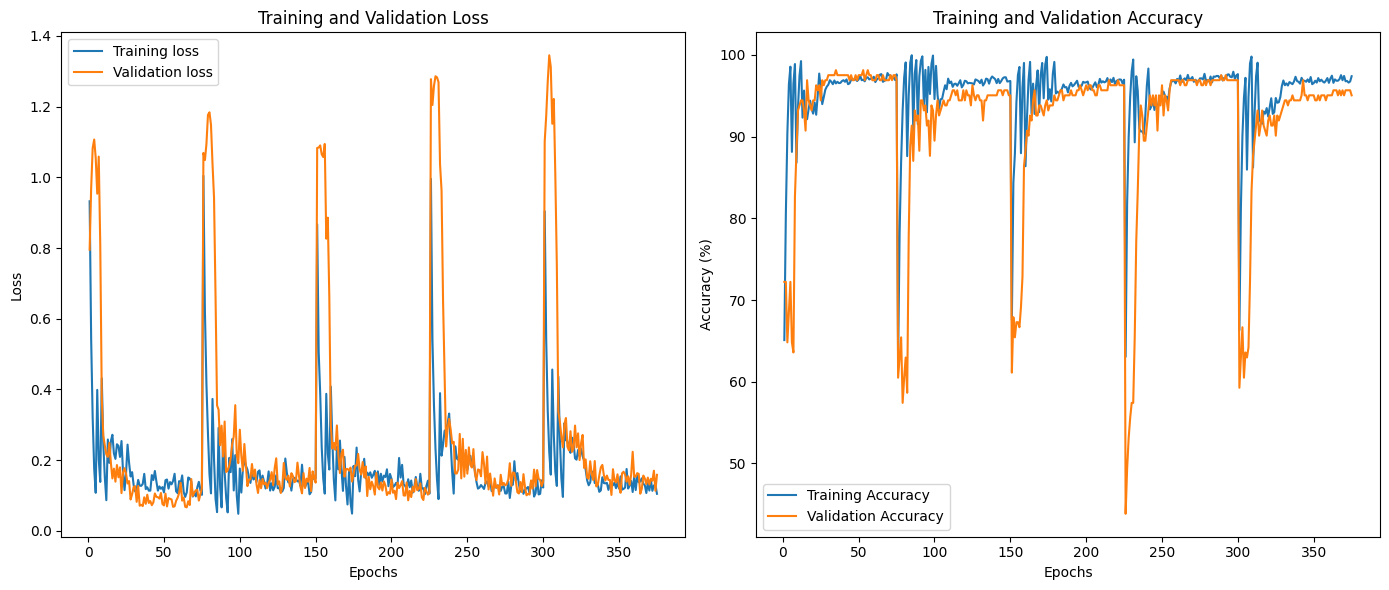

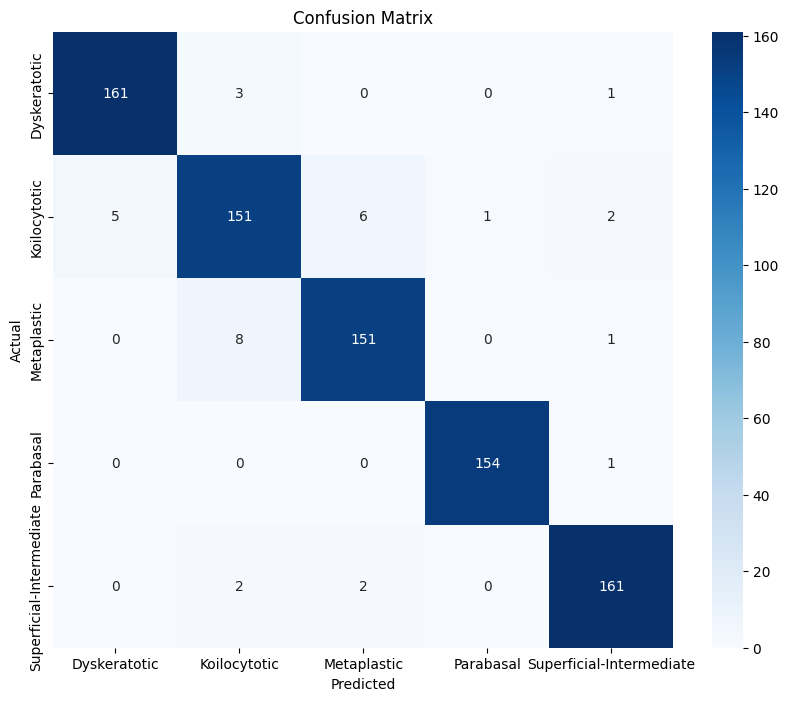

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold, train_test_split
from torchvision import transforms
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import os


def print_score(y_true, y_pred):
    print('------Weighted------')
    print('Weighted precision', precision_score(y_true, y_pred, average='weighted'))
    print('Weighted recall', recall_score(y_true, y_pred, average='weighted'))
    wf1 = f1_score(y_true, y_pred, average='weighted')
    print('Weighted f1-score', wf1)
    print('------Macro------')
    print('Macro precision', precision_score(y_true, y_pred, average='macro'))
    print('Macro recall', recall_score(y_true, y_pred, average='macro'))
    maf1 = f1_score(y_true, y_pred, average='macro')
    print('Macro f1-score', maf1)
    return wf1, maf1


def is_image_file(filename):
    return filename.endswith('.bmp')


def find_classes(dir):
    classes = [d.name for d in os.scandir(dir) if d.is_dir()]
    classes.sort()
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.RandomApply([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(270),
            transforms.RandomAffine(degrees=270, translate=(0.1, 0.1), shear=0.1, scale=(0.98, 1.02)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2)
        ], p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
}


def train():
    model.train()
    loss, correct, total = 0.0, 0, 0
    pred_total = None
    y_total = None
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        targets = targets.to(device)

        with autocast():
            scores = model(data)
            current_loss = criterion(scores, targets)

        optimizer.zero_grad()
        scaler.scale(current_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        _, predictions = torch.max(scores, dim=1)
        loss += current_loss.item()
        total += targets.size(0)
        correct += (predictions == targets).sum().item()
        if pred_total is None:
            pred_total = predictions
            y_total = targets
        else:
            pred_total = torch.concat([pred_total, predictions], dim=0)
            y_total = torch.concat([y_total, targets], dim=0)
    batch_idx += 1
    loss /= batch_idx
    train_acc = 100 * correct / total
    print(f'Train Loss: {loss}')
    print(f'Train Acc ({total}): {train_acc}%')
    print_score(y_total.flatten().cpu(), pred_total.flatten().cpu())
    return loss, train_acc


def val():
    model.eval()
    loss, correct, total = 0.0, 0, 0
    pred_total = []
    y_total = []
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(val_loader)):
            data = data.to(device)
            targets = targets.to(device)

            scores = model(data)
            val_loss = criterion(scores, targets)
            _, predictions = torch.max(scores, dim=1)
            loss += val_loss.item()
            total += targets.size(0)
            correct += (predictions == targets).sum().item()
            pred_total.extend(predictions.cpu().numpy())
            y_total.extend(targets.cpu().numpy())
    batch_idx += 1
    loss /= batch_idx
    accuracy = 100 * correct / total
    print(f'Val Loss: {loss}')
    print(f'Val Acc ({total}): {accuracy}%')
    print_score(np.array(y_total), np.array(pred_total))
    return loss, accuracy, y_total, pred_total


if __name__ == "__main__":
    dir = '/kaggle/input/sipakmed-dataset/SIPaKMeD dataset'
    classes, class_to_idx = find_classes(dir)
    imgs = []
    labels = []
    for target_class in sorted(class_to_idx.keys()):
        class_index = class_to_idx[target_class]
        target_dir = os.path.join(dir, target_class)
        if not os.path.isdir(target_dir):
            continue
        for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
            for fname in sorted(fnames):
                path = os.path.join(root, fname)
                if is_image_file(path):
                    imgs.append(path)
                    labels.append(class_index)

    skf = StratifiedKFold(n_splits=5)
    test_accuracies = []
    test_losses = []
    train_loss_list = []
    val_loss_list = []
    train_accuracy_list = []
    val_accuracy_list = []
    all_preds = []
    all_labels = []
    all_precisions = []
    all_recalls = []
    all_f1s = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(imgs, labels)):
        print(f'Fold {fold + 1}')
        train_imgs, val_imgs = np.array(imgs)[train_idx], np.array(imgs)[val_idx]
        train_labels, val_labels = np.array(labels)[train_idx], np.array(labels)[val_idx]

        # Further split train set to create a small validation set
        train_imgs, val_imgs_inner, train_labels, val_labels_inner = train_test_split(
            train_imgs, train_labels, test_size=0.05, stratify=train_labels
        )
        settings = TolerateLossEpochsPeriod(7e-2)
        train_dataset = MyDataset(train_imgs, train_labels, transform=data_transforms['train'])
        val_dataset = MyDataset(val_imgs_inner, val_labels_inner, transform=data_transforms['val'])
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        model = VTCNet(5).to(device)
        initialize_weights(model)
        model = nn.DataParallel(model)

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=3e-2)
        scaler = GradScaler()
        train_loss = 1e5
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
        best_acc = 0.0
        best_model_wts = None

        for epoch in range(num_epochs):
            scheduler.step()
            settings.step(train_loss)
            print(f'Epoch {epoch + 1}/{num_epochs}')
            train_loss, train_acc = train()
            val_loss, val_acc, _, _ = val()
            print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%')
            print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')
            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = model.state_dict()

            train_loss_list.append(train_loss)
            val_loss_list.append(val_loss)
            train_accuracy_list.append(train_acc)
            val_accuracy_list.append(val_acc)

        # Load best model weights from the validation phase
        model.load_state_dict(best_model_wts)

        # Evaluate the model on the final validation set (which serves as the test set for this fold)
        final_val_dataset = MyDataset(val_imgs, val_labels, transform=data_transforms['val'])
        final_val_dataloader = DataLoader(final_val_dataset, batch_size=batch_size, shuffle=False)
        test_loss, test_acc, y_true, y_pred = val()

        # Record the test accuracy and loss
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)

        all_preds.extend(y_pred)
        all_labels.extend(y_true)

        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')

        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1s.append(f1)

        print(f'Fold {fold + 1}, Test Accuracy: {test_acc:.2f}%, Test Loss: {test_loss:.4f}')
        print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

    # Calculate the average test accuracy, loss, precision, recall, and f1-score across all folds
    average_test_acc = np.mean(test_accuracies)
    average_test_loss = np.mean(test_losses)
    average_precision = np.mean(all_precisions)
    average_recall = np.mean(all_recalls)
    average_f1 = np.mean(all_f1s)

    print(f'Average Test Accuracy: {average_test_acc:.2f}%, Average Test Loss: {average_test_loss:.4f}')
    print(f'Average Precision: {average_precision:.4f}, Average Recall: {average_recall:.4f}, Average F1-score: {average_f1:.4f}')

    # Plot training and validation loss and accuracy
    epochs = range(1, len(train_loss_list) + 1)
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_list, label='Training loss')
    plt.plot(epochs, val_loss_list, label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy_list, label='Training Accuracy')
    plt.plot(epochs, val_accuracy_list, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()


Average Test Accuracy: 96.05%, Average Test Loss: 0.1313
Average Precision: 0.9619, Average Recall: 0.9608, Average F1-score: 0.9609


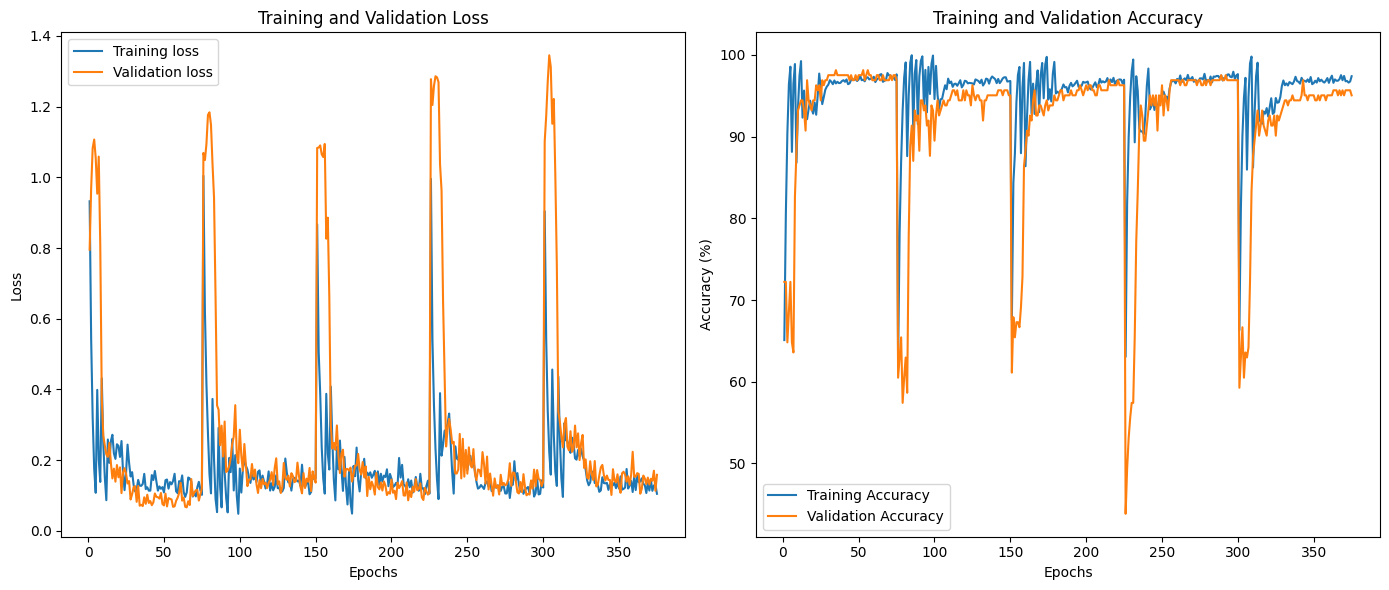

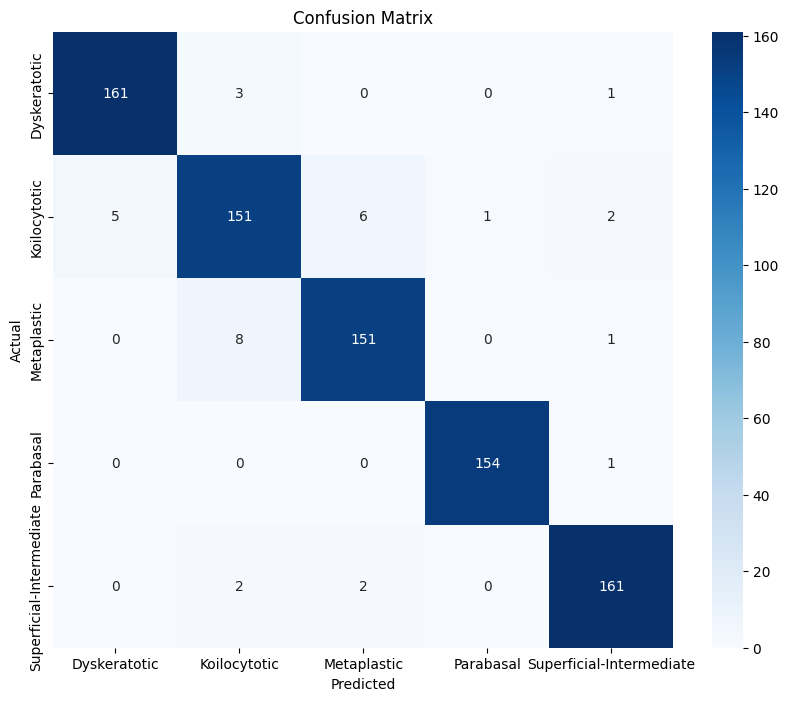

In [9]:

    print(f'Average Test Accuracy: {average_test_acc:.2f}%, Average Test Loss: {average_test_loss:.4f}')
    print(f'Average Precision: {average_precision:.4f}, Average Recall: {average_recall:.4f}, Average F1-score: {average_f1:.4f}')

    # Plot training and validation loss and accuracy
    epochs = range(1, len(train_loss_list) + 1)
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_list, label='Training loss')
    plt.plot(epochs, val_loss_list, label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy_list, label='Training Accuracy')
    plt.plot(epochs, val_accuracy_list, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()
